In [1]:
!pip install scikit_posthocs

In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import math
import seaborn as sns
import os
import json
import scipy.stats as stats
import pylab
import scikit_posthocs as sp

# Table of Contents / Checklist
🟢 results in paper
🔵 results in appendix
🟡 completed experiments
❌ still to-do

- nEVD Proof of Concept 🔵
- Passive nEVD (gridworld, driving) (🟢,🟢)
- Passive baseline (gridworld, driving) (🟢,🟢)
- Passive nEVD (lander, lavaworld) (🟢,🟢)
- Passive baseline (lander, lavaworld) (🟢,🟢)
- Active nEVD (gridworld, driving) (🟢,🟢)
- Active baseline (gridworld, driving) (🟢,🟢)
- Active vs. passive comparison 🟢
- Hoeffding bounds comparison 🟢
- Informative vs. ambiguous demos comparison 🔵 (combined with below)
- Repeat demos comparison 🔵
- MAP policy baseline (gridworld, driving) (🟢,🟢)
- MAP policy baseline (lander, lavaworld) (🟢,🟢)
- Held out set baseline (gridworld, driving) (🟢,🟢)
- Held out set baseline (lander, lavaworld) (🟢,🟢)
- Reconsolidated Methodology Plots 🟢
- User study analysis 🟢

# Plotting Utils

In [3]:
color_scheme = {
    "gridworld": "#2CA02C", # green
    "driving": "#FF7F0E", # orange
    "lander": "#1F77B4", # blue
    "lavaworld": "#D62728", # red
    
    "nevd": "red",
    "MAP1": "mediumorchid",
    "MAP2": "rebeccapurple",
    "held_out1": "limegreen",
    "held_out2": "seagreen"
}
# plus solid for TPR, dotted for TNR

In [4]:
def mean(val):
    if isinstance(val, list):
        return np.mean(val) if len(val) != 0 else 0
    else:
        return val

def sem(val, n = None):
    if isinstance(val, list):
        if n:
            return np.std(val) / np.sqrt(n) if len(val) != 0 else 0
        else:
            return np.std(val) / np.sqrt(100) if len(val) != 0 else 0
    else:
        return 0
    
plt.rcParams.update({'font.size': 18, 'lines.linewidth': 3})
plt.rcParams["font.family"] = "Times New Roman"

In [5]:
def sensitivity_plot(cm1, env1, thresholds, cm2 = None, env2 = None):
    fig, ax = plt.subplots(1, 1, figsize = (5, 5))
    if not cm2:
        tpr = [np.nan_to_num(cm1[t][0][0] / np.sum(np.array(cm1[t]), axis = 0)[0]) for t in thresholds]
        tnr = [np.nan_to_num(cm1[t][1][1] / np.sum(np.array(cm1[t]), axis = 0)[1]) for t in thresholds]
        plt.plot(thresholds, tpr, label = "TPR ({})".format(env1), color = color_scheme[env1], linestyle = "-")
        plt.plot(thresholds, tnr, label = "TNR ({})".format(env1), color = color_scheme[env1], linestyle = ":")
    else:
        tpr1 = [np.nan_to_num(cm1[t][0][0] / np.sum(np.array(cm1[t]), axis = 0)[0]) for t in thresholds]
        tnr1 = [np.nan_to_num(cm1[t][1][1] / np.sum(np.array(cm1[t]), axis = 0)[1]) for t in thresholds]
        tpr2 = [np.nan_to_num(cm2[t][0][0] / np.sum(np.array(cm2[t]), axis = 0)[0]) for t in thresholds]
        tnr2 = [np.nan_to_num(cm2[t][1][1] / np.sum(np.array(cm2[t]), axis = 0)[1]) for t in thresholds]
        plt.plot(thresholds, tpr1, label = "TPR ({})".format(env1), color = color_scheme[env1], linestyle = "-")
        plt.plot(thresholds, tnr1, label = "TNR ({})".format(env1), color = color_scheme[env1], linestyle = ":")
        plt.plot(thresholds, tpr2, label = "TPR ({})".format(env2), color = color_scheme[env2], linestyle = "-")
        plt.plot(thresholds, tnr2, label = "TNR ({})".format(env2), color = color_scheme[env2], linestyle = ":")
    ax.set_yticks(np.arange(0.0, 1.1, 0.2))
    if len(thresholds) == 5: # nevd
        ax.set_xticks(thresholds)
    else: # baseline
        ax.set_xticks(thresholds[::2])
    plt.ylabel("Actual vs. Predicted Rates")
    plt.xlabel("Thresholds")
    plt.legend(fontsize="10")
    plt.show()

In [6]:
def plot_results(metrics1, env1, thresholds, metrics2 = None, env2 = None):
    ### Setup
    fig, axes = plt.subplots(1, 4, figsize = (30, 6))
    x = thresholds
    
    ### Plotting results set 1
    if env1 == "lander" or env1 == "lavaworld":
        y = np.array([mean(metrics1["num_demos"][t]) for t in x])
        axes[0].plot(x, y, color = color_scheme[env1], label = env1.capitalize())
        err = np.array([sem(metrics1["num_demos"][t]) for t in x])
        axes[0].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme[env1])
        axes[0].set(xlabel = "Thresholds", ylabel = "Number of Demos Needed")
    else:
        y = np.array([mean(metrics1["pct_states"][t]) for t in x])
        axes[0].plot(x, y, color = color_scheme[env1], label = env1.capitalize())
        err = np.array([sem(metrics1["pct_states"][t]) for t in x])
        axes[0].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme[env1])
    
    y = np.array([mean(metrics1["avg_bound_errors"][t]) for t in x])
    axes[1].plot(x, y, color = color_scheme[env1], label = env1.capitalize())
    err = np.array([sem(metrics1["avg_bound_errors"][t], n = 10000) for t in x])
    axes[1].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme[env1])
    
    y = np.array([mean(metrics1["policy_optimalities"][t]) for t in x])
    axes[2].plot(x, y, color = color_scheme[env1], label = env1.capitalize())
    err = np.array([sem(metrics1["policy_optimalities"][t]) for t in x])
    axes[2].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme[env1])
    
    y = np.array([metrics1["accuracies"][t] for t in x])
    axes[3].plot(x, y, color = color_scheme[env1], label = env1.capitalize())
    err = np.array([np.std(y) / np.sqrt(len(y))] * len(y))
    axes[3].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme[env1])
    
    ### Plotting results set 2
    if metrics2:
        if env2 == "lander" or env2 == "lavaworld":
            y = np.array([mean(metrics2["num_demos"][t]) for t in x])
            axes[0].plot(x, y, color = color_scheme[env2], label = env2.capitalize())
            err = np.array([sem(metrics2["num_demos"][t]) for t in x])
            axes[0].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme[env2])
            axes[0].set(xlabel = "Thresholds", ylabel = "Number of Demos Needed")
        else:
            y = np.array([mean(metrics2["pct_states"][t]) for t in x])
            axes[0].plot(x, y, color = color_scheme[env2], label = env2.capitalize())
            err = np.array([sem(metrics2["pct_states"][t]) for t in x])
            axes[0].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme[env2])

        y = np.array([mean(metrics2["avg_bound_errors"][t]) for t in x])
        axes[1].plot(x, y, color = color_scheme[env2], label = env2.capitalize())
        err = np.array([sem(metrics2["avg_bound_errors"][t]) for t in x])
        axes[1].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme[env2])

        y = np.array([mean(metrics2["policy_optimalities"][t]) for t in x])
        axes[2].plot(x, y, color = color_scheme[env2], label = env2.capitalize(), linestyle = "--")
        err = np.array([sem(metrics2["policy_optimalities"][t]) for t in x])
        axes[2].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme[env2])

        y = np.array([metrics2["accuracies"][t] for t in x])
        axes[3].plot(x, y, color = color_scheme[env2], label = env2.capitalize(), linestyle = "--")
        err = np.array([np.std(y) / np.sqrt(len(y))] * len(y))
        axes[3].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme[env2])
    
    ### Plot configurations
    if env1 == "lander" or env2 == "lander" or env1 == "lavaworld" or env2 == "lavaworld":
        axes[0].set(xlabel = "Thresholds", ylabel = "Number of Demos Needed")
        axes[0].set_yticks(np.arange(0, 11, 1))
    else:
        axes[0].set(xlabel = "Thresholds", ylabel = "Proportion of States Needed")
        axes[0].set_yticks([round(v, 2) for v in np.arange(0.40, 0.81, 0.05)])
    
    axes[1].set(xlabel = "Thresholds", ylabel = "Bound Error")
#     axes[1].set_yticks([round(v, 2) for v in np.arange(0.00, 0.035, 0.01)])
    
    axes[2].set_yticks([round(v, 1) for v in np.arange(0.7, 1.01, 0.1)])
    axes[2].set_ylim([0.67, 1.03])
    axes[2].set(xlabel = "Thresholds", ylabel = "Policy Optimality")
    
    axes[3].set_yticks([round(v, 1) for v in np.arange(0.7, 1.01, 0.1)])
    axes[3].set_ylim([0.67, 1.03])
    axes[3].set(xlabel = "Thresholds", ylabel = "Accuracy")
    
    for i in range(4):
        axes[i].legend()

    plt.show()

In [7]:
def calc_F1(matrix):
    # either confusion_matrices, CM100, CM95, CM90, CM5, CM4, CM3, CM2, or CM1
    # or 0.5, 0.4, 0.3, 0.2, 0.1
    TP = matrix[0][0]
    FP = matrix[0][1]
    FN = [1][0]
#     print("TP", TP)
#     print("FP", FP)
#     print("FN", FN)
    F1 = TP / (TP + 0.5*(FP + FN))
    return F1

In [8]:
nevd_thresholds = [0.1, 0.2, 0.3, 0.4, 0.5]
baseline_thresholds = [round(t, 1) for t in np.arange(start = 0.0, stop = 1.1, step = 0.1)]
patience_thresholds = [1, 2, 3, 4, 5]
held_out_thresholds = [3, 4, 5, 6, 7]

# nEVD Proof of Concept

In [9]:
num_demos = list(range(1, 10))
accs = {0.9: [], 0.95: [], 0.99: []} # accuracies
abes = {0.9: [], 0.95: [], 0.99: []} # bound errors
apls = {0.9: [], 0.95: [], 0.99: []} # a-var bounds
evds = {0.9: [], 0.95: [], 0.99: []} # evd

In [10]:
# with seed
accs[0.9] = [0.93, 0.94, 0.94, 0.94, 0.95, 0.95, 0.97, 0.97, 0.97]
abes[0.9] = [[0.005575862933527048, 0.026440997995775112, 0.6353823661023819, 0.006592893134640026, 0.5131673230269298, 0.2114465724215453, 0.07089440847251585, -0.7674635140014803, 0.031339627955423395, 0.26416596482215726, 0.16358008562716275, 0.004831095158673646, 2.6946624783758133, 0.06282029907297364, 3.7113432447770016, -0.37895766552390153, 0.03649110264024428, 4.448209024924894, 1.1576252101265214, 0.0, 0.2264524081077759, 0.13398784346222348, -0.18733053916141834, -0.1276605814922549, 0.005111749485464319, 2.181356946794727, 3.1920005765544723, 0.0, -0.00860379224138974, 0.4575690092242168, 0.8672726905345101, 0.5381101897406539, 0.0, 0.467395541163881, 0.807723312417043, 0.4586290142128968, 0.027319209785037865, 0.04722160871666943, 0.011614442165778274, 0.09829047337365719, 1.6781758824843898, 0.04701156664571772, 0.013692084188702077, -0.02682030100045729, 0.8843669921309537, 0.02343089509827009, 0.42096927632199066, 0.3697402144476909, 0.0, 0.8153207195302486, 0.4605877481208711, 2.0001274786458345, 0.2537732173369802, 0.32109982339652693, 0.0, 0.27783711491468827, 0.09822092370971654, 1.0546723512791676, 0.017888933920209314, 0.03609476018059656, 0.010223440564371796, 0.7331652417779175, 0.13212946706734793, 0.7212981278861128, 1.4100219812035384, 0.07155203885623794, 1.2786573895375177, 6.104341774717665, 0.0, 0.0, 3.4175272904220706, 2.9874677354071557, 1.3019853317919956, 0.005854005094352069, 0.047439012512816583, -0.14334584148752239, 0.42343573029021936, 1.3282487406044574, 0.08268663482108211, 0.06438528136086549, 0.04161326565660239, 0.023949655536401857, 1.746712964877388, 0.006016686554949259, 0.1734103563977476, 2.117575650085843, 1.2793199443225687, 0.05421487435080472, 0.34665189329360163, 0.3317853987959673, 0.0, 0.0, 1.1709933039779912, 0.09495910336051411, 0.3895599223242409, 0.010010192405272672, 0.2968999128484676, 1.2760895971909327, 0.23717727235840186, 3.7603995315480985], [0.008361340896984948, 0.02264572446726177, 0.685292495514562, 0.0069192617829473375, 0.5776355691608188, 0.23461829224156006, 0.3628723233514352, 0.006140947915259701, 0.02865944707129321, 0.13690293305365345, 0.3124061455378535, 0.004296702852209868, 1.7121179660373118, 0.015801557681893272, 0.00610038322570319, 0.11171188416917507, 0.02365072942495522, 3.0710489744818905, 0.013358509962157575, 0.0, 0.0888491887637962, 0.11419121017251184, 0.021814667619216684, 0.19305601956820584, 0.007744542535426706, 1.8431260744051792, 1.817238626359252, 0.0, -0.009401408615597094, 0.047751922512571564, -0.6263251652617206, 0.0010216114150746096, 0.0, 0.021279500224754375, 0.6395081069948473, 0.9059032837897621, 0.0, 0.024064338042289652, 0.049193952001412064, 0.08243067837534601, 0.26769285593577014, 0.018693491125940306, 0.009058889334951883, 0.0015553655685414964, 0.0, 0.014870947307679676, 0.011628361351069174, -0.0025227418203035944, 0.0, 0.009051959892413964, 0.14060712931306, 0.3101556697201433, 2.463030190923493, 0.6766887440821258, 0.0, 0.011562843802239724, 0.002054917729303393, 1.533611505054193, 0.002540001714948533, 0.023449191673495868, 0.010982405283877604, 0.40818818166272963, 0.40912716589722187, 0.11111341148901505, 0.016197885454918126, 2.830896536446685, 1.5933635651656226, 4.494454258236649, 0.0, 0.0081194192365444, 0.0013859923732334313, 3.4223400395601336, 0.028055462898354033, 0.0024081753424485992, 0.007836672422063715, -0.29806914622199576, -0.001075144552805718, 3.3780144711564515, 0.030385407754306735, 0.09359696089240224, 0.01567688921827379, 0.03310968291039665, 0.007777778018887276, 0.004774879194505052, -0.002379477907355749, 0.0005442554830327258, 0.004123429650572799, 0.019820563794832328, 0.10459980134527005, 0.0, 0.49943455462391984, 0.0, 0.24928477372809574, 0.006405079898544441, 0.014396996530598609, 0.00358623570196724, 0.0, 0.4869764397197904, 0.00294091563308458, 0.11815576412517127], [0.00449988264105251, 0.027082034215887958, 0.0, 0.004608181087022821, 0.0, 0.006842339001856137, 0.16987726198850045, 0.0037845151481797025, 0.0073286519728834685, 0.05809793837683108, 1.3210869282659652, 0.005125286110601841, 0.00012903970403484698, 0.019271441846185417, 0.005665694413646689, 0.007867211698567892, -0.01661379571725245, 2.6896319525169337, 0.022681098891816805, 0.0, 0.19149705255133637, 0.006901172412063341, 0.0, -0.030406492607751634, 0.007218335393554901, 0.01702282685933125, 0.1049739302048626, 0.0, -0.003947348787133584, 0.007470091874527359, 0.03982953590065086, 0.0010591973083928707, 0.0, 0.02053564477811203, 0.2564557999508801, 0.5344494772324645, 0.0017198907206926347, 0.016826535051307177, 0.021216066924912395, 0.0, 0.0, 0.015213720180357227, 0.009944800557229776, 0.002911244802369954, 0.0, 0.017875129609153537, 0.0034531765916045783, 0.0037439393356833717, 0.0, 0.0017108368568336703, 0.0, 0.002628442312738115, 2.571224262710211, 0.0, 0.0, 0.004764688538199429, 0.0032476171225667753, 0.3960597654749097, 0.00270322979008993, 0.016323857388447428, 0.007904121218109694, 0.0, 0.45904651311128475, 0.041497951265883064, 0.011654518636175002, 3.9446713008436247, 0.035047717972446116, 0.13557444339048186, 0.0, 0.0, 0.00017649279673506265, 0.0, 0.0, 0.004832135425217012, 0.007482840664609973, 0.0042269703583532135, 0.0011677936092461304, 0.03403769330940713, 0.009214718109117878, 0.014055497335748221, 0.0030411195395741524, 0.022169372817405775, 0.0643221383807621, 0.004790771880742523, 0.005482381530463041, 0.003213951859523788, 0.005994273006693575, 0.021703111262280955, -0.028687499670387324, 0.043158486140258454, 0.027179917562406283, 0.0, 0.04167680522170561, 0.008965280475499946, -0.0068620674030624995, 0.007071422242265179, 0.0, 0.17660234839051825, 0.01484327714598127, 0.0013437690239692492], [0.005565913106759689, 0.0038739375463242263, 0.037654530585519035, 0.004455507212279972, 0.0, 0.0188583878462312, 0.016953488138980358, 6.0879810348921724e-05, 0.005106805307088838, 0.0004816792751919788, 0.0, 0.004242513091097606, 0.00030625766104086744, 0.020008420114356856, 0.004122896240973806, 0.0009196265937617817, 0.01899483460636026, 0.0, 0.014100463096997804, 0.0, -0.0015540978188841367, 0.002523660980915129, 3.637078612576815, 0.4055958057456439, 0.005754794216141157, 0.013254357454104488, 0.01725290877348535, 0.0, -0.005009135115075662, 0.0017891306568404183, 0.041313432140637193, 0.0012814520040033135, 0.0, 0.019218427836232406, 0.0, 0.4777701170881177, 0.0, 0.016402022934651348, 0.007914893658941822, 0.0, 0.0005665710514598312, 0.01311049320139724, 0.008326906908278333, 0.0016264827299875525, 0.0, 0.020714902301631276, 0.0010106568749863388, 0.006338137764810204, 0.0, -0.0026647058070687207, 0.0, 0.0021680521134402296, 0.0, 0.0, 0.0, 0.005819212143853593, 0.002674484206523457, 0.14640192111032335, 0.0025931261858608587, 0.01855374870347957, 0.009305715911973851, 0.0, 0.0, 0.0, 0.003970957928108815, 0.00154392788105458, 0.015052819125416875, 0.0016206627845760948, 0.0, 0.0, 0.0006523028975644556, 0.0, 0.0, 0.000528733771054021, 0.0056167633765770095, 0.0005824152664621501, 0.0011186337833459308, 0.01891503431677895, 0.00962931846182509, 0.0024679548184873166, 0.0, 0.023874475540532306, 0.008175850946963678, 0.003127928281346536, -0.00572747592573292, 0.0005048936890039498, 0.0, 0.014366579667425395, 0.004772014303780202, 0.0, 0.0995503831358946, 0.0, 0.001052798533123291, 0.008053161802098377, -0.005330627209060797, 0.0005104329452763058, 0.0, 0.0, -0.0014743051776311515, 8.805505895113485e-05], [0.0035106799356403946, 0.01550320224005059, 0.0, 0.000765647812631219, 0.0, 0.0, 0.013382617087102847, 0.0004878821452770997, 0.005939329734079031, 0.00025064273443938624, 0.0, 0.0048506989493866896, 0.0, 0.021176533945950912, 0.006594864580695935, 0.00036891660063008284, -0.024463850877478304, 0.0, 0.012750565372551953, 0.0, 0.000621444632826803, 0.0027299102834140833, 0.0, 0.44615113644513016, 0.007665534703922823, 0.0012538815041540446, 0.0018194827752063408, 0.0, 0.006401909167244231, 0.019475156382525394, 0.033591113167980594, 0.0, 0.0, 0.018499599567854387, 0.0, 0.004298723245092313, 0.0, 0.014310883763654346, 0.0, 0.0, 0.0, 0.013286528778526117, 0.007836517078650395, 0.0, 0.0, 0.011871615095476327, 0.001517864914440814, -0.0017624447016556383, 0.0, -0.0015863662702486868, 0.0, 0.007977365894395431, 0.0, 0.0, 0.0, 0.005425898229870713, 0.005672518917562342, 0.0140235842352312, 0.004017854379729455, 0.020865165114876377, 0.004704670535064992, 0.0, 0.0, 0.0, 0.008450663993301763, 0.002555308583175673, 0.012747123662086461, 0.0022481702727300277, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004797396455307979, 0.000828489078419074, 0.0004559198808003651, 0.022507320117146734, 0.00925858614396997, 0.005377664245855556, 0.0019896471728080463, 0.01646411540580297, 0.00704765423825059, 0.006681413431119731, 0.0022491885416834403, 0.0008006395435862376, 0.0, 0.010157830155869959, 0.2434872744503016, 0.0, 0.0, 0.0, 0.006265614529106939, 0.006461267923600727, -0.002758993621523415, 0.0, 0.0, 0.0, -0.004541429197199687, -0.0002577131242370665], [0.0022173091247087253, 0.012794491236669389, 0.0, 0.000874907066720366, 0.0, 0.0, 0.013817854524128906, 0.001068404021846714, 0.003441137921949683, 0.0006515255873375164, 0.0, 0.004017095118741134, 0.0005829643686885642, 0.011915507834199006, 0.0010904299326078067, 0.0, 0.024708168537641784, 0.0, 0.017019340866580624, 0.0, 0.0004253076952992676, 0.0028295669152484633, 0.0, 0.0009543531337127528, 0.0, 0.0, 0.0014071173235105077, 0.0, 0.0031469616487483586, 0.0033595684948710043, 0.028938915214428866, 0.0006731364295472431, 0.0, 0.014513449413947471, 0.0, 0.0030384490246413314, 0.0, 0.008974378890609508, 0.0, 0.0, 0.0, 0.0004645879532925982, 0.007249776404041744, 0.0, 0.0, 0.001095119986515918, 0.0, -0.003410769307672334, 0.0, -0.0008997849407859013, 0.0, 0.00761260700041221, 0.0, 0.0, 0.0, 0.00602012451816082, 0.001376006844326386, 0.15196553833428372, 0.0009249096758656808, 0.014962067436278537, 0.0042150205686534515, 0.0, 0.0, 0.0, 0.00813072940224516, 0.0017972031838727025, 0.0099911100931913, 0.0005946737741669436, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004190337812718966, 0.0012546827013657808, 0.0004575546617552455, 0.0022915722588205734, 0.002942408502667737, 0.002132504307988601, 0.0, 0.01890191684325892, 0.007812782878329146, 0.0, 0.0010976318235205679, 0.0007917009125175574, 0.0, 0.0059083487871933755, 0.03956627443976838, 0.0, 0.0, 0.0, 0.002169960054450337, 0.004639878859825185, -0.0025709404554660584, 0.0, 0.0, 0.0, -0.0024510512646565875, -0.0022412243368275537], [0.004091945849821879, 0.0017718573075555157, 0.0, 0.000729142019874345, 0.0, 0.0, 0.011702328006601403, 0.0010881741220139744, 0.0028404699802984474, 0.0, 0.0, 0.004005146516012416, 0.0005743691645221816, 0.011155152528381238, 0.0007896140943214453, 0.0014665380051619818, -0.022729621265206848, 0.0013519657559088122, 0.016215867212036297, 0.0, 0.0007705695742258099, 0.0011617566995867565, 0.0, 0.0004269601042632406, 0.0, 0.0005285685813565525, 0.00044364765070473676, 0.0, 0.0, 0.0016502108398187317, 0.0252794278890445, 0.001230086068053674, 0.0, 0.018629425401847758, 0.0, 0.001224516221694532, 0.0, 0.001847549239108334, 0.00023461357889724107, 0.0, 0.0, 0.0, 0.0031412555562872722, 0.0, 0.0, 0.0002921371706810038, 0.0, 0.0004733123777258387, 0.0, -0.0016065906916272795, 0.0, 0.00850700294614369, 0.0, 0.0, 0.0, 0.005571937437323428, 0.0016997919137700965, 0.002139525432813836, 0.000395472497153259, 0.009044996020730073, 0.00457626425406093, 0.0, 0.0, 0.0, 0.011053745793065917, 0.0018276344896095015, 0.014852002387860172, 0.0006863880652332327, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0004556826725501326, 0.007070954349236608, 0.0007476266724386319, 0.0, 0.0, 0.0018365585741739, 0.003686605170622923, 0.0, 0.017738594267712536, 0.0035525969461235657, 0.0005158241120749743, 0.0027471610533490016, 0.0004101754985678175, 0.0, 0.005886755096966093, 0.044906197885260776, 0.0, 0.0, 0.0, 0.0004291197153559888, 0.008756934453195512, -0.003021189567808064, 0.00022991818255370085, 0.0, 0.0, 0.0, 0.0006328148312450544], [0.0045017228453234194, 0.0025160836521847052, 0.0, 0.0009137079570537976, 0.0, 0.0, 0.00940502813279132, 0.0006697022185505024, 0.004572163564809802, 0.00012615345993341798, 0.0, 0.003292201442605479, 0.001015112259082629, 0.009953550559620791, 0.0010486901605424221, 0.0, -0.03075543451634127, 0.0008906403754129386, 0.011238564217197931, 0.0, 0.0, 0.0030426731881175503, 0.0, 0.0002671830037320179, 0.0, 0.0008074062591424423, 0.003913716908297029, 0.0, 0.0, 0.00028396743311422893, 0.03093818308845939, 0.001132624298793449, 0.0, 0.017963515036622326, 0.0, 0.0010281707041551852, 0.0, 0.0012669697994452808, 0.0003849259279031794, 0.0, 0.0, 0.0, 0.0, 0.0003034774934465288, 0.0, 0.00045662671997356836, 0.0, 0.00047528957344089936, 0.0, -0.0007791112912955353, 0.0, 0.008575239887631954, 0.0, 0.0, 0.0, 0.0, 0.0023422588628848246, 0.0, 0.0004096639258598113, 0.012490824297032084, 0.00045142001520632726, 0.0, 0.0, 0.0, 0.0, 0.0015753553263919415, 0.011952171339539743, 0.0011219920201580894, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0009641524420180182, 0.0037402486211160907, 0.00017648100642274453, 0.00048703610933301133, 0.0, 0.0027532526896968776, 0.0016881646205988558, 0.0, 0.0015003595078728633, 0.006283967121116633, 0.0005146078810132597, 0.002761104287496054, 0.00040494518006854453, 0.0, 0.009859510762688987, 0.046614492653462944, 0.0, 0.0, 0.0, 0.004240714904431722, 0.0051939624968260125, -0.002969699577521484, 0.00031709175316456216, 0.0, 0.0, 0.0, 0.000582439824863023], [0.002038495095309009, 0.00037798147368962073, 0.0, 0.0006835875813346498, 0.0, 0.0, 0.0, 0.0011630985264990453, 0.002315093880584725, 0.00047651740701342907, 0.0, 0.004277222062163554, 0.00037969186010323644, 0.0009324790638327099, 0.0008244760451641627, 0.0006133072582410594, -0.02715670315108002, 0.0, 0.004110032132940141, 0.0, 0.00039714552931769136, 0.0027226230519104997, 0.0, 0.0, 5.335438228912747e-05, 0.0, 0.0009277108057199555, 0.0, 0.0, 0.0007984596150562959, 0.001801403395099909, 4.0747783459490935e-05, 0.0, 0.02043125154515986, 0.0, 0.000142454817243558, 0.0, 0.0, 0.0, 0.0, 5.6171469798479776e-05, 0.0003602450979017809, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0008176720873475923, 0.0, -0.0012148670879419017, 0.0, 0.0006428361467996503, 0.0, 0.0, 0.0, 2.1984317793841876e-05, 0.00558101749827712, 0.00021236952606806884, 0.00024046457158104833, 0.016737394077473516, 0.000891355636874496, 0.0, 0.0, 0.0, 0.0, 0.0010187502018804665, 0.0, 0.000773135589442112, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0004487395910550077, 0.004747259401580775, 0.0015009151243670481, 0.0010560111994218275, 0.0, 0.002792449167587312, 0.00042184017826156186, 0.0, 0.0015828425201687792, 0.0037255104386653666, 0.0, 0.0, 0.00033603446986070533, 0.0008016209195718382, 0.009863915029440742, 0.11205368376698076, 0.0, 0.0, 0.0, 0.000487030012032378, 0.010768850803743067, -0.003021189567808064, 0.00035530285799294855, 0.0, 0.0, 0.0, 0.0013425338166466482]]
apls[0.9] = [[0.008213496978643601, 0.026440997995775112, 0.6353823661023819, 0.006592893134640026, 2.71961066056157, 5.299812362242409, 0.07265829304509772, 1.0177915689623185, 0.034639788272584376, 0.2666957301478402, 3.866192262483099, 0.00614780033043704, 2.6946624783758133, 0.06282029907297364, 3.7165746922059766, 2.4795370014917153, 0.04339818899550457, 4.448209024924894, 1.1576252101265214, 0.0, 0.2264524081077759, 0.13840318961019538, 0.06052608788059295, 1.3464324277995183, 0.012661373563118859, 2.181356946794727, 3.2005380152116643, 0.0, 0.03271329416900465, 0.4575690092242168, 2.6950417723310816, 0.5479402220403408, 0.0, 0.467395541163881, 0.807723312417043, 0.998480246028362, 0.027319209785037865, 0.04722160871666943, 0.01351095430807117, 0.09829047337365719, 2.358277355471964, 0.04701156664571772, 0.013692084188702077, 2.421136212666209, 0.8843669921309537, 0.027786645517956763, 0.4356597908582659, 0.3779576798674422, 0.0, 0.8315531766091294, 0.4605877481208711, 2.486497702195216, 0.2537732173369802, 0.32109982339652693, 0.0, 0.27783711491468827, 0.10115447152449186, 2.1420783707445534, 0.036245887125066566, 0.0410138493970826, 0.010353535079170941, 0.7331652417779175, 0.13212946706734793, 0.7212981278861128, 1.4100219812035384, 0.09367837773744449, 2.799876610955256, 6.118494604796301, 0.0, 0.0, 3.488189487770773, 2.9874677354071557, 2.6625794792990747, 0.005854005094352069, 0.047439012512816583, 2.3516961578330653, 0.4416049428098107, 1.7772335556241243, 0.0829700251238717, 0.06807344187279836, 0.04161326565660239, 0.024601208230729442, 1.7506973554009486, 0.0066514848460531364, 0.18176451732435409, 2.117575650085843, 1.2812303546686366, 0.05421487435080472, 0.36124642612023505, 0.3317853987959673, 0.0, 0.0, 1.1709933039779912, 0.09842290159319665, 0.392581111892049, 0.010010192405272672, 0.2968999128484676, 1.2760895971909327, 0.2671513813048269, 3.7603995315480985], [0.010998974942101501, 0.02892765027874693, 0.685292495514562, 0.0069192617829473375, 2.7724045778114155, 5.22680775576638, 0.3646362079240171, 0.008080940062848018, 0.031959607388454186, 0.13690293305365345, 3.5797609871206193, 0.005613408023973262, 1.7121179660373118, 0.020496619152368566, 0.011331830654678314, 0.11171188416917507, 0.030557815780215516, 3.0710489744818905, 0.013358509962157575, 0.0, 0.0888491887637962, 0.11860655632048372, 0.021814667619216684, 1.667149028859979, 0.007744542535426706, 1.8431260744051792, 1.8257760650164438, 0.0, 0.031915677794797294, 0.047751922512571564, 1.201443916534851, 0.0010216114150746096, 0.0, 0.021279500224754375, 0.6395081069948473, 1.4457545156052274, 0.0, 0.024064338042289652, 0.05109046414370496, 0.08243067837534601, 0.26769285593577014, 0.018693491125940306, 0.009058889334951883, 0.006363451041270555, 0.0, 0.01922669772736635, 0.011628361351069174, 0.023293307739142836, 0.0, 0.02528441697129469, 0.14060712931306, 0.3306109060971235, 3.5910783848647454, 0.6766887440821258, 0.0, 0.011562843802239724, 0.0049884655440787205, 2.598652509236963, 0.002540001714948533, 0.023449191673495868, 0.01111249979867675, 0.40818818166272963, 0.40912716589722187, 0.11111341148901505, 0.016197885454918126, 2.830896536446685, 2.9237668918737674, 4.494454258236649, 0.0, 0.0081194192365444, 0.0013859923732334313, 3.4223400395601336, 1.388649610405433, 0.008199052460082281, 0.007836672422063715, 2.214678970899474, 0.017094067966785635, 3.3780144711564515, 0.03066879805709631, 0.09728512140433511, 0.01745176646955872, 0.033761235604724237, 0.011762168542447767, 0.0054096774856089306, 0.005974683019250722, 0.0005442554830327258, 0.006033839996640687, 0.019820563794832328, 0.11919433417190349, 0.0, 0.49943455462391984, 0.0, 0.24928477372809574, 0.009868878131226987, 0.017418186098406674, 0.007266000328028432, 0.0, 0.4869764397197904, 0.03291502457950964, 0.12393698921752605], [0.007137516686169062, 0.027082034215887958, 0.0, 0.004608181087022821, 0.0, 0.006842339001856137, 0.16987726198850045, 0.00572450729576802, 0.0073286519728834685, 0.05809793837683108, 4.588441769848731, 0.006441991282365235, 0.00012903970403484698, 0.019271441846185417, 0.010897141842621813, 0.007867211698567892, 0.025723849791569307, 2.6896319525169337, 0.022681098891816805, 0.0, 0.19149705255133637, 0.011316518560035228, 0.0, 1.4436865166840216, 0.007218335393554901, 0.01844272113055816, 0.1135113688620546, 0.0, 0.037369737623260804, 0.007470091874527359, 0.059451474105738054, 0.0010591973083928707, 0.0, 0.02053564477811203, 0.2564557999508801, 1.0743007090479297, 0.0017198907206926347, 0.016826535051307177, 0.021216066924912395, 0.0, 0.0, 0.015213720180357227, 0.009944800557229776, 0.007719330275099012, 0.0, 0.02223088002884021, 0.0034531765916045783, 0.029559988895129802, 0.0, 0.017943293935714397, 0.0, 0.02308367868971833, 3.6992724566514634, 0.0, 0.0, 0.004764688538199429, 0.006181164937342103, 0.3960597654749097, 0.007796526661235464, 0.016323857388447428, 0.008034215732908839, 0.0, 0.45904651311128475, 0.041497951265883064, 0.011654518636175002, 3.9446713008436247, 0.03639178760798777, 0.13557444339048186, 0.0, 0.0, 0.00017649279673506265, 0.0, 0.0, 0.004832135425217012, 0.007482840664609973, 0.0042269703583532135, 0.0011677936092461304, 0.03403769330940713, 0.009498108411907456, 0.017743657847681088, 0.0030411195395741524, 0.02282092551173336, 0.0643221383807621, 0.005425570171846401, 0.013836542457069513, 0.003213951859523788, 0.005994273006693575, 0.021703111262280955, 0.01459489938943834, 0.043158486140258454, 0.027179917562406283, 0.0, 0.04167680522170561, 0.012429078708182491, 0.009755651533412266, 0.007071422242265179, 0.0, 0.17660234839051825, 0.04481738609240633, 0.007124994116324021], [0.005565913106759689, 0.010155863357809389, 0.037654530585519035, 0.005953432261988651, 0.0, 0.0188583878462312, 0.016953488138980358, 6.0879810348921724e-05, 0.005106805307088838, 0.0004816792751919788, 0.0, 0.005559218262861, 0.00030625766104086744, 0.020008420114356856, 0.00935434366994893, 0.0009196265937617817, 0.025901920961620556, 0.0, 0.014100463096997804, 0.0, 0.008408449369064286, 0.006939007128887016, 3.637078612576815, 1.8796888150374171, 0.005754794216141157, 0.013254357454104488, 0.025790347430677336, 0.0, 0.036307951295318726, 0.0017891306568404183, 0.060935370345724396, 0.0012814520040033135, 0.0, 0.019218427836232406, 0.0, 0.4777701170881177, 0.0, 0.016402022934651348, 0.009811405801234718, 0.0, 0.0005665710514598312, 0.01311049320139724, 0.008326906908278333, 0.006434568202716611, 0.0, 0.02507065272131795, 0.0010106568749863388, 0.0145556031845615, 0.0, 0.013567751271812006, 0.0, 0.022623288490420446, 0.0, 0.0, 0.0, 0.005819212143853593, 0.0056080320212987846, 0.14640192111032335, 0.0025931261858608587, 0.01855374870347957, 0.009435810426772996, 0.0, 0.0, 0.0, 0.003970957928108815, 0.00154392788105458, 0.01639688876095853, 0.0016206627845760948, 0.0, 0.0, 0.0006523028975644556, 0.0, 0.0, 0.006319610888687703, 0.0056167633765770095, 0.0005824152664621501, 0.0011186337833459308, 0.01891503431677895, 0.009912708764614668, 0.0061561153304201845, 0.0, 0.02452602823485989, 0.008175850946963678, 0.003762726572450414, 0.0026266850008735514, 0.0005048936890039498, 0.0, 0.014366579667425395, 0.019366547130413633, 0.0, 0.0995503831358946, 0.0, 0.0042023657737722125, 0.011516960034780923, 0.011287091727413968, 0.0005104329452763058, 0.0, 0.0, 0.02849980376879391, 0.005869280151305906], [0.006148313980756947, 0.01550320224005059, 0.0, 0.000765647812631219, 0.0, 0.0, 0.013382617087102847, 0.0004878821452770997, 0.005939329734079031, 0.00025064273443938624, 0.0, 0.0061674041211500835, 0.0, 0.021176533945950912, 0.01182631200967106, 0.00036891660063008284, 0.01787379463134345, 0.0, 0.012750565372551953, 0.0, 0.000621444632826803, 0.00714525643138597, 0.0, 0.44615113644513016, 0.007665534703922823, 0.0012538815041540446, 0.010356921432398325, 0.0, 0.006401909167244231, 0.019475156382525394, 0.033591113167980594, 0.0, 0.0, 0.018499599567854387, 0.0, 0.004298723245092313, 0.0, 0.018191116763600187, 0.0, 0.0, 0.0, 0.013286528778526117, 0.007836517078650395, 0.0, 0.0, 0.016227365515163, 0.001517864914440814, 0.006455020718095658, 0.0, 0.01464609080863204, 0.0, 0.007977365894395431, 0.0, 0.0, 0.0, 0.005425898229870713, 0.005672518917562342, 0.0140235842352312, 0.009111151250874989, 0.02578425433136242, 0.004704670535064992, 0.0, 0.0, 0.0, 0.008450663993301763, 0.002555308583175673, 0.012747123662086461, 0.0022481702727300277, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004797396455307979, 0.000828489078419074, 0.0004559198808003651, 0.022507320117146734, 0.009541976446759548, 0.009065824757788424, 0.0019896471728080463, 0.017115668100130554, 0.00704765423825059, 0.006681413431119731, 0.0022491885416834403, 0.0008006395435862376, 0.0, 0.010157830155869959, 0.258081807276935, 0.0, 0.0, 0.0, 0.006265614529106939, 0.009925066156283273, 0.00026219594628464884, 0.0, 0.0, 0.0, 0.025432679749225376, 0.005523511968117705], [0.0048549431698252776, 0.012794491236669389, 0.0, 0.000874907066720366, 0.0, 0.0, 0.013817854524128906, 0.001068404021846714, 0.003441137921949683, 0.0006515255873375164, 0.0, 0.005333800290504528, 0.0005829643686885642, 0.0166105693046743, 0.0010904299326078067, 0.0, 0.03161525489290208, 0.0, 0.017019340866580624, 0.0, 0.0004253076952992676, 0.00724491306322035, 0.0, 0.0009543531337127528, 0.0, 0.0, 0.009944555980702492, 0.0, 0.0031469616487483586, 0.0033595684948710043, 0.028938915214428866, 0.0006731364295472431, 0.0, 0.014513449413947471, 0.0, 0.006655934853379909, 0.0, 0.008974378890609508, 0.0, 0.0, 0.0, 0.0004645879532925982, 0.007249776404041744, 0.0, 0.0, 0.001095119986515918, 0.0, 0.0048066961120789625, 0.0, 0.015332672138094826, 0.0, 0.00761260700041221, 0.0, 0.0, 0.0, 0.00602012451816082, 0.0043095546591017135, 0.15196553833428372, 0.0009249096758656808, 0.01988115665276458, 0.0042150205686534515, 0.0, 0.0, 0.0, 0.00813072940224516, 0.0017972031838727025, 0.0099911100931913, 0.0005946737741669436, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004190337812718966, 0.0012546827013657808, 0.0004575546617552455, 0.0022915722588205734, 0.002942408502667737, 0.005820664819921469, 0.0, 0.019553469537586503, 0.007812782878329146, 0.0, 0.0010976318235205679, 0.0007917009125175574, 0.0, 0.0059083487871933755, 0.05416080726640181, 0.0, 0.0, 0.0, 0.0053195272950992585, 0.00810367709250773, 0.0004502491123420058, 0.0, 0.0, 0.0, 0.027523057681768475, 0.003540000755527218], [0.006729579894938432, 0.008053783119040678, 0.0, 0.000729142019874345, 0.0, 0.0, 0.011702328006601403, 0.0010881741220139744, 0.0028404699802984474, 0.0, 0.0, 0.00532185168777581, 0.0005743691645221816, 0.01585021399885653, 0.0007896140943214453, 0.0014665380051619818, 0.019608024243614908, 0.0013519657559088122, 0.016215867212036297, 0.0, 0.0007705695742258099, 0.0055771028475586435, 0.0, 0.0004269601042632406, 0.0, 0.0005285685813565525, 0.008981086307896721, 0.0, 0.0, 0.0016502108398187317, 0.0252794278890445, 0.001230086068053674, 0.0, 0.018629425401847758, 0.0, 0.001224516221694532, 0.0, 0.001847549239108334, 0.00023461357889724107, 0.0, 0.0, 0.0, 0.009271014131564542, 0.0, 0.0, 0.0002921371706810038, 0.0, 0.0004733123777258387, 0.0, 0.014625866387253448, 0.0, 0.00850700294614369, 0.0, 0.0, 0.0, 0.005571937437323428, 0.004633339728545424, 0.002139525432813836, 0.000395472497153259, 0.009044996020730073, 0.00457626425406093, 0.0, 0.0, 0.0, 0.011053745793065917, 0.0018276344896095015, 0.016196072023401828, 0.0006863880652332327, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0004556826725501326, 0.007070954349236608, 0.0007476266724386319, 0.0, 0.0, 0.0018365585741739, 0.007374765682555791, 0.0, 0.01839014696204012, 0.007536987469684057, 0.0005158241120749743, 0.0027471610533490016, 0.0004101754985678175, 0.0, 0.005886755096966093, 0.059500730711894205, 0.0, 0.0, 0.0, 0.0035786869560049104, 0.008756934453195512, 0.0, 0.00022991818255370085, 0.0, 0.0, 0.0, 0.0006328148312450544], [0.0045017228453234194, 0.0025160836521847052, 0.0, 0.0009137079570537976, 0.0, 0.0, 0.00940502813279132, 0.0006697022185505024, 0.004572163564809802, 0.00012615345993341798, 0.0, 0.004608906614368873, 0.001015112259082629, 0.014648612030096084, 0.0010486901605424221, 0.0, 0.011582210992480486, 0.0008906403754129386, 0.011238564217197931, 0.0, 0.0, 0.007458019336089437, 0.0, 0.0002671830037320179, 0.0, 0.0008074062591424423, 0.003913716908297029, 0.0, 0.0, 0.00028396743311422893, 0.03093818308845939, 0.001132624298793449, 0.0, 0.017963515036622326, 0.0, 0.0010281707041551852, 0.0, 0.0012669697994452808, 0.0003849259279031794, 0.0, 0.0, 0.0, 0.0, 0.0003034774934465288, 0.0, 0.00045662671997356836, 0.0, 0.00047528957344089936, 0.0, 0.015453345787585192, 0.0, 0.008575239887631954, 0.0, 0.0, 0.0, 0.0, 0.005275806677660152, 0.0, 0.0004096639258598113, 0.012490824297032084, 0.00045142001520632726, 0.0, 0.0, 0.0, 0.0, 0.0015753553263919415, 0.011952171339539743, 0.0011219920201580894, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0009641524420180182, 0.0037402486211160907, 0.00017648100642274453, 0.00048703610933301133, 0.0, 0.0027532526896968776, 0.0016881646205988558, 0.0, 0.002151912202200449, 0.006283967121116633, 0.0005146078810132597, 0.002761104287496054, 0.00040494518006854453, 0.0, 0.009859510762688987, 0.046614492653462944, 0.0, 0.0, 0.0, 0.004240714904431722, 0.008657760729508558, 5.148999028658032e-05, 0.00031709175316456216, 0.0, 0.0, 0.0, 0.000582439824863023], [0.004676129140425561, 0.00037798147368962073, 0.0, 0.0006835875813346498, 0.0, 0.0, 0.0, 0.0011630985264990453, 0.002315093880584725, 0.00047651740701342907, 0.0, 0.0055939272339269475, 0.00037969186010323644, 0.0009324790638327099, 0.0008244760451641627, 0.0006133072582410594, 0.015180942357741733, 0.0, 0.009622294521595421, 0.0, 0.00039714552931769136, 0.007137969199882387, 0.0, 0.0, 5.335438228912747e-05, 0.0, 0.0009277108057199555, 0.0, 0.0, 0.0007984596150562959, 0.001801403395099909, 4.0747783459490935e-05, 0.0, 0.02043125154515986, 0.0, 0.000142454817243558, 0.0, 0.0, 0.0, 0.0, 5.6171469798479776e-05, 0.0003602450979017809, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0008176720873475923, 0.0, 0.015017589990938825, 0.0, 0.0006428361467996503, 0.0, 0.0, 0.0, 2.1984317793841876e-05, 0.00558101749827712, 0.00021236952606806884, 0.00024046457158104833, 0.02165648329395956, 0.000891355636874496, 0.0, 0.0, 0.0, 0.0, 0.0010187502018804665, 0.0, 0.000773135589442112, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0004487395910550077, 0.004747259401580775, 0.0015009151243670481, 0.0010560111994218275, 0.0, 0.002792449167587312, 0.00042184017826156186, 0.0, 0.002234395214496365, 0.007709900962225858, 0.0, 0.0, 0.00033603446986070533, 0.0008016209195718382, 0.009863915029440742, 0.11205368376698076, 0.0, 0.0, 0.0, 0.0036365972526812996, 0.010768850803743067, 0.0, 0.00035530285799294855, 0.0, 0.0, 0.0, 0.0013425338166466482]]
evds[0.9] = [[0.0026376340451165522, 0.0, 0.0, 0.0, 2.2064433375346404, 5.088365789820863, 0.0017638845725818698, 1.7852550829637988, 0.0033001603171609784, 0.002529765325682961, 3.7026121768559364, 0.0013167051717633941, 0.0, 0.0, 0.005231447428975125, 2.858494667015617, 0.006907086355260296, 0.0, 0.0, 0.0, 0.0, 0.004415346147971887, 0.2478566270420113, 1.4740930092917732, 0.0075496240776545395, 0.0, 0.008537438657191984, 0.0, 0.04131708641039439, 0.0, 1.8277690817965715, 0.00983003229968684, 0.0, 0.0, 0.0, 0.5398512318154652, 0.0, 0.0, 0.0018965121422928964, 0.0, 0.6801014729875743, 0.0, 0.0, 2.447956513666666, 0.0, 0.004355750419686674, 0.014690514536275224, 0.008217465419751296, 0.0, 0.016232457078880727, 0.0, 0.4863702235493815, 0.0, 0.0, 0.0, 0.0, 0.0029335478147753274, 1.0874060194653858, 0.01835695320485725, 0.0049190892164860415, 0.0001300945147991446, 0.0, 0.0, 0.0, 0.0, 0.022126338881206544, 1.5212192214177382, 0.014152830078636157, 0.0, 0.0, 0.07066219734870213, 0.0, 1.360594147507079, 0.0, 0.0, 2.4950419993205877, 0.018169212519591353, 0.4489848150196669, 0.00028339030278957733, 0.003688160511932868, 0.0, 0.0006515526943275855, 0.003984390523560491, 0.0006347982911038782, 0.008354160926606471, 0.0, 0.0019104103460678876, 0.0, 0.01459453282663343, 0.0, 0.0, 0.0, 0.0, 0.003463798232682546, 0.003021189567808064, 0.0, 0.0, 0.0, 0.029974108946425063, 0.0], [0.0026376340451165522, 0.006281925811485163, 0.0, 0.0, 2.1947690086505967, 4.99218946352482, 0.0017638845725818698, 0.0019399921475883172, 0.0033001603171609784, 0.0, 3.267354841582766, 0.0013167051717633941, 0.0, 0.004695061470475293, 0.005231447428975125, 0.0, 0.006907086355260296, 0.0, 0.0, 0.0, 0.0, 0.004415346147971887, 0.0, 1.4740930092917732, 0.0, 0.0, 0.008537438657191984, 0.0, 0.04131708641039439, 0.0, 1.8277690817965715, 0.0, 0.0, 0.0, 0.0, 0.5398512318154652, 0.0, 0.0, 0.0018965121422928964, 0.0, 0.0, 0.0, 0.0, 0.004808085472729058, 0.0, 0.004355750419686674, 0.0, 0.02581604955944643, 0.0, 0.016232457078880727, 0.0, 0.020455236376980216, 1.1280481939412526, 0.0, 0.0, 0.0, 0.0029335478147753274, 1.0650410041827698, 0.0, 0.0, 0.0001300945147991446, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3304033267081448, 0.0, 0.0, 0.0, 0.0, 0.0, 1.360594147507079, 0.005790877117633682, 0.0, 2.5127481171214696, 0.018169212519591353, 0.0, 0.00028339030278957733, 0.003688160511932868, 0.0017748772512849276, 0.0006515526943275855, 0.003984390523560491, 0.0006347982911038782, 0.008354160926606471, 0.0, 0.0019104103460678876, 0.0, 0.01459453282663343, 0.0, 0.0, 0.0, 0.0, 0.003463798232682546, 0.003021189567808064, 0.0036797646260611923, 0.0, 0.0, 0.029974108946425063, 0.0057812250923547715], [0.0026376340451165522, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0019399921475883172, 0.0, 0.0, 3.267354841582766, 0.0013167051717633941, 0.0, 0.0, 0.005231447428975125, 0.0, 0.042337645508821756, 0.0, 0.0, 0.0, 0.0, 0.004415346147971887, 0.0, 1.4740930092917732, 0.0, 0.0014198942712269113, 0.008537438657191984, 0.0, 0.04131708641039439, 0.0, 0.0196219382050872, 0.0, 0.0, 0.0, 0.0, 0.5398512318154652, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004808085472729058, 0.0, 0.004355750419686674, 0.0, 0.02581604955944643, 0.0, 0.016232457078880727, 0.0, 0.020455236376980216, 1.1280481939412526, 0.0, 0.0, 0.0, 0.0029335478147753274, 0.0, 0.005093296871145534, 0.0, 0.0001300945147991446, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013440696355416562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00028339030278957733, 0.003688160511932868, 0.0, 0.0006515526943275855, 0.0, 0.0006347982911038782, 0.008354160926606471, 0.0, 0.0, 0.0, 0.043282399059825664, 0.0, 0.0, 0.0, 0.0, 0.003463798232682546, 0.016617718936474766, 0.0, 0.0, 0.0, 0.029974108946425063, 0.0057812250923547715], [0.0, 0.006281925811485163, 0.0, 0.0014979250497086792, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013167051717633941, 0.0, 0.0, 0.005231447428975125, 0.0, 0.006907086355260296, 0.0, 0.0, 0.0, 0.009962547187948423, 0.004415346147971887, 0.0, 1.4740930092917732, 0.0, 0.0, 0.008537438657191984, 0.0, 0.04131708641039439, 0.0, 0.0196219382050872, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0018965121422928964, 0.0, 0.0, 0.0, 0.0, 0.004808085472729058, 0.0, 0.004355750419686674, 0.0, 0.008217465419751296, 0.0, 0.016232457078880727, 0.0, 0.020455236376980216, 0.0, 0.0, 0.0, 0.0, 0.0029335478147753274, 0.0, 0.0, 0.0, 0.0001300945147991446, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013440696355416562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005790877117633682, 0.0, 0.0, 0.0, 0.0, 0.00028339030278957733, 0.003688160511932868, 0.0, 0.0006515526943275855, 0.0, 0.0006347982911038782, 0.008354160926606471, 0.0, 0.0, 0.0, 0.01459453282663343, 0.0, 0.0, 0.0, 0.0031495672406489216, 0.003463798232682546, 0.016617718936474766, 0.0, 0.0, 0.0, 0.029974108946425063, 0.0057812250923547715], [0.0026376340451165522, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013167051717633941, 0.0, 0.0, 0.005231447428975125, 0.0, 0.042337645508821756, 0.0, 0.0, 0.0, 0.0, 0.004415346147971887, 0.0, 0.0, 0.0, 0.0, 0.008537438657191984, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003880232999945841, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004355750419686674, 0.0, 0.008217465419751296, 0.0, 0.016232457078880727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005093296871145534, 0.0049190892164860415, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00028339030278957733, 0.003688160511932868, 0.0, 0.0006515526943275855, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01459453282663343, 0.0, 0.0, 0.0, 0.0, 0.003463798232682546, 0.003021189567808064, 0.0, 0.0, 0.0, 0.029974108946425063, 0.0057812250923547715], [0.0026376340451165522, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013167051717633941, 0.0, 0.004695061470475293, 0.0, 0.0, 0.006907086355260296, 0.0, 0.0, 0.0, 0.0, 0.004415346147971887, 0.0, 0.0, 0.0, 0.0, 0.008537438657191984, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0036174858287385775, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.008217465419751296, 0.0, 0.016232457078880727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0029335478147753274, 0.0, 0.0, 0.0049190892164860415, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003688160511932868, 0.0, 0.0006515526943275855, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01459453282663343, 0.0, 0.0, 0.0, 0.0031495672406489216, 0.003463798232682546, 0.003021189567808064, 0.0, 0.0, 0.0, 0.029974108946425063, 0.0057812250923547715], [0.0026376340451165522, 0.006281925811485163, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013167051717633941, 0.0, 0.004695061470475293, 0.0, 0.0, 0.042337645508821756, 0.0, 0.0, 0.0, 0.0, 0.004415346147971887, 0.0, 0.0, 0.0, 0.0, 0.008537438657191984, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006129758575277269, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016232457078880727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0029335478147753274, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013440696355416562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003688160511932868, 0.0, 0.0006515526943275855, 0.003984390523560491, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01459453282663343, 0.0, 0.0, 0.0, 0.0031495672406489216, 0.0, 0.003021189567808064, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013167051717633941, 0.0, 0.004695061470475293, 0.0, 0.0, 0.042337645508821756, 0.0, 0.0, 0.0, 0.0, 0.004415346147971887, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016232457078880727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0029335478147753274, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006515526943275855, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003463798232682546, 0.003021189567808064, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0026376340451165522, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013167051717633941, 0.0, 0.0, 0.0, 0.0, 0.042337645508821756, 0.0, 0.00551226238865528, 0.0, 0.0, 0.004415346147971887, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016232457078880727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0049190892164860415, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006515526943275855, 0.003984390523560491, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0031495672406489216, 0.0, 0.003021189567808064, 0.0, 0.0, 0.0, 0.0, 0.0]]

accs[0.95] = [0.96, 0.97, 0.97, 0.98, 0.98, 0.98, 0.98, 0.98, 0.98]
abes[0.95] = [[0.23299531223379605, 0.4346173724463583, 1.5868850431183161, 0.4082642799454911, 0.6668916977187593, 1.8035028696248538, 0.2510717308083608, -0.34964210990546585, 0.03480350589571227, 0.39576533827982113, 1.50153565513265, 0.45041649260835315, 2.814832150450386, 0.489870086211213, 4.676741386729395, -0.172990131866964, 0.08422956902869089, 4.989805992034161, 1.3454035281174337, 0.0, 0.597468270370065, 0.35216527132895603, 0.5785340467017723, 0.06905611039039461, 0.03597528459697216, 2.51868039091461, 3.558642899862505, 0.0, 0.1535778769463742, 1.41258500759344, 1.1173508734242412, 0.7670244356828169, 0.19768421322427893, 1.8605242994531932, 0.8492267997181381, 0.7391100711856192, 0.034094313776259794, 0.3409870197897307, 0.33696163043348437, 0.20737204292563505, 1.802768835499369, 0.17675341441613732, 0.5368091730656647, 1.0825695695219864, 1.3381677849728186, 0.06075050367380682, 1.0164085242566379, 0.553256712902094, 0.1957076766380481, 0.9823881876343739, 0.760821091049968, 2.6035086644158727, 0.911171637036855, 0.6021968365054183, 0.0, 0.5279300381642914, 0.6293108414727817, 1.6541240181591461, 0.252152345416586, 0.039593496865835485, 0.3869627381594379, 1.2920341054545812, 0.4691040394208147, 1.5598524012367072, 1.871753201874765, 1.6944623213818577, 2.7704247449722197, 7.166217380392585, 0.0, 0.1960549837646282, 3.5533822100457866, 3.4353185038792833, 2.2858572318571024, 0.016766970351089337, 0.31407374735872035, 0.7845706278452398, 2.188509605836989, 1.448671789946516, 0.27698707028585523, 0.30970761154237175, 0.07469222042025563, 0.047465727875351166, 1.8227397070746392, 0.44988515198876317, 1.2530978452376647, 2.462227476922017, 1.4740764605284389, 0.3828535182440487, 0.4338245510645529, 1.0062729153090666, 0.0, 0.6708782087775421, 2.6952934826382657, 0.5906706978390889, 0.749250641332662, 0.451783952792631, 1.2670546979880073, 1.3336467004045058, 0.6490980843422635, 3.9097096782139653], [0.06823636128739055, 0.10458958246825431, 0.9687659634012356, 0.15329987906590226, 0.6104232583800884, 0.9459101256455176, 0.44039098712196867, 0.16741759383819543, 0.03162363721492778, 0.6347206155057481, 0.9974380014343578, 0.005736854527437351, 2.6201135345794238, 0.08314594446577386, 0.007922967814904473, 0.6193415955588654, 0.04194185176637592, 3.6503544571120865, 0.39040253559159005, 0.3751546905961755, 1.0798799507746102, 0.31349033776666535, 5.970702335342412, 0.31204938194075216, 0.008310900821771858, 2.131060566521384, 2.3476142050267312, 0.3371567243908215, -0.0030137638135020323, 0.5471925345847013, -0.36315324490377154, 0.18687505438872537, 0.5957783235378654, 0.05980674844007452, 0.7813495962438649, 1.0209373433479838, 0.0, 0.28293586354998923, 1.7717455859609053, 0.13129935508724314, 0.6358811668641681, 0.025668732836184868, 0.010366151399609152, 0.07685631048621581, 0.01409674362666033, 0.0242137002727743, 0.012372932015994294, 0.0026021836654258404, 0.0045305693196276715, 0.5586881331952979, 0.7843124141726582, 0.5383382097000052, 2.9353757138342167, 0.9171386304662486, 0.0, 0.23244292118358797, 0.0033682946131040167, 1.9091829579475508, 0.0050742368959126715, 0.36578613867877846, 0.013345762212225921, 0.8456035417003898, 0.46408117037755997, 0.26021660026388127, 3.743493834099833, 4.370914683824694, 1.9828714573411548, 5.788896016561585, 0.031182014610547835, 0.20236714945495457, 0.00449214279974997, 3.772448839064072, 0.3908854967587403, 0.14470380230994845, 0.2914547427746883, 0.5941239146623771, 2.839566323859996e-05, 4.726819713789124, 0.32134278576835185, 0.16049665461780735, 1.020994986201327, 0.085930176718078, 0.8021672789752108, 0.006077072077889573, 0.010958006843283422, 0.05209818809484221, 0.14709595097398587, 0.031277617060959516, 0.26465053902185226, 0.3537306196161043, 0.8154641689054795, 0.15260530172843378, 0.34240425654206175, 0.010117691133051691, 0.01859164164376858, 0.0040797198987456585, 0.0, 0.6447612970714621, 0.3594979529533025, 0.33814943407667275], [0.006834210690609506, 0.3537302428269945, 0.43339609559047054, 0.11257699282977998, 0.0, 0.7106114678245306, 0.541531396015287, 0.004910840141031878, 0.016580276688481232, 0.5115171511287068, 2.231027612107472, 0.006231394247664317, 0.0011029197717166836, 0.08870262388652507, 0.0061582481894488905, 0.010314826331569335, -0.008824667347690641, 3.060072703076425, 0.4250132175451535, 1.1566088755339674, 0.7422294664543304, 0.15298718655174393, 0.002912361332987224, 0.11500198001466222, 0.008795519027442326, 1.608811618906445, 0.5203598523435655, 0.01886157880904109, 0.0011062775798540217, 0.6975342666950004, 0.18287785863691391, 0.005819411215824153, 0.0, 0.02684643150098602, 0.45265573155467237, 0.8023368863154962, 0.002586068138393609, 0.018520740187525107, 0.07161052321729405, 0.06096417645861859, 0.0022628346581755627, 0.020634388906519575, 0.010387729917311149, 0.004103570786633508, 0.1485892609444394, 0.03913961120557852, 0.00524802241671629, 0.11314970792031552, 0.0, 0.007071159154824196, 0.11340332822527299, 0.008986803179876195, 2.822559839205846, 0.0, 0.0, 0.010052969237295636, 0.08869343754910451, 0.5569202152179829, 0.004556374929974859, 0.020908068392764444, 0.011093575284434555, 0.07682650730091661, 0.5370463149613911, 0.4954014504335703, 0.01720400599301106, 4.4215750210841955, 0.052941869051788604, 0.6393462803286661, 0.0, 0.0, 0.002769037151928137, 0.002478047737175317, 0.0, 0.006106356518334088, 0.009839003379806152, 0.5605182613677295, 0.04959985875912525, 0.2886762260759376, 0.012432725211827015, 0.22458674860893596, 0.006567587711805169, 0.027934405258141906, 0.59724721412464, 0.00563838617312744, 0.010592468755127996, 0.004155583915615274, 0.008227944934258125, 0.03098005930341825, -0.023786305188248882, 0.3625761198101004, 0.26376976593718654, 0.0, 0.08371330660937559, 0.023861361437477097, -0.005613272698434995, 0.010056785286374154, 0.0, 0.3416731020024198, 0.6759440255881187, 0.0019127667327437682], [0.006819179650034275, 0.004521237685684387, 0.14317790519122678, 0.006689525427500146, 0.0, 0.252658577321908, 0.2692227371098302, 0.00048071804232009484, 0.006937777109618352, 0.30981410962730493, 0.0, 0.005506978325691254, 0.0015236758746329832, 0.023803896755436912, 0.008325786233435509, 0.3324562976017599, 0.02305520769328027, 0.05929095295100925, 0.0165840514724834, 0.0, -0.0003435737320970564, 0.0047596092729035415, 5.124005655534265, 0.5355084323782549, 0.007063546867705426, 0.7799149381106614, 0.029626085905964814, 0.0, 0.003062840938376797, 0.13736528305337428, 0.05212382660264278, 0.0026861029463548505, 0.0, 0.024152622761428683, 0.0, 0.7598785673214193, 0.0, 0.018658125902708822, 0.010544978847920229, 0.3157684151232156, 0.001839267004450892, 0.01933896021794093, 0.009680483086209921, 0.00302705433440316, 0.0, 0.028458177344533694, 0.0025848309324333174, 0.008885620917223266, 0.0, 0.001437730696081746, 0.0, 0.008954364250316628, 0.0, 0.0008521623906093228, 0.0, 0.0071647735007980854, 0.0038828760585230145, 0.3857164920713034, 0.00433173728174948, 0.02101943193352372, 0.012072719857803147, 0.049590313291938706, 0.0728867429666421, 0.08343951748681233, 0.010655766813177835, 0.005270510306747898, 0.021895478015034255, 0.10115223803380206, 0.0, 0.0, 0.004089569354912823, 0.0, 0.0015683609987430756, 0.0016772669102470515, 0.0079159690522651, 0.0014665102606393648, 0.0026218582830128275, 0.03727080806874667, 0.011392005679916509, 0.00819094078444857, 0.000390164015542581, 0.02561695255093882, 0.010726099227442306, 0.004482817233755007, 0.0032308354407254315, 0.0017991117968058053, 0.0005113441213928442, 0.024137383032242613, 0.19247755906345698, 0.0, 0.20394094971059054, 0.0, 0.0015930669655244579, 0.009777029560638422, -0.004971650049625926, 0.0012059725428450452, 0.0, 0.0, 0.014927785004099234, 0.0010176665853974826], [0.005428275912567983, 0.01852635976186504, 0.0, 0.0013020395241619975, 0.28459720777928577, 0.2709041397728016, 0.016166070786614188, 0.0006915520226190309, 0.0075878346458640965, 0.0010366008256351795, 0.14603051900423153, 0.005887998475125916, 0.0011248975118689115, 0.025845782507772527, 0.008413460384627345, 0.0666733593147036, -0.017299900376321446, 0.0010721627750044677, 0.016088545359357147, 0.0, 0.000917346565401737, 0.0038012734794022444, 0.0006464551212090112, 0.7218843763929698, 0.009102123083562865, 1.4060478595663153, 0.03052766653674431, 0.0, 0.02615873443429062, 0.03440996811221463, 0.040489049895188964, 0.0019022385642811102, 0.0, 0.02414602059338831, 0.09333307258740123, 0.005608757503062046, 0.0, 0.021139303962864172, 0.002815963636862055, 0.0, 0.0014412337495441122, 0.016746609338704647, 0.009956280523491241, 0.00010204995559805232, 0.0006414207063360507, 0.017158970935045276, 0.0033466793572996837, -0.00022493897092464368, 0.0, 0.0011572165396268215, 0.0, 0.01349414446328349, 0.0, 0.0, 0.0, 0.00640684921918361, 0.006223082850173191, 0.01602268390559829, 0.06939602638802897, 0.029029404042381832, 0.005910275088018815, 0.0, 0.02278048762784843, 0.0, 0.011005175642501829, 0.20281422008423913, 0.013423866238309722, 0.0035188990040713334, 0.0, 0.0, 0.002166033792606376, 0.00012661114428000754, 0.0, 0.00019800481038663735, 0.006119375105823353, 0.0021219750505949665, 0.001452010300829576, 0.023665149476395055, 0.010387132419625507, 0.009482904977801004, 0.003051601514128447, 0.024711512155091136, 0.009100375608384025, 0.012532699506455384, 0.0034838822302472967, 0.0015553741514174112, 0.0004639448456349504, 0.016799105921883984, 0.2937825898045039, 0.0, 0.2184280239877165, 0.0, 0.00887699199350739, 0.006959658221268063, -0.001715010240242651, 0.0016270806727787966, 0.0, 0.0, 0.12446987757920967, 0.023832042597373752], [0.003865431071658164, 0.014637527166136883, 0.0, 0.002218265794625102, 0.0, 0.0, 0.021730558274197596, 0.002192223551955474, 0.006997251334790747, 0.00182251265289621, 0.0, 0.005696391202772649, 0.0022100759447520177, 0.012749122360596126, 0.003374788080544437, 0.1399847263908954, 0.029973435804375937, 0.000192391511517665, 0.01874475090841903, 0.0, 0.0017588800750905935, 0.003496762159975998, 0.001743272510761854, 0.10755572535891843, 0.0002571559525952135, 0.0, 0.005682361212600202, 0.0, 0.00772158263293617, 0.04339211571774648, 0.034466014304516415, 0.0011677468862647123, 0.0, 0.0197454093250672, 0.0, 0.5641050679280252, 9.23297363408095e-05, 0.012187466503184224, 0.001404241901427666, 0.0, 0.0008857042401301292, 0.0032364289498721765, 0.009921058290867523, 0.00010753136165679454, 0.0, 0.003780692256901515, 0.0, -0.0016605310215576001, 0.0, 0.006360317417863078, 0.0, 0.00939742075840303, 0.0, 0.0, 0.0, 0.006703966935422786, 0.0027890992111369917, 0.4284836292661617, 0.0013280596108854452, 0.028380387013843, 0.005166803198363056, 0.0, 0.006601751891369512, 0.04095652018842915, 0.010315667920929437, 0.008595272645577393, 0.014283793369752327, 0.0017877052947168934, 0.0, 0.0, 0.0, 0.000685754410478012, 0.00019730861213117218, 0.00033983999863909013, 0.005887617411331708, 0.0035986449952962393, 0.0006554811270422086, 0.007920098212104631, 0.009628542797744978, 0.005059015960227426, 0.0023595610974825004, 0.020211428291657712, 0.00993728998813891, 0.000591191554583393, 0.003692963794071715, 0.0010157149440280107, 0.00028553127090283543, 0.01212778836926778, 0.18338916123649648, 0.0, 0.004811278926496711, 0.0, 0.0036915843148565093, 0.006298239897274556, -0.0019146387572694756, 0.0033696852213227976, 0.0, 0.0, -0.0010861136762989193, -0.001610652593150283], [0.005343398377030767, 0.0034802496543495254, 0.0, 0.0013574793087533883, 0.0, 0.0, 0.018555872095034127, 0.0017740490506899602, 0.0049526588015768895, 0.0008375882598468536, 0.0, 0.0055663563547009584, 0.001022403814003791, 0.016328854430475714, 0.002192065176704248, 0.22252786993105136, -0.019240700443154957, 0.002614705661103002, 0.021876743177530782, 0.0, 0.0038098273747154674, 0.004977490002022036, 0.0, 0.09271794474540859, 0.0002195952311595705, 0.002061585114838824, 0.00412518290013799, 0.0, 0.0008576602562086501, 0.0028303773950439106, 0.02870653429710245, 0.005986492487693809, 0.0, 0.0239673227512389, 0.0, 0.0018127324206093974, 0.00019061137862116945, 0.002761125861569731, 0.0006411089353715353, 0.0, 0.0022008637441807873, 0.0003155837891361533, 0.005183634898471368, 0.0028220678819774084, 0.0, 0.0024430143570135752, 0.0, 0.0012110657221040592, 0.0, 0.005947173730596687, 0.0, 0.012227874670811857, 0.0, 0.0, 0.0, 0.007727977269885377, 0.0041794041213352034, 0.15597470186092618, 0.0006958501148041375, 0.011183570595628299, 0.004965582413932078, 0.0, 0.005758803858588463, 0.0, 0.01145871572284971, 0.0018276344896095015, 0.027428153415297318, 0.0022939506807402497, 0.0, 0.0, 0.0009220846605911379, 0.0, 0.0, 0.0008820317897346124, 0.007233361770328239, 0.002128474368915882, 0.00022480801334323112, 0.00365262115834634, 0.0073411535999103016, 0.009946528117655534, 0.000521885487047686, 0.022050475457585, 0.006462348901843478, 0.0012218548629630696, 0.0034623494158430527, 0.0006238267293742014, 0.00042735691992223837, 0.008795330581321268, 0.34356659374942145, 0.0, 0.0, 0.0, 0.0009584079869777509, 0.012135283293978137, -0.002717637700799787, 0.0005801217670037512, 0.0, 0.08673100226367453, 0.0021681129687167603, 0.0006662392754648791], [0.005132650961248134, 0.004234665160844217, 0.0, 0.001904577792139658, 0.0, 0.0, 0.01283197852162203, 0.00139037444389562, 0.005737980582853635, 0.0003762731880266595, 0.0, 0.004651521205792879, 0.0012476603455954846, 0.011271052308051909, 0.001862888118227354, 0.0017423837420488008, -0.023296805278969674, 0.001975743484764945, 0.016127852604431305, 0.0, 0.0009780037308168607, 0.003924353053078778, 0.0, 0.0012182500865653098, 0.0012464897514236335, 0.0012246949516508281, 0.0052024308389310835, 0.0, 0.003989323265844738, 0.0009342433814086301, 0.0384581226381802, 0.002675100009713356, 0.0, 0.03228404841294563, 0.0, 0.0016857086805623534, 0.0, 0.007496906740901815, 0.0010259836188887224, 0.0, 0.0002968549277878076, 0.0016453776387515462, 0.0009986233359832524, 0.00099797336425819, 0.0, 0.0015604149622674265, 0.001306378577167351, 0.0012628612196765006, 0.0, 0.002080400183695357, 0.0, 0.009057068549171286, 0.0, 0.0, 0.0, 6.0664315131172585e-06, 0.003563599658408316, 0.007772165223732524, 0.0006765286632332013, 0.015785795453560018, 0.0013800148092722824, 0.0, 0.007013425185201498, 0.0, 2.5776109993960404e-05, 0.0027958453949045326, 0.013380222774298373, 0.0020039529177605982, 0.0, 0.0, 0.0, 0.0002788863088057949, 0.0, 0.0024310138344665246, 0.005092690401202838, 0.0010203200219048724, 0.0018183253448067248, 0.0, 0.005964628410011677, 0.002665565140764007, 0.0, 0.002789919272167758, 0.08714753193161259, 0.0007647166781194722, 0.003024558992500789, 0.0013846766435358314, 0.000452842718972162, 0.016161926879868584, 0.16076580356151682, 0.0, 0.0, 0.0, 0.005221950645399447, 0.007742617740635784, -0.0023555354271394464, 0.0012006231525465174, 0.0, 0.0, 0.0002789121614557517, 0.0007002182761012794], [0.0039967274284633605, 0.0009973401802497572, 0.0, 0.001707250757130575, 0.0, 0.0, 0.0007627284002306058, 0.001967315814936257, 0.003492690509263686, 0.0007833804468857933, 0.02185162458076317, 0.005369892791753448, 0.0006757103581421633, 0.0037621849721155235, 0.001169030508574825, 0.0016566187793890018, -0.01710994210333581, 0.0, 0.009431916973112428, 0.0, 0.0014292150944478716, 0.0031050706012708557, 0.0, 0.0002066953613717471, 0.0003951896256792953, 0.002802074171789516, 0.0022373457837989302, 0.0, 0.0018730783203171858, 0.0011232721020694029, 0.008054413384749819, 0.00032778376819001524, 0.0, 0.0229408947425611, 0.0, 0.00026360401461751783, 0.0010411649884112851, 0.0007124143302886026, 0.0, 0.0, 0.0006195162273742954, 0.00225554289541014, 0.0004475328736853864, 0.0009405810668824093, 0.0, 0.0, 0.0002231070537285376, 0.0013753231784412044, 0.0, 0.0017714720132050062, 0.0, 0.004693057578395286, 0.0, 0.0, 0.0, 0.00037532339450159334, 0.006079884179406111, 0.003604781516994074, 0.0017248806884627528, 0.020725733816986006, 0.0012308420697324665, 0.0, 0.0, 0.0, 0.0, 0.0017859305908797004, 0.0013508345652813588, 0.0015372389809868295, 0.0, 0.0, 0.0, 0.0005740400593755982, 0.0, 0.0009411952966209427, 0.006289197810641708, 0.002399604378837865, 0.0050497601305522916, 0.0, 0.004118585135046534, 0.0011105941463777625, 0.0, 0.002052097080533702, 0.005116349116172557, 0.0003411080056961927, 0.0010022816615424814, 0.0010037798538549685, 0.0010163556855179107, 0.014117739275099078, 0.1684323937789402, 0.0, 0.0, 0.0, 0.0011626377855922998, 0.012448541434867103, -0.003021189567808064, 0.000892074025340405, 0.0, 0.0, 6.499346283457255e-06, 0.004745631834919353]]
apls[0.95] = [[0.2356329462789126, 0.4346173724463583, 1.5868850431183161, 0.4082642799454911, 2.8733350352533997, 6.891868659445717, 0.2528356153809427, 1.435612973058333, 0.03810366621287325, 0.3982951036055041, 5.204147831988586, 0.45173319778011656, 2.814832150450386, 0.489870086211213, 4.68197283415837, 2.685504535148653, 0.09113665538395119, 4.989805992034161, 1.3454035281174337, 0.0, 0.597468270370065, 0.35658061747692793, 0.8263906737437836, 1.5431491196821678, 0.0435249086746267, 2.51868039091461, 3.5671803385196967, 0.0, 0.1948949633567686, 1.41258500759344, 2.9451199552208127, 0.7768544679825037, 0.19768421322427893, 1.8605242994531932, 0.8492267997181381, 1.2789613030010845, 0.034094313776259794, 0.3409870197897307, 0.3388581425757773, 0.20737204292563505, 2.4828703084869432, 0.17675341441613732, 0.5368091730656647, 3.5305260831886525, 1.3381677849728186, 0.06510625409349349, 1.031099038792913, 0.5614741783218453, 0.1957076766380481, 0.9986206447132546, 0.760821091049968, 3.0898788879652543, 0.911171637036855, 0.6021968365054183, 0.0, 0.5279300381642914, 0.632244389287557, 2.741530037624532, 0.27050929862144324, 0.044512586082321524, 0.387092832674237, 1.2920341054545812, 0.4691040394208147, 1.5598524012367072, 1.871753201874765, 1.7165886602630642, 4.291643966389958, 7.180370210471221, 0.0, 0.1960549837646282, 3.624044407394489, 3.4353185038792833, 3.6464513793641817, 0.016766970351089337, 0.31407374735872035, 3.2796126271658275, 2.20667881835658, 1.897656604966183, 0.2772704605886448, 0.31339577205430463, 0.07469222042025563, 0.048117280569678754, 1.8267240975981998, 0.450519950279867, 1.2614520061642711, 2.462227476922017, 1.4759868708745068, 0.3828535182440487, 0.44841908389118634, 1.0062729153090666, 0.0, 0.6708782087775421, 2.6952934826382657, 0.5941344960717714, 0.75227183090047, 0.451783952792631, 1.2670546979880073, 1.3336467004045058, 0.6790721932886885, 3.9097096782139653], [0.0708739953325071, 0.11087150827973948, 0.9687659634012356, 0.15329987906590226, 2.805192267030685, 5.938099589170338, 0.44215487169455053, 0.16935758598578374, 0.03492379753208876, 0.6347206155057481, 4.264792843017124, 0.007053559699200745, 2.6201135345794238, 0.08784100593624916, 0.013154415243879598, 0.6193415955588654, 0.048848938121636216, 3.6503544571120865, 0.39040253559159005, 0.3751546905961755, 1.0798799507746102, 0.31790568391463725, 5.970702335342412, 1.7861423912325254, 0.008310900821771858, 2.131060566521384, 2.356151643683923, 0.3371567243908215, 0.038303322596892356, 0.5471925345847013, 1.4646158368928, 0.18687505438872537, 0.5957783235378654, 0.05980674844007452, 0.7813495962438649, 1.5607885751634492, 0.0, 0.28293586354998923, 1.7736420981031982, 0.13129935508724314, 0.6358811668641681, 0.025668732836184868, 0.010366151399609152, 0.08166439595894487, 0.01409674362666033, 0.028569450692460974, 0.012372932015994294, 0.02841823322487227, 0.0045305693196276715, 0.5749205902741786, 0.7843124141726582, 0.5587934460769854, 4.063423907775469, 0.9171386304662486, 0.0, 0.23244292118358797, 0.006301842427879344, 2.9742239621303206, 0.0050742368959126715, 0.36578613867877846, 0.013475856727025066, 0.8456035417003898, 0.46408117037755997, 0.26021660026388127, 3.743493834099833, 4.370914683824694, 3.3132747840492995, 5.788896016561585, 0.031182014610547835, 0.20236714945495457, 0.00449214279974997, 3.772448839064072, 1.7514796442658194, 0.15049467942758213, 0.2914547427746883, 3.1068720317838467, 0.018197608182829953, 4.726819713789124, 0.3216261760711414, 0.16418481512974023, 1.022769863452612, 0.08658172941240558, 0.8061516694987713, 0.006711870368993451, 0.019312167769889893, 0.05209818809484221, 0.14900636132005377, 0.031277617060959516, 0.2792450718484857, 0.3537306196161043, 0.8154641689054795, 0.15260530172843378, 0.34240425654206175, 0.013581489365734237, 0.021612831211576644, 0.007759484524806851, 0.0, 0.6447612970714621, 0.38947206189972755, 0.34393065916902754], [0.009471844735726058, 0.3537302428269945, 0.43339609559047054, 0.11257699282977998, 0.0, 0.7106114678245306, 0.541531396015287, 0.006850832288620195, 0.016580276688481232, 0.5115171511287068, 5.498382453690238, 0.007548099419427711, 0.0011029197717166836, 0.08870262388652507, 0.011389695618424015, 0.010314826331569335, 0.033512978161131114, 3.060072703076425, 0.4250132175451535, 1.1566088755339674, 0.7422294664543304, 0.15740253269971582, 0.002912361332987224, 1.5890949893064354, 0.008795519027442326, 1.6102315131776719, 0.5288972910007576, 0.01886157880904109, 0.04242336399024841, 0.6975342666950004, 0.20249979684200112, 0.005819411215824153, 0.0, 0.02684643150098602, 0.45265573155467237, 1.3421881181309614, 0.002586068138393609, 0.018520740187525107, 0.07161052321729405, 0.06096417645861859, 0.0022628346581755627, 0.020634388906519575, 0.010387729917311149, 0.008911656259362567, 0.1485892609444394, 0.04349536162526519, 0.00524802241671629, 0.13896575747976195, 0.0, 0.023303616233704923, 0.11340332822527299, 0.02944203955685641, 3.9506080331470987, 0.0, 0.0, 0.010052969237295636, 0.09162698536387984, 0.5569202152179829, 0.009649671801120393, 0.020908068392764444, 0.0112236697992337, 0.07682650730091661, 0.5370463149613911, 0.4954014504335703, 0.01720400599301106, 4.4215750210841955, 0.05428593868733026, 0.6393462803286661, 0.0, 0.0, 0.002769037151928137, 0.002478047737175317, 0.0, 0.006106356518334088, 0.009839003379806152, 0.5605182613677295, 0.04959985875912525, 0.2886762260759376, 0.012716115514616592, 0.22827490912086884, 0.006567587711805169, 0.02858595795246949, 0.59724721412464, 0.006273184464231318, 0.018946629681734467, 0.004155583915615274, 0.008227944934258125, 0.03098005930341825, 0.019496093871576782, 0.3625761198101004, 0.26376976593718654, 0.0, 0.08371330660937559, 0.027325159670159645, 0.011004446238039771, 0.010056785286374154, 0.0, 0.3416731020024198, 0.7059181345345438, 0.00769399182509854], [0.006819179650034275, 0.01080316349716955, 0.14317790519122678, 0.008187450477208825, 0.0, 0.252658577321908, 0.2692227371098302, 0.00048071804232009484, 0.006937777109618352, 0.30981410962730493, 0.0, 0.006823683497454648, 0.0015236758746329832, 0.023803896755436912, 0.013557233662410633, 0.3324562976017599, 0.029962294048540568, 0.05929095295100925, 0.0165840514724834, 0.0, 0.009618973455851366, 0.009174955420875429, 5.124005655534265, 2.009601441670028, 0.007063546867705426, 0.7799149381106614, 0.038163524563156796, 0.0, 0.044379927348771185, 0.13736528305337428, 0.07174576480772998, 0.0026861029463548505, 0.0, 0.024152622761428683, 0.0, 0.7598785673214193, 0.0, 0.018658125902708822, 0.012441490990213125, 0.3157684151232156, 0.001839267004450892, 0.01933896021794093, 0.009680483086209921, 0.007835139807132218, 0.0, 0.03281392776422037, 0.0025848309324333174, 0.017103086336974563, 0.0, 0.017670187774962473, 0.0, 0.029409600627296844, 0.0, 0.0008521623906093228, 0.0, 0.0071647735007980854, 0.006816423873298342, 0.3857164920713034, 0.00433173728174948, 0.02101943193352372, 0.012202814372602292, 0.049590313291938706, 0.0728867429666421, 0.08343951748681233, 0.010655766813177835, 0.005270510306747898, 0.023239547650575912, 0.10115223803380206, 0.0, 0.0, 0.004089569354912823, 0.0, 0.0015683609987430756, 0.007468144027880734, 0.0079159690522651, 0.0014665102606393648, 0.0026218582830128275, 0.03727080806874667, 0.011675395982706087, 0.011879101296381438, 0.000390164015542581, 0.026268505245266405, 0.010726099227442306, 0.005117615524858885, 0.011584996367331903, 0.0017991117968058053, 0.0005113441213928442, 0.024137383032242613, 0.2070720918900904, 0.0, 0.20394094971059054, 0.0, 0.0047426342061733795, 0.013240827793320968, 0.01164606888684884, 0.0012059725428450452, 0.0, 0.0, 0.044901893950524296, 0.006798891677752254], [0.008065909957684535, 0.01852635976186504, 0.0, 0.0013020395241619975, 0.28459720777928577, 0.2709041397728016, 0.016166070786614188, 0.0006915520226190309, 0.0075878346458640965, 0.0010366008256351795, 0.14603051900423153, 0.00720470364688931, 0.0011248975118689115, 0.025845782507772527, 0.01364490781360247, 0.0666733593147036, 0.02503774513250031, 0.0010721627750044677, 0.016088545359357147, 0.0, 0.000917346565401737, 0.008216619627374131, 0.0006464551212090112, 0.7218843763929698, 0.009102123083562865, 1.4060478595663153, 0.03906510519393629, 0.0, 0.02615873443429062, 0.03440996811221463, 0.040489049895188964, 0.0019022385642811102, 0.0, 0.02414602059338831, 0.09333307258740123, 0.005608757503062046, 0.0, 0.025019536962810014, 0.002815963636862055, 0.0, 0.0014412337495441122, 0.016746609338704647, 0.009956280523491241, 0.00010204995559805232, 0.0006414207063360507, 0.02151472135473195, 0.0033466793572996837, 0.007992526448826653, 0.0, 0.01738967361850755, 0.0, 0.01349414446328349, 0.0, 0.0, 0.0, 0.00640684921918361, 0.006223082850173191, 0.01602268390559829, 0.0744893232591745, 0.033948493258867875, 0.005910275088018815, 0.0, 0.02278048762784843, 0.0, 0.011005175642501829, 0.20281422008423913, 0.013423866238309722, 0.0035188990040713334, 0.0, 0.0, 0.002166033792606376, 0.00012661114428000754, 0.0, 0.00019800481038663735, 0.006119375105823353, 0.0021219750505949665, 0.001452010300829576, 0.023665149476395055, 0.010670522722415084, 0.013171065489733872, 0.003051601514128447, 0.02536306484941872, 0.009100375608384025, 0.012532699506455384, 0.0034838822302472967, 0.0015553741514174112, 0.0004639448456349504, 0.016799105921883984, 0.3083771226311373, 0.0, 0.2184280239877165, 0.0, 0.00887699199350739, 0.010423456453950609, 0.0013061793275654131, 0.0016270806727787966, 0.0, 0.0, 0.15444398652563474, 0.029613267689728523], [0.006503065116774716, 0.014637527166136883, 0.0, 0.002218265794625102, 0.0, 0.0, 0.021730558274197596, 0.002192223551955474, 0.006997251334790747, 0.00182251265289621, 0.0, 0.007013096374536043, 0.0022100759447520177, 0.01744418383107142, 0.003374788080544437, 0.1399847263908954, 0.036880522159636234, 0.000192391511517665, 0.01874475090841903, 0.0, 0.0017588800750905935, 0.007912108307947885, 0.001743272510761854, 0.10755572535891843, 0.0002571559525952135, 0.0, 0.014219799869792186, 0.0, 0.00772158263293617, 0.04339211571774648, 0.034466014304516415, 0.0011677468862647123, 0.0, 0.0197454093250672, 0.0, 0.5677225537567637, 9.23297363408095e-05, 0.012187466503184224, 0.001404241901427666, 0.0, 0.0008857042401301292, 0.0032364289498721765, 0.009921058290867523, 0.00010753136165679454, 0.0, 0.003780692256901515, 0.0, 0.006556934398193696, 0.0, 0.022592774496743805, 0.0, 0.00939742075840303, 0.0, 0.0, 0.0, 0.006703966935422786, 0.005722647025912319, 0.4284836292661617, 0.0013280596108854452, 0.03329947623032904, 0.005166803198363056, 0.0, 0.006601751891369512, 0.04095652018842915, 0.010315667920929437, 0.008595272645577393, 0.014283793369752327, 0.0017877052947168934, 0.0, 0.0, 0.0, 0.000685754410478012, 0.00019730861213117218, 0.00033983999863909013, 0.005887617411331708, 0.0035986449952962393, 0.0006554811270422086, 0.007920098212104631, 0.009628542797744978, 0.008747176472160294, 0.0023595610974825004, 0.020862980985985297, 0.00993728998813891, 0.000591191554583393, 0.003692963794071715, 0.0010157149440280107, 0.00028553127090283543, 0.01212778836926778, 0.1979836940631299, 0.0, 0.004811278926496711, 0.0, 0.006841151555505431, 0.009762038129957101, 0.0011065508105385885, 0.0033696852213227976, 0.0, 0.0, 0.028887995270126143, 0.0041705724992044885], [0.00798103242214732, 0.009762175465834688, 0.0, 0.0013574793087533883, 0.0, 0.0, 0.018555872095034127, 0.0017740490506899602, 0.0049526588015768895, 0.0008375882598468536, 0.0, 0.006883061526464352, 0.001022403814003791, 0.02102391590095101, 0.002192065176704248, 0.22252786993105136, 0.0230969450656668, 0.002614705661103002, 0.021876743177530782, 0.0, 0.0038098273747154674, 0.009392836149993923, 0.0, 0.09271794474540859, 0.0002195952311595705, 0.002061585114838824, 0.012662621557329974, 0.0, 0.0008576602562086501, 0.0028303773950439106, 0.02870653429710245, 0.005986492487693809, 0.0, 0.0239673227512389, 0.0, 0.0018127324206093974, 0.00019061137862116945, 0.002761125861569731, 0.0006411089353715353, 0.0, 0.0022008637441807873, 0.0003155837891361533, 0.011313393473748637, 0.0028220678819774084, 0.0, 0.0024430143570135752, 0.0, 0.0012110657221040592, 0.0, 0.022179630809477414, 0.0, 0.012227874670811857, 0.0, 0.0, 0.0, 0.007727977269885377, 0.00711295193611053, 0.15597470186092618, 0.0006958501148041375, 0.011183570595628299, 0.004965582413932078, 0.0, 0.005758803858588463, 0.0, 0.01145871572284971, 0.0018276344896095015, 0.028772223050838975, 0.0022939506807402497, 0.0, 0.0, 0.0009220846605911379, 0.0, 0.0, 0.0008820317897346124, 0.007233361770328239, 0.002128474368915882, 0.00022480801334323112, 0.00365262115834634, 0.0073411535999103016, 0.013634688629588401, 0.000521885487047686, 0.022702028151912586, 0.010446739425403969, 0.0012218548629630696, 0.0034623494158430527, 0.0006238267293742014, 0.00042735691992223837, 0.008795330581321268, 0.35816112657605487, 0.0, 0.0, 0.0, 0.0041079752276266725, 0.012135283293978137, 0.00030355186700827734, 0.0005801217670037512, 0.0, 0.08673100226367453, 0.0021681129687167603, 0.0006662392754648791], [0.005132650961248134, 0.004234665160844217, 0.0, 0.001904577792139658, 0.0, 0.0, 0.01283197852162203, 0.00139037444389562, 0.005737980582853635, 0.0003762731880266595, 0.0, 0.005968226377556273, 0.0012476603455954846, 0.0159661137785272, 0.001862888118227354, 0.0017423837420488008, 0.01904084022985208, 0.001975743484764945, 0.016127852604431305, 0.0, 0.0009780037308168607, 0.008339699201050665, 0.0, 0.0012182500865653098, 0.0012464897514236335, 0.0012246949516508281, 0.0052024308389310835, 0.0, 0.003989323265844738, 0.0009342433814086301, 0.0384581226381802, 0.002675100009713356, 0.0, 0.03228404841294563, 0.0, 0.0016857086805623534, 0.0, 0.007496906740901815, 0.0010259836188887224, 0.0, 0.0002968549277878076, 0.0016453776387515462, 0.0009986233359832524, 0.00099797336425819, 0.0, 0.0015604149622674265, 0.001306378577167351, 0.0012628612196765006, 0.0, 0.018312857262576084, 0.0, 0.009057068549171286, 0.0, 0.0, 0.0, 6.0664315131172585e-06, 0.006497147473183643, 0.007772165223732524, 0.0006765286632332013, 0.015785795453560018, 0.0013800148092722824, 0.0, 0.007013425185201498, 0.0, 2.5776109993960404e-05, 0.0027958453949045326, 0.013380222774298373, 0.0020039529177605982, 0.0, 0.0, 0.0, 0.0002788863088057949, 0.0, 0.0024310138344665246, 0.005092690401202838, 0.0010203200219048724, 0.0018183253448067248, 0.0, 0.005964628410011677, 0.002665565140764007, 0.0, 0.0034414719664953436, 0.08714753193161259, 0.0007647166781194722, 0.003024558992500789, 0.0013846766435358314, 0.000452842718972162, 0.016161926879868584, 0.16076580356151682, 0.0, 0.0, 0.0, 0.005221950645399447, 0.01120641597331833, 0.0006656541406686176, 0.0012006231525465174, 0.0, 0.0, 0.0002789121614557517, 0.0007002182761012794], [0.006634361473579912, 0.0009973401802497572, 0.0, 0.001707250757130575, 0.0, 0.0, 0.0007627284002306058, 0.001967315814936257, 0.003492690509263686, 0.0007833804468857933, 0.02185162458076317, 0.006686597963516842, 0.0006757103581421633, 0.0037621849721155235, 0.001169030508574825, 0.0016566187793890018, 0.025227703405485944, 0.0, 0.014944179361767708, 0.0, 0.0014292150944478716, 0.007520416749242743, 0.0, 0.0002066953613717471, 0.0003951896256792953, 0.002802074171789516, 0.0022373457837989302, 0.0, 0.0018730783203171858, 0.0011232721020694029, 0.008054413384749819, 0.00032778376819001524, 0.0, 0.0229408947425611, 0.0, 0.00026360401461751783, 0.0010411649884112851, 0.0007124143302886026, 0.0, 0.0, 0.0006195162273742954, 0.00225554289541014, 0.0004475328736853864, 0.0009405810668824093, 0.0, 0.0, 0.0002231070537285376, 0.0013753231784412044, 0.0, 0.018003929092085733, 0.0, 0.004693057578395286, 0.0, 0.0, 0.0, 0.00037532339450159334, 0.006079884179406111, 0.003604781516994074, 0.0017248806884627528, 0.02564482303347205, 0.0012308420697324665, 0.0, 0.0, 0.0, 0.0, 0.0017859305908797004, 0.0013508345652813588, 0.0015372389809868295, 0.0, 0.0, 0.0, 0.0005740400593755982, 0.0, 0.0009411952966209427, 0.006289197810641708, 0.002399604378837865, 0.0050497601305522916, 0.0, 0.004118585135046534, 0.0011105941463777625, 0.0, 0.0027036497748612874, 0.009100739639733048, 0.0003411080056961927, 0.0010022816615424814, 0.0010037798538549685, 0.0010163556855179107, 0.014117739275099078, 0.1684323937789402, 0.0, 0.0, 0.0, 0.004312205026241221, 0.012448541434867103, 0.0, 0.000892074025340405, 0.0, 0.0, 6.499346283457255e-06, 0.004745631834919353]]
evds[0.95] = [[0.0026376340451165522, 0.0, 0.0, 0.0, 2.2064433375346404, 5.088365789820863, 0.0017638845725818698, 1.7852550829637988, 0.0033001603171609784, 0.002529765325682961, 3.7026121768559364, 0.0013167051717633941, 0.0, 0.0, 0.005231447428975125, 2.858494667015617, 0.006907086355260296, 0.0, 0.0, 0.0, 0.0, 0.004415346147971887, 0.2478566270420113, 1.4740930092917732, 0.0075496240776545395, 0.0, 0.008537438657191984, 0.0, 0.04131708641039439, 0.0, 1.8277690817965715, 0.00983003229968684, 0.0, 0.0, 0.0, 0.5398512318154652, 0.0, 0.0, 0.0018965121422928964, 0.0, 0.6801014729875743, 0.0, 0.0, 2.447956513666666, 0.0, 0.004355750419686674, 0.014690514536275224, 0.008217465419751296, 0.0, 0.016232457078880727, 0.0, 0.4863702235493815, 0.0, 0.0, 0.0, 0.0, 0.0029335478147753274, 1.0874060194653858, 0.01835695320485725, 0.0049190892164860415, 0.0001300945147991446, 0.0, 0.0, 0.0, 0.0, 0.022126338881206544, 1.5212192214177382, 0.014152830078636157, 0.0, 0.0, 0.07066219734870213, 0.0, 1.360594147507079, 0.0, 0.0, 2.4950419993205877, 0.018169212519591353, 0.4489848150196669, 0.00028339030278957733, 0.003688160511932868, 0.0, 0.0006515526943275855, 0.003984390523560491, 0.0006347982911038782, 0.008354160926606471, 0.0, 0.0019104103460678876, 0.0, 0.01459453282663343, 0.0, 0.0, 0.0, 0.0, 0.003463798232682546, 0.003021189567808064, 0.0, 0.0, 0.0, 0.029974108946425063, 0.0], [0.0026376340451165522, 0.006281925811485163, 0.0, 0.0, 2.1947690086505967, 4.99218946352482, 0.0017638845725818698, 0.0019399921475883172, 0.0033001603171609784, 0.0, 3.267354841582766, 0.0013167051717633941, 0.0, 0.004695061470475293, 0.005231447428975125, 0.0, 0.006907086355260296, 0.0, 0.0, 0.0, 0.0, 0.004415346147971887, 0.0, 1.4740930092917732, 0.0, 0.0, 0.008537438657191984, 0.0, 0.04131708641039439, 0.0, 1.8277690817965715, 0.0, 0.0, 0.0, 0.0, 0.5398512318154652, 0.0, 0.0, 0.0018965121422928964, 0.0, 0.0, 0.0, 0.0, 0.004808085472729058, 0.0, 0.004355750419686674, 0.0, 0.02581604955944643, 0.0, 0.016232457078880727, 0.0, 0.020455236376980216, 1.1280481939412526, 0.0, 0.0, 0.0, 0.0029335478147753274, 1.0650410041827698, 0.0, 0.0, 0.0001300945147991446, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3304033267081448, 0.0, 0.0, 0.0, 0.0, 0.0, 1.360594147507079, 0.005790877117633682, 0.0, 2.5127481171214696, 0.018169212519591353, 0.0, 0.00028339030278957733, 0.003688160511932868, 0.0017748772512849276, 0.0006515526943275855, 0.003984390523560491, 0.0006347982911038782, 0.008354160926606471, 0.0, 0.0019104103460678876, 0.0, 0.01459453282663343, 0.0, 0.0, 0.0, 0.0, 0.003463798232682546, 0.003021189567808064, 0.0036797646260611923, 0.0, 0.0, 0.029974108946425063, 0.0057812250923547715], [0.0026376340451165522, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0019399921475883172, 0.0, 0.0, 3.267354841582766, 0.0013167051717633941, 0.0, 0.0, 0.005231447428975125, 0.0, 0.042337645508821756, 0.0, 0.0, 0.0, 0.0, 0.004415346147971887, 0.0, 1.4740930092917732, 0.0, 0.0014198942712269113, 0.008537438657191984, 0.0, 0.04131708641039439, 0.0, 0.0196219382050872, 0.0, 0.0, 0.0, 0.0, 0.5398512318154652, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004808085472729058, 0.0, 0.004355750419686674, 0.0, 0.02581604955944643, 0.0, 0.016232457078880727, 0.0, 0.020455236376980216, 1.1280481939412526, 0.0, 0.0, 0.0, 0.0029335478147753274, 0.0, 0.005093296871145534, 0.0, 0.0001300945147991446, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013440696355416562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00028339030278957733, 0.003688160511932868, 0.0, 0.0006515526943275855, 0.0, 0.0006347982911038782, 0.008354160926606471, 0.0, 0.0, 0.0, 0.043282399059825664, 0.0, 0.0, 0.0, 0.0, 0.003463798232682546, 0.016617718936474766, 0.0, 0.0, 0.0, 0.029974108946425063, 0.0057812250923547715], [0.0, 0.006281925811485163, 0.0, 0.0014979250497086792, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013167051717633941, 0.0, 0.0, 0.005231447428975125, 0.0, 0.006907086355260296, 0.0, 0.0, 0.0, 0.009962547187948423, 0.004415346147971887, 0.0, 1.4740930092917732, 0.0, 0.0, 0.008537438657191984, 0.0, 0.04131708641039439, 0.0, 0.0196219382050872, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0018965121422928964, 0.0, 0.0, 0.0, 0.0, 0.004808085472729058, 0.0, 0.004355750419686674, 0.0, 0.008217465419751296, 0.0, 0.016232457078880727, 0.0, 0.020455236376980216, 0.0, 0.0, 0.0, 0.0, 0.0029335478147753274, 0.0, 0.0, 0.0, 0.0001300945147991446, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013440696355416562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005790877117633682, 0.0, 0.0, 0.0, 0.0, 0.00028339030278957733, 0.003688160511932868, 0.0, 0.0006515526943275855, 0.0, 0.0006347982911038782, 0.008354160926606471, 0.0, 0.0, 0.0, 0.01459453282663343, 0.0, 0.0, 0.0, 0.0031495672406489216, 0.003463798232682546, 0.016617718936474766, 0.0, 0.0, 0.0, 0.029974108946425063, 0.0057812250923547715], [0.0026376340451165522, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013167051717633941, 0.0, 0.0, 0.005231447428975125, 0.0, 0.042337645508821756, 0.0, 0.0, 0.0, 0.0, 0.004415346147971887, 0.0, 0.0, 0.0, 0.0, 0.008537438657191984, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003880232999945841, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004355750419686674, 0.0, 0.008217465419751296, 0.0, 0.016232457078880727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005093296871145534, 0.0049190892164860415, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00028339030278957733, 0.003688160511932868, 0.0, 0.0006515526943275855, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01459453282663343, 0.0, 0.0, 0.0, 0.0, 0.003463798232682546, 0.003021189567808064, 0.0, 0.0, 0.0, 0.029974108946425063, 0.0057812250923547715], [0.0026376340451165522, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013167051717633941, 0.0, 0.004695061470475293, 0.0, 0.0, 0.006907086355260296, 0.0, 0.0, 0.0, 0.0, 0.004415346147971887, 0.0, 0.0, 0.0, 0.0, 0.008537438657191984, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0036174858287385775, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.008217465419751296, 0.0, 0.016232457078880727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0029335478147753274, 0.0, 0.0, 0.0049190892164860415, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003688160511932868, 0.0, 0.0006515526943275855, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01459453282663343, 0.0, 0.0, 0.0, 0.0031495672406489216, 0.003463798232682546, 0.003021189567808064, 0.0, 0.0, 0.0, 0.029974108946425063, 0.0057812250923547715], [0.0026376340451165522, 0.006281925811485163, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013167051717633941, 0.0, 0.004695061470475293, 0.0, 0.0, 0.042337645508821756, 0.0, 0.0, 0.0, 0.0, 0.004415346147971887, 0.0, 0.0, 0.0, 0.0, 0.008537438657191984, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006129758575277269, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016232457078880727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0029335478147753274, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013440696355416562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003688160511932868, 0.0, 0.0006515526943275855, 0.003984390523560491, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01459453282663343, 0.0, 0.0, 0.0, 0.0031495672406489216, 0.0, 0.003021189567808064, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013167051717633941, 0.0, 0.004695061470475293, 0.0, 0.0, 0.042337645508821756, 0.0, 0.0, 0.0, 0.0, 0.004415346147971887, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016232457078880727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0029335478147753274, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006515526943275855, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003463798232682546, 0.003021189567808064, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0026376340451165522, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013167051717633941, 0.0, 0.0, 0.0, 0.0, 0.042337645508821756, 0.0, 0.00551226238865528, 0.0, 0.0, 0.004415346147971887, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016232457078880727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0049190892164860415, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006515526943275855, 0.003984390523560491, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0031495672406489216, 0.0, 0.003021189567808064, 0.0, 0.0, 0.0, 0.0, 0.0]]

accs[0.99] = [0.98, 0.98, 0.98, 0.98, 0.99, 0.99, 0.99, 0.99, 1.0]
abes[0.99] = [[2.481659447695243, 1.5032538219668636, 1.6213237515030738, 0.5403208982437048, 0.913731283966583, 2.350583884040436, 1.7911375358025101, -0.1326147998712901, 0.45971203849600234, 0.6617984057255417, 2.140867029233104, 1.1279320562788873, 3.033417643316108, 1.4087548623322363, 4.963328479270156, 0.014269097318678092, 0.5959550404204006, 5.012035393318407, 1.535594509935891, 1.6181388097704288, 0.867017084609518, 0.6036863349580539, 0.9531663792439766, 0.43713191750686176, 0.7349788738963225, 2.5828677293259834, 3.845786602500789, 1.2214582985954545, 1.39009868338809, 2.0093622980722237, 1.2558170742926997, 2.301903394081015, 0.20751827591078542, 2.0567415279831134, 1.0954791707907836, 0.8173145278747759, 0.38224872352359346, 0.35181281098477246, 0.688273317030794, 0.33057706721474545, 1.8499312365887965, 0.5759176562953876, 0.5995035273320228, 1.1844986401467876, 2.030493227330828, 0.3300842676852976, 2.102874403145338, 0.6207746616386256, 1.9637543158824267, 1.3882891754512903, 1.1194030105860286, 2.6345530991575536, 0.9355844837961607, 0.7874950365158634, 1.0699085866091897, 0.7868217609921714, 0.7030491829911298, 2.673089249899134, 0.49384830035042976, 0.5390318171643407, 1.4097165943296215, 1.3417000762617817, 0.5553355133969717, 2.128409326433445, 2.1788365595658172, 1.9888323877570253, 3.4086008404848465, 7.209599346480397, 0.3938708595308742, 0.4030598757715252, 3.5533822100457866, 3.7191940145185343, 2.5227163124429453, 0.13704552991798544, 0.798136862387448, 1.2757925592722548, 2.6849520446977673, 1.6600100084151677, 0.5459974511024975, 0.412867366289941, 0.9061125834643325, 0.08182497889953894, 1.8665112612678942, 0.670490425694736, 2.935001948470661, 2.592528660194988, 1.5454252001386874, 1.6364774344130208, 0.6980539400084922, 1.1263727605916651, 0.6275650882201168, 0.9131897604315963, 2.8744553556958863, 0.688301542996782, 1.202321976751993, 0.7156471484983533, 2.0062657734264726, 1.8405574114844228, 1.5300624666853964, 3.9360421156469196], [0.3506756495353357, 0.10458958246825431, 1.1928615288144717, 0.22607204709667994, 0.7673020093197751, 1.6600280885705585, 1.2644137959968915, 0.25659197945595946, 0.03813622628042835, 0.6749678369450938, 1.3556369229176775, 0.006179575925186879, 2.6201135345794238, 0.0932162041365704, 0.008852002313502158, 0.7735914557209499, 0.04617253247725854, 4.711985971113409, 0.7074530575025848, 0.3751546905961755, 1.2535968510659883, 0.7026614155509023, 6.794971205915726, 0.4577956949669644, 0.28676739191180317, 2.2977851658908324, 2.4267097110929914, 0.732836214276471, 0.2953842019621238, 0.6974390897756079, 0.8491263923064769, 0.30236600664946006, 0.6756590186596568, 0.15994069872569794, 0.8117291911715407, 1.100959848698043, 0.0016990881051266334, 0.5168268547752521, 1.982301848322496, 0.15444394320465982, 1.125616856262668, 0.3372121135466023, 0.01910919920566524, 0.6069575201612559, 0.48910953787966177, 0.03096229340517334, 0.14953857272079216, 0.14979712107673004, 0.17241757869591884, 2.269318679129681, 0.8851147103207446, 0.8527547975484447, 3.669246645547775, 1.2603120284539429, 0.4005528722078456, 1.1776681024137348, 0.37192147613885895, 2.337782249698921, 0.4266537016489817, 0.36578613867877846, 0.018268684613918056, 0.8647035548959325, 0.5763994772566547, 0.37915010223663875, 3.743493834099833, 4.665146431712649, 2.222039857294339, 7.139625672897572, 1.1337258565731043, 0.3769491651935379, 0.028097328215879278, 3.772448839064072, 1.0715577530915932, 1.329269660319869, 0.8338063267603724, 1.123010779181521, 0.3652082446288579, 4.8685638857600235, 1.194070318128379, 0.2644092138248389, 1.020994986201327, 0.7917219309633541, 1.6931128208652346, 0.01171689647241089, 0.06113924129386766, 0.3501687523705947, 0.3699653822952542, 0.03174013203168818, 0.5411368769806746, 0.43761611552095725, 1.158336633267411, 0.20081238751255318, 1.871302326845562, 0.033397285095788154, 0.7921787188561626, 0.004730037296886366, 1.265389747733111, 0.9009156519896095, 0.5179812583480478, 0.5505297203872452], [0.007691488659787634, 0.37889532476031795, 0.8040901509152288, 1.1523623431744312, 0.0, 1.5707854379698716, 3.3186223073312653, 0.005401630351085838, 1.4824598597540481, 1.5078181310299381, 2.231027612107472, 0.007831154749246332, 0.0022852947546822214, 0.14219715003595193, 0.009095778460479558, 0.010676820967527438, -0.003162104268803652, 3.598412369160343, 0.7120188382177358, 1.3536368480521972, 1.4340323685579115, 0.28687984840244174, 0.0090203341135278, 0.4143072756496855, 0.009416340859240308, 1.7791396443592689, 0.5312460139817669, 0.15142871276444336, 0.07100534922189809, 1.0007006026162306, 0.4077385075940824, 0.21365747870766283, 0.0, 0.04528313442737342, 0.537791400738092, 0.867150631392304, 0.0028298252012183786, 0.02091850214202489, 0.26458695624510403, 0.4634454765791629, 0.014659181164184909, 0.026832840474694804, 0.011736089381249738, 0.3012511566778375, 0.4380595141933759, 0.3610701879790431, 0.007227960256630021, 0.15517751632609442, 0.19113756725181494, 0.06522684108243416, 0.20752507958302704, 0.4195257773630571, 3.273636121844065, 0.0, 0.0, 0.20761241466628022, 0.30015847776789284, 0.7236950108334629, 0.009367805372090247, 0.021634701560318027, 0.015490172390581047, 0.2274142718714494, 0.6453228422696072, 0.8745552122661865, 0.01978742866100793, 5.760164844244559, 0.3670945323757879, 0.7435412191219771, 0.0, 0.0, 0.0060861514771550045, 0.002478047737175317, 0.0014981099207112185, 0.007605833408996648, 0.8902289157295291, 0.8819597710129744, 0.04959985875912525, 0.3306197492180257, 0.013304953962327701, 0.38451616593897786, 0.007839037315610335, 0.03933400587516261, 1.1518155758588162, 0.05377279529654118, 0.04267833268880732, 0.6223652367138012, 0.008885635526404567, 0.03596073611651799, 0.2787293212299984, 0.5289775819249757, 0.44312728537279333, 0.0, 0.12807736273300002, 0.024163625100048665, 0.002160683479050598, 0.011808094901560054, 0.7521011791067961, 0.4473061856817434, 1.3101837744035878, 0.0025676393990543373], [0.007287577041215745, 0.012126786681062962, 0.14661358324855905, 0.008591062378142434, 0.09004823819761729, 0.5235336460482812, 0.45680095276107335, 0.001250424972276043, 0.36366164816501045, 0.5175626251353797, 0.013276582063912804, 0.006716823095965315, 0.002289063263232687, 0.02401705258502461, 0.01159483563232133, 0.3976081366021338, 0.03199291926253794, 0.2695938819657731, 0.019881339961355958, 0.0, 0.12429690408904914, 0.2960014295492818, 5.893455549330633, 0.7213142791005633, 0.008772748576386245, 0.7799149381106614, 0.05106890471576141, 0.03368447304072125, 0.3283938993791385, 0.15041732243187658, 0.07231866155862218, 0.25764638896392267, 0.0, 0.03076437193099227, 0.2890153048189598, 0.8582370071548412, 0.0022184915037350987, 0.022382042718351133, 0.012151326455083036, 0.5044432274008327, 0.06334133237315297, 0.021551494965411522, 0.010412872238362158, 0.004027487995781834, 0.07640262416132035, 0.03214907109444253, 0.0025848309324333174, 0.15661489820705612, 7.895313969393691e-05, 0.004370053141306087, 0.45194418478596976, 0.16843069896607712, 0.03086871816179368, 0.104525958775909, 0.0, 0.007759954991998918, 0.004345147402515431, 0.9187177174202791, 0.00591157642253914, 0.02101943193352372, 0.015204623608609831, 0.11232721220994753, 0.1650173321586442, 0.08343951748681233, 0.011423418360446396, 0.15919246897959996, 0.03460639594471384, 0.14235626057761866, 0.0, 0.0, 0.0334446342388014, 0.00018720249230399206, 0.0036963441558707827, 0.0020964715892073937, 0.195367471815401, 0.0015060201460012225, 0.005765420496495958, 0.08698330829391054, 0.011756639956603167, 0.22285605653723853, 0.005137531029436029, 0.028084783004745092, 0.10860332344762468, 0.004774648381875435, 0.012539040062038587, 0.0026490378370792986, 0.0013237422306717026, 0.02841524708420985, 0.19791591644903442, 0.3436829922153441, 0.2634242761600598, 0.11712730496207191, 0.0031996100928095078, 0.0776707722776824, -0.00388709695349973, 0.005124135773323096, 0.6881565150820055, 0.051007004598350725, 0.13563045754956093, 0.002241108663305894], [0.006424933219162035, 0.021783934168113698, 0.0, 0.001719235351661792, 0.455852080504343, 0.2709041397728016, 0.024396530902914302, 0.0013875862526267996, 0.0075878346458640965, 0.2709492810541482, 0.23198023360791387, 0.005964461871562259, 0.001562752679073304, 0.02622241788508624, 0.00852860174524424, 0.23764220609199327, -0.016753053745139232, 0.001328012208769711, 0.02043374162259114, 0.0, 0.1458361263624635, 0.008711046078716544, 0.0017325659864844494, 1.0027802787399218, 0.00960528169666739, 1.5126218087460603, 0.03862849326347935, 0.0, 0.02615873443429062, 0.3159886852705605, 0.04115019475498426, 0.002346084356587508, 0.0, 0.03257573255732899, 0.21296142706258073, 0.059425350441670376, 0.0004975288044546103, 0.024051987611189898, 0.0028641110188976364, 0.5969274841011825, 0.0019670662113249774, 0.01746561299133975, 0.01066696938500535, 0.0006133023386126573, 0.0006414207063360507, 0.020978353181814808, 0.6383426226308904, 0.0010121637408543258, 0.0, 0.0019062458175829293, 0.022732316658189304, 0.01349414446328349, 0.0, 0.0, 0.0, 0.012028941070898818, 0.00799082897728547, 0.01916577337704612, 0.06939602638802897, 0.030655326536729696, 0.006263391636694909, 0.0, 0.14673246921985106, 0.0, 0.014234942529121128, 0.2536432832118714, 0.015660562420292814, 0.11724095958628694, 0.0, 0.0, 0.004234850595342722, 0.0004261658933376297, 0.000203217327969137, 0.0011195949633124574, 0.11752826121820842, 0.00738701207604759, 0.0017462498295355148, 0.031219959497158042, 0.013869996297512161, 0.09698595365418587, 0.004178197567574002, 0.028481560819959145, 0.010185186772686771, 0.014110623559746864, 0.004843567495294749, 0.0018686385380466274, 0.0009949385942981458, 0.017591669705296034, 0.8391438115861685, 0.09399949352635538, 0.25939420401192687, 0.0, 0.00921267219701546, 0.009724148391104876, -0.0012810558898463987, 0.002362754920760094, 0.0, 0.2141733483225559, 0.3206968432171233, 0.04372854062896537], [0.004637127494934898, 0.2852250591864038, 0.03591355003292527, 0.002866124287110872, 0.0, 0.04145219560503114, 0.026141288531054647, 0.0036691904041727006, 0.007777385977271442, 0.0020921006114497306, 0.0, 0.00647332901491544, 0.0027647400945587, 0.013534246582599592, 0.0035876128109078426, 0.1593902339297144, 0.033313967900981664, 0.0013027199829367998, 0.02194008686453376, 0.0, 0.02303740444560467, 0.00431033206817232, 0.003943026837592614, 0.24521460036136092, 0.004935769078831787, 0.0014787003582971063, 0.0071231423393633714, 0.0, 0.015547304807231689, 0.28805643551152915, 0.03611819218671645, 0.0017899260327979775, 0.0, 0.0199831628571572, 0.0, 0.5641050679280252, 0.0005123394245508154, 0.012850578163215547, 0.0022660223060668415, 0.0, 0.0012112104716485484, 0.004887857374406734, 0.009921058290867523, 0.002090494253934237, 0.0012413181658771778, 0.005460427499473927, 3.46150724441993e-05, -0.00076492356270794, 0.0, 0.012378892908723304, 0.0, 0.012790004199272868, 0.0, 0.0, 0.0, 0.007787252986343259, 0.004119720095188899, 0.44022367515559885, 0.0013682621004740031, 0.03014295707562201, 0.0066866283534695046, 0.0, 0.00941427052251545, 0.36514072950262694, 0.013298955554199271, 0.3828026761485688, 0.021289645155727566, 0.003786418962004752, 0.0, 0.0, 0.0037141950931889197, 0.0006877670283326882, 0.018858397382568858, 0.0009128666584021347, 0.0074541442806825, 0.0035986449952962393, 0.0027487364016387577, 0.01607902889421429, 0.009761942214003744, 0.018593768898007727, 0.004712134925257052, 0.024818667880490034, 0.18095050359703702, 0.0025427285980024962, 0.017065369075711923, 0.0021828399920537536, 0.0009574712993318268, 0.012537911773164628, 0.23277442340750495, 0.0, 0.16426758625187862, 0.1936031821639448, 0.10545381654579901, 0.00828422526396541, 0.0012986649826227607, 0.005106177363189606, 0.0, 0.14074193007268357, 0.008819406632281306, -0.0006018572452410166], [0.005810927935523718, 0.004060796372868212, 0.0, 0.0013768859700714743, 0.0, 0.0, 0.022329998158501486, 0.0033585691261310267, 0.005440007691528927, 0.0691591093490253, 0.049492104823643086, 0.0057647752502062045, 0.001694234692071504, 0.016328854430475714, 0.0038178746785198195, 0.24006571792353149, -0.018264998951887795, 0.0036792678807775923, 0.02319975129509142, 0.012209087021873719, 1.4020413068911148, 0.006445790196398682, 0.0, 0.41917201941859267, 0.0008078412949091871, 0.006915153561110386, 0.004767313722303809, 0.0, 0.0020235180943724445, 0.007645290742304623, 0.03134412685140468, 0.010090614905502972, 0.0, 0.02946140722571041, 0.0, 0.00210066962563624, 0.00611922660207851, 0.004366051201479251, 0.000869256345549086, 0.0, 0.0025716451152097437, 0.002482652360636296, 0.0065716036486932715, 0.0028220678819774084, 0.0, 0.003987667747314564, 0.0005708366586191845, 0.0878871718915934, 0.0, 0.006250244986714441, 0.12649347843587186, 0.014322038041812679, 0.0, 0.0, 0.0, 0.009119496891291472, 0.0041794041213352034, 0.34275434666652954, 0.0006996993533515855, 0.012739628456760034, 0.005102565296797616, 0.0, 0.023555956453861077, 0.0, 0.012193402223462256, 0.0018276344896095015, 0.034417509157733894, 0.0036473722326121312, 0.002781291975464617, 0.0, 0.0022720853839177284, 0.0017436944383425609, 0.00013513623776354562, 0.002414552771755096, 0.009113083484469101, 0.003103316002263612, 0.0012560269933237372, 0.01199153019875635, 0.011086569415035679, 0.010870976050622799, 0.003994194396327874, 0.02305108626718005, 0.08674357022078279, 0.001227839787406764, 0.029326582143181807, 0.0009300822730269996, 0.001139771814579432, 0.016043274578152095, 0.3579447617369767, 0.0, 0.3073998543167735, 0.0, 0.00122219071343708, 0.014439874894818608, -0.0017193890347135864, 0.0007699700921265867, 0.0, 0.08673100226367453, 0.004545394498946293, 0.0012092472726785803], [0.006368089115292225, 0.005125013287307092, 0.0, 0.0025685422427892553, 0.0, 0.030494159154468754, 0.019154911948215395, 0.00139037444389562, 0.008777000986383673, 0.0005741839376860852, 0.0034924194997584318, 0.005786876017778017, 0.002050026566529738, 0.012720618960517729, 0.0035690073718106473, 0.02473403068258488, -0.01862341081779806, 0.002126794859147083, 0.01817125679390902, 0.0031092166235698712, 0.0015872480898176937, 0.006133125463447981, 0.000520388778213774, 0.17283276402329753, 0.0017166424642935537, 0.0019043270125250291, 0.01849561533171409, 0.0, 0.009471314632570144, 0.05254156842911081, 0.0432502488375168, 0.003704797849321968, 0.0, 0.038729207947605794, 0.0, 0.0027883344924627294, 0.0014319744314312244, 0.007496906740901815, 0.0010259836188887224, 0.0, 0.0015495148729210797, 0.0027774856447809948, 0.00616011795908151, 0.0011578682589657961, 0.0, 0.003918046717868681, 0.001472332439310838, 0.001901153654738159, 0.0, 0.004077987607266801, 0.03878268739291165, 0.014938473945010786, 0.06096268485414567, 0.0, 0.0, 0.0002881904324423818, 0.0040572265622451295, 0.31649498245486385, 0.0009732038135666796, 0.01669304489566031, 0.002231031583650755, 0.24662694079826553, 0.02098450563167192, 0.0, 0.0023000790325970006, 0.0027958453949045326, 0.013572107193765505, 0.002437823162593116, 0.0, 0.0, 0.0, 0.0030113776088274715, 0.0005513932764416217, 0.0024310138344665246, 0.00539837195230547, 0.0014285425963314858, 0.002115412102087979, 0.0, 0.00817698531271647, 0.0034997693823989495, 0.0, 0.0037750931464267026, 0.08714753193161259, 0.0016709924536895053, 0.0043513092074620565, 0.0015043929326480777, 0.0006564259827246247, 0.02100542655483097, 0.1930445390743478, 0.0, 0.2238001583855613, 0.0, 0.0524913797527787, 0.009859101002064531, 0.0003761244786049272, 0.001763799116583631, 0.0, 0.0, 0.002809573441439961, 0.0007002182761012794], [0.0050514077360091, 0.001920726446910657, 0.0, 0.003619969487074121, 0.0, 0.056360166026162326, 0.000925185626220593, 0.0031303570916471914, 0.004856259986556925, 0.0013450065736332103, 0.06021887474648227, 0.007006895965527481, 0.0008663772934597591, 0.004786242412638145, 0.0037864058579776226, 0.0024741341129429556, -0.011689674254817987, 0.0005259918509114832, 0.009763542471021035, 0.0, 0.03967321657395897, 0.003432025603395507, 0.00015890341714076527, 0.0006627161187507885, 0.08760745564665912, 0.003236984188715953, 0.0056105671222472136, 0.0, 0.004489438348035924, 0.09362899014001916, 0.008054413384749819, 0.005312372944021866, 0.0, 0.030056201847052696, 0.02316878007688514, 0.0005252836563522941, 0.005388831505716909, 0.00084925654979964, 0.001710440114513964, 0.0, 0.0010322286786436613, 0.005507741065754095, 0.0005852539918323548, 0.0011717201167308242, 0.03407132295498406, 0.0028692140217688265, 0.0007307278379110522, 0.001966175977662466, 0.0, 0.0046513637240084005, 0.0, 0.005365000167902396, 0.0, 0.0, 0.0, 0.0007714477691380587, 0.007348577925041358, 0.003967059602434373, 0.0017248806884627528, 0.029975701144464805, 0.002308957282466928, 0.089329747972244, 0.0, 0.010457618848845942, 0.0, 0.0049436745209355945, 0.004310321237271245, 0.0015372389809868295, 0.0, 0.0, 0.0, 0.007522386745839818, 0.0003638370122060615, 0.0016429424772704336, 0.00772775302488814, 0.004521615984773393, 0.0050497601305522916, 0.0, 0.006619697811319892, 0.0024839004128066004, 0.0008819338465197415, 0.003362132692321943, 0.2200146266260551, 0.0012542072845269502, 0.0020041387887212094, 0.0027406967657181876, 0.002141311644004621, 0.01717718547283627, 0.369715745702341, 0.0, 0.2477252306709748, 0.0, 0.0018067389131417788, 0.012658783689175258, -0.003021189567808064, 0.0013676750796048477, 0.0, 0.0, 0.0028467430798142256, 0.004745631834919353]]
apls[0.99] = [[2.4842970817403596, 1.5032538219668636, 1.6213237515030738, 0.5403208982437048, 3.1201746215012234, 7.438949673861299, 1.792901420375092, 1.6526402830925087, 0.4630121988131633, 0.6643281710512247, 5.84347920608904, 1.1292487614506506, 3.033417643316108, 1.4087548623322363, 4.968559926699131, 2.872763764334295, 0.6028621267756609, 5.012035393318407, 1.535594509935891, 1.6181388097704288, 0.867017084609518, 0.6081016811060258, 1.201023006285988, 1.911224926798635, 0.7425284979739771, 2.5828677293259834, 3.854324041157981, 1.2214582985954545, 1.4314157697984844, 2.0093622980722237, 3.0835861560892712, 2.311733426380702, 0.20751827591078542, 2.0567415279831134, 1.0954791707907836, 1.3571657596902411, 0.38224872352359346, 0.35181281098477246, 0.6901698291730869, 0.33057706721474545, 2.530032709576371, 0.5759176562953876, 0.5995035273320228, 3.6324551538134537, 2.030493227330828, 0.33444001810498425, 2.117564917681613, 0.6289921270583769, 1.9637543158824267, 1.404521632530171, 1.1194030105860286, 3.1209233227069353, 0.9355844837961607, 0.7874950365158634, 1.0699085866091897, 0.7868217609921714, 0.7059827308059051, 3.7604952693645197, 0.512205253555287, 0.5439509063808268, 1.4098466888444205, 1.3417000762617817, 0.5553355133969717, 2.128409326433445, 2.1788365595658172, 2.010958726638232, 4.929820061902585, 7.223752176559033, 0.3938708595308742, 0.4030598757715252, 3.624044407394489, 3.7191940145185343, 3.883310459950024, 0.13704552991798544, 0.798136862387448, 3.7708345585928424, 2.7031212572173584, 2.1089948234348346, 0.5462808414052871, 0.41655552680187385, 0.9061125834643325, 0.08247653159386652, 1.8704956517914548, 0.67112522398584, 2.9433561093972673, 2.592528660194988, 1.5473356104847553, 1.6364774344130208, 0.7126484728351257, 1.1263727605916651, 0.6275650882201168, 0.9131897604315963, 2.8744553556958863, 0.6917653412294645, 1.205343166319801, 0.7156471484983533, 2.0062657734264726, 1.8405574114844228, 1.5600365756318215, 3.9360421156469196], [0.3533132835804523, 0.11087150827973948, 1.1928615288144717, 0.22607204709667994, 2.9620710179703718, 6.652217552095379, 1.2661776805694733, 0.2585319716035478, 0.04143638659758933, 0.6749678369450938, 4.622991764500443, 0.007496281096950273, 2.6201135345794238, 0.0979112656070457, 0.014083449742477282, 0.7735914557209499, 0.053079618832518834, 4.711985971113409, 0.7074530575025848, 0.3751546905961755, 1.2535968510659883, 0.7070767616988742, 6.794971205915726, 1.9318887042587376, 0.28676739191180317, 2.2977851658908324, 2.4352471497501833, 0.732836214276471, 0.33670128837251817, 0.6974390897756079, 2.6768954741030484, 0.30236600664946006, 0.6756590186596568, 0.15994069872569794, 0.8117291911715407, 1.640811080513508, 0.0016990881051266334, 0.5168268547752521, 1.9841983604647888, 0.15444394320465982, 1.125616856262668, 0.3372121135466023, 0.01910919920566524, 0.611765605633985, 0.48910953787966177, 0.035318043824860014, 0.14953857272079216, 0.17561317063617649, 0.17241757869591884, 2.2855511362085617, 0.8851147103207446, 0.873210033925425, 4.797294839489028, 1.2603120284539429, 0.4005528722078456, 1.1776681024137348, 0.3748550239536343, 3.402823253881691, 0.4266537016489817, 0.36578613867877846, 0.0183987791287172, 0.8647035548959325, 0.5763994772566547, 0.37915010223663875, 3.743493834099833, 4.665146431712649, 3.5524431840024837, 7.139625672897572, 1.1337258565731043, 0.3769491651935379, 0.028097328215879278, 3.772448839064072, 2.4321519005986723, 1.3350605374375026, 0.8338063267603724, 3.6357588963029905, 0.3833774571484493, 4.8685638857600235, 1.1943537084311686, 0.2680973743367718, 1.022769863452612, 0.7923734836576817, 1.6970972113887952, 0.012351694763514767, 0.06949340222047413, 0.3501687523705947, 0.3718757926413221, 0.03174013203168818, 0.5557314098073081, 0.43761611552095725, 1.158336633267411, 0.20081238751255318, 1.871302326845562, 0.0368610833284707, 0.7951999084239707, 0.008409801922947558, 1.265389747733111, 0.9009156519896095, 0.5479553672944728, 0.5563109454796], [0.010329122704904187, 0.37889532476031795, 0.8040901509152288, 1.1523623431744312, 0.0, 1.5707854379698716, 3.3186223073312653, 0.007341622498674155, 1.4824598597540481, 1.5078181310299381, 5.498382453690238, 0.009147859921009726, 0.0022852947546822214, 0.14219715003595193, 0.014327225889454683, 0.010676820967527438, 0.039175541240018104, 3.598412369160343, 0.7120188382177358, 1.3536368480521972, 1.4340323685579115, 0.29129519455041364, 0.0090203341135278, 1.8884002849414587, 0.009416340859240308, 1.7805595386304958, 0.5397834526389589, 0.15142871276444336, 0.11232243563229248, 1.0007006026162306, 0.4273604457991696, 0.21365747870766283, 0.0, 0.04528313442737342, 0.537791400738092, 1.4070018632077692, 0.0028298252012183786, 0.02091850214202489, 0.26458695624510403, 0.4634454765791629, 0.014659181164184909, 0.026832840474694804, 0.011736089381249738, 0.3060592421505665, 0.4380595141933759, 0.3654259383987298, 0.007227960256630021, 0.18099356588554086, 0.19113756725181494, 0.08145929816131489, 0.20752507958302704, 0.4399810137400373, 4.401684315785317, 0.0, 0.0, 0.20761241466628022, 0.3030920255826682, 0.7236950108334629, 0.01446110224323578, 0.021634701560318027, 0.015620266905380192, 0.2274142718714494, 0.6453228422696072, 0.8745552122661865, 0.01978742866100793, 5.760164844244559, 0.36843860201132955, 0.7435412191219771, 0.0, 0.0, 0.0060861514771550045, 0.002478047737175317, 0.0014981099207112185, 0.007605833408996648, 0.8902289157295291, 0.8819597710129744, 0.04959985875912525, 0.3306197492180257, 0.01358834426511728, 0.38820432645091074, 0.007839037315610335, 0.039985558569490195, 1.1518155758588162, 0.054407593587645055, 0.051032493615413795, 0.6223652367138012, 0.008885635526404567, 0.03596073611651799, 0.32201172028982405, 0.5289775819249757, 0.44312728537279333, 0.0, 0.12807736273300002, 0.027627423332731212, 0.018778402415525364, 0.011808094901560054, 0.7521011791067961, 0.4473061856817434, 1.340157883350013, 0.008348864491409109], [0.007287577041215745, 0.018408712492548125, 0.14661358324855905, 0.010088987427851113, 0.09004823819761729, 0.5235336460482812, 0.45680095276107335, 0.001250424972276043, 0.36366164816501045, 0.5175626251353797, 0.013276582063912804, 0.008033528267728709, 0.002289063263232687, 0.02401705258502461, 0.016826283061296455, 0.3976081366021338, 0.03890000561779823, 0.2695938819657731, 0.019881339961355958, 0.0, 0.13425945127699757, 0.3004167756972537, 5.893455549330633, 2.1954072883923366, 0.008772748576386245, 0.7799149381106614, 0.05960634337295339, 0.03368447304072125, 0.3697109857895329, 0.15041732243187658, 0.09194059976370939, 0.25764638896392267, 0.0, 0.03076437193099227, 0.2890153048189598, 0.8582370071548412, 0.0022184915037350987, 0.022382042718351133, 0.014047838597375932, 0.5044432274008327, 0.06334133237315297, 0.021551494965411522, 0.010412872238362158, 0.008835573468510893, 0.07640262416132035, 0.036504821514129204, 0.0025848309324333174, 0.16483236362680742, 7.895313969393691e-05, 0.020602510220186814, 0.45194418478596976, 0.18888593534305734, 0.03086871816179368, 0.104525958775909, 0.0, 0.007759954991998918, 0.007278695217290758, 0.9187177174202791, 0.00591157642253914, 0.02101943193352372, 0.015334718123408976, 0.11232721220994753, 0.1650173321586442, 0.08343951748681233, 0.011423418360446396, 0.15919246897959996, 0.0359504655802555, 0.14235626057761866, 0.0, 0.0, 0.0334446342388014, 0.00018720249230399206, 0.0036963441558707827, 0.007887348706841076, 0.195367471815401, 0.0015060201460012225, 0.005765420496495958, 0.08698330829391054, 0.012040030259392745, 0.2265442170491714, 0.005137531029436029, 0.028736335699072676, 0.10860332344762468, 0.005409446672979313, 0.02089320098864506, 0.0026490378370792986, 0.0013237422306717026, 0.02841524708420985, 0.21251044927566784, 0.3436829922153441, 0.2634242761600598, 0.11712730496207191, 0.006349177333458429, 0.08113457051036495, 0.012730621982975036, 0.005124135773323096, 0.6881565150820055, 0.051007004598350725, 0.165604566495986, 0.008022333755660666], [0.009062567264278587, 0.021783934168113698, 0.0, 0.001719235351661792, 0.455852080504343, 0.2709041397728016, 0.024396530902914302, 0.0013875862526267996, 0.0075878346458640965, 0.2709492810541482, 0.23198023360791387, 0.007281167043325653, 0.001562752679073304, 0.02622241788508624, 0.013760049174219365, 0.23764220609199327, 0.025584591763682524, 0.001328012208769711, 0.02043374162259114, 0.0, 0.1458361263624635, 0.01312639222668843, 0.0017325659864844494, 1.0027802787399218, 0.00960528169666739, 1.5126218087460603, 0.04716593192067133, 0.0, 0.02615873443429062, 0.3159886852705605, 0.04115019475498426, 0.002346084356587508, 0.0, 0.03257573255732899, 0.21296142706258073, 0.059425350441670376, 0.0004975288044546103, 0.02793222061113574, 0.0028641110188976364, 0.5969274841011825, 0.0019670662113249774, 0.01746561299133975, 0.01066696938500535, 0.0006133023386126573, 0.0006414207063360507, 0.02533410360150148, 0.6383426226308904, 0.009229629160605622, 0.0, 0.018138702896463656, 0.022732316658189304, 0.01349414446328349, 0.0, 0.0, 0.0, 0.012028941070898818, 0.00799082897728547, 0.01916577337704612, 0.0744893232591745, 0.03557441575321574, 0.006263391636694909, 0.0, 0.14673246921985106, 0.0, 0.014234942529121128, 0.2536432832118714, 0.015660562420292814, 0.11724095958628694, 0.0, 0.0, 0.004234850595342722, 0.0004261658933376297, 0.000203217327969137, 0.0011195949633124574, 0.11752826121820842, 0.00738701207604759, 0.0017462498295355148, 0.031219959497158042, 0.01415338660030174, 0.10067411416611874, 0.004178197567574002, 0.02913311351428673, 0.010185186772686771, 0.014110623559746864, 0.004843567495294749, 0.0018686385380466274, 0.0009949385942981458, 0.017591669705296034, 0.8537383444128019, 0.09399949352635538, 0.25939420401192687, 0.0, 0.00921267219701546, 0.013187946623787422, 0.0017401336779616654, 0.002362754920760094, 0.0, 0.2141733483225559, 0.3506709521635483, 0.04950976572132014], [0.007274761540051451, 0.2852250591864038, 0.03591355003292527, 0.002866124287110872, 0.0, 0.04145219560503114, 0.026141288531054647, 0.0036691904041727006, 0.007777385977271442, 0.0020921006114497306, 0.0, 0.007790034186678834, 0.0027647400945587, 0.018229308053074884, 0.0035876128109078426, 0.1593902339297144, 0.04022105425624196, 0.0013027199829367998, 0.02194008686453376, 0.0, 0.02303740444560467, 0.008725678216144207, 0.003943026837592614, 0.24521460036136092, 0.004935769078831787, 0.0014787003582971063, 0.015660580996555356, 0.0, 0.015547304807231689, 0.28805643551152915, 0.03611819218671645, 0.0017899260327979775, 0.0, 0.0199831628571572, 0.0, 0.5677225537567637, 0.0005123394245508154, 0.012850578163215547, 0.0022660223060668415, 0.0, 0.0012112104716485484, 0.004887857374406734, 0.009921058290867523, 0.002090494253934237, 0.0012413181658771778, 0.005460427499473927, 3.46150724441993e-05, 0.0074525418570433564, 0.0, 0.02861134998760403, 0.0, 0.012790004199272868, 0.0, 0.0, 0.0, 0.007787252986343259, 0.007053267909964226, 0.44022367515559885, 0.0013682621004740031, 0.03506204629210805, 0.0066866283534695046, 0.0, 0.00941427052251545, 0.36514072950262694, 0.013298955554199271, 0.3828026761485688, 0.021289645155727566, 0.003786418962004752, 0.0, 0.0, 0.0037141950931889197, 0.0006877670283326882, 0.018858397382568858, 0.0009128666584021347, 0.0074541442806825, 0.0035986449952962393, 0.0027487364016387577, 0.01607902889421429, 0.009761942214003744, 0.022281929409940594, 0.004712134925257052, 0.02547022057481762, 0.18095050359703702, 0.0025427285980024962, 0.017065369075711923, 0.0021828399920537536, 0.0009574712993318268, 0.012537911773164628, 0.24736895623413838, 0.0, 0.16426758625187862, 0.1936031821639448, 0.10860338378644793, 0.011748023496647955, 0.004319854550430825, 0.005106177363189606, 0.0, 0.14074193007268357, 0.03879351557870637, 0.005179367847113755], [0.00844856198064027, 0.010342722184353375, 0.0, 0.0013768859700714743, 0.0, 0.0, 0.022329998158501486, 0.0033585691261310267, 0.005440007691528927, 0.0691591093490253, 0.049492104823643086, 0.007081480421969598, 0.001694234692071504, 0.02102391590095101, 0.0038178746785198195, 0.24006571792353149, 0.02407264655693396, 0.0036792678807775923, 0.02319975129509142, 0.012209087021873719, 1.4020413068911148, 0.010861136344370569, 0.0, 0.41917201941859267, 0.0008078412949091871, 0.006915153561110386, 0.013304752379495794, 0.0, 0.0020235180943724445, 0.007645290742304623, 0.03134412685140468, 0.010090614905502972, 0.0, 0.02946140722571041, 0.0, 0.00210066962563624, 0.00611922660207851, 0.004366051201479251, 0.000869256345549086, 0.0, 0.0025716451152097437, 0.002482652360636296, 0.01270136222397054, 0.0028220678819774084, 0.0, 0.003987667747314564, 0.0005708366586191845, 0.0878871718915934, 0.0, 0.02248270206559517, 0.12649347843587186, 0.014322038041812679, 0.0, 0.0, 0.0, 0.009119496891291472, 0.00711295193611053, 0.34275434666652954, 0.0006996993533515855, 0.012739628456760034, 0.005102565296797616, 0.0, 0.023555956453861077, 0.0, 0.012193402223462256, 0.0018276344896095015, 0.03576157879327555, 0.0036473722326121312, 0.002781291975464617, 0.0, 0.0022720853839177284, 0.0017436944383425609, 0.00013513623776354562, 0.002414552771755096, 0.009113083484469101, 0.003103316002263612, 0.0012560269933237372, 0.01199153019875635, 0.011086569415035679, 0.014559136562555667, 0.003994194396327874, 0.023702638961507635, 0.09072796074434328, 0.001227839787406764, 0.029326582143181807, 0.0009300822730269996, 0.001139771814579432, 0.016043274578152095, 0.3725392945636101, 0.0, 0.3073998543167735, 0.0, 0.004371757954086002, 0.014439874894818608, 0.0013018005330944777, 0.0007699700921265867, 0.0, 0.08673100226367453, 0.004545394498946293, 0.0012092472726785803], [0.006368089115292225, 0.005125013287307092, 0.0, 0.0025685422427892553, 0.0, 0.030494159154468754, 0.019154911948215395, 0.00139037444389562, 0.008777000986383673, 0.0005741839376860852, 0.0034924194997584318, 0.007103581189541411, 0.002050026566529738, 0.017415680430993022, 0.0035690073718106473, 0.02473403068258488, 0.023714234691023697, 0.002126794859147083, 0.01817125679390902, 0.0031092166235698712, 0.0015872480898176937, 0.010548471611419868, 0.000520388778213774, 0.17283276402329753, 0.0017166424642935537, 0.0019043270125250291, 0.01849561533171409, 0.0, 0.009471314632570144, 0.05254156842911081, 0.0432502488375168, 0.003704797849321968, 0.0, 0.038729207947605794, 0.0, 0.0027883344924627294, 0.0014319744314312244, 0.007496906740901815, 0.0010259836188887224, 0.0, 0.0015495148729210797, 0.0027774856447809948, 0.00616011795908151, 0.0011578682589657961, 0.0, 0.003918046717868681, 0.001472332439310838, 0.001901153654738159, 0.0, 0.020310444686147528, 0.03878268739291165, 0.014938473945010786, 0.06096268485414567, 0.0, 0.0, 0.0002881904324423818, 0.006990774377020457, 0.31649498245486385, 0.0009732038135666796, 0.01669304489566031, 0.002231031583650755, 0.24662694079826553, 0.02098450563167192, 0.0, 0.0023000790325970006, 0.0027958453949045326, 0.013572107193765505, 0.002437823162593116, 0.0, 0.0, 0.0, 0.0030113776088274715, 0.0005513932764416217, 0.0024310138344665246, 0.00539837195230547, 0.0014285425963314858, 0.002115412102087979, 0.0, 0.00817698531271647, 0.0034997693823989495, 0.0, 0.004426645840754288, 0.08714753193161259, 0.0016709924536895053, 0.0043513092074620565, 0.0015043929326480777, 0.0006564259827246247, 0.02100542655483097, 0.1930445390743478, 0.0, 0.2238001583855613, 0.0, 0.0524913797527787, 0.013322899234747077, 0.0033973140464129913, 0.001763799116583631, 0.0, 0.0, 0.002809573441439961, 0.0007002182761012794], [0.007689041781125653, 0.001920726446910657, 0.0, 0.003619969487074121, 0.0, 0.056360166026162326, 0.000925185626220593, 0.0031303570916471914, 0.004856259986556925, 0.0013450065736332103, 0.06021887474648227, 0.008323601137290875, 0.0008663772934597591, 0.004786242412638145, 0.0037864058579776226, 0.0024741341129429556, 0.03064797125400377, 0.0005259918509114832, 0.015275804859676315, 0.0, 0.03967321657395897, 0.007847371751367394, 0.00015890341714076527, 0.0006627161187507885, 0.08760745564665912, 0.003236984188715953, 0.0056105671222472136, 0.0, 0.004489438348035924, 0.09362899014001916, 0.008054413384749819, 0.005312372944021866, 0.0, 0.030056201847052696, 0.02316878007688514, 0.0005252836563522941, 0.005388831505716909, 0.00084925654979964, 0.001710440114513964, 0.0, 0.0010322286786436613, 0.005507741065754095, 0.0005852539918323548, 0.0011717201167308242, 0.03407132295498406, 0.0028692140217688265, 0.0007307278379110522, 0.001966175977662466, 0.0, 0.020883820802889128, 0.0, 0.005365000167902396, 0.0, 0.0, 0.0, 0.0007714477691380587, 0.007348577925041358, 0.003967059602434373, 0.0017248806884627528, 0.03489479036095085, 0.002308957282466928, 0.089329747972244, 0.0, 0.010457618848845942, 0.0, 0.0049436745209355945, 0.004310321237271245, 0.0015372389809868295, 0.0, 0.0, 0.0, 0.007522386745839818, 0.0003638370122060615, 0.0016429424772704336, 0.00772775302488814, 0.004521615984773393, 0.0050497601305522916, 0.0, 0.006619697811319892, 0.0024839004128066004, 0.0008819338465197415, 0.004013685386649529, 0.22399901714961556, 0.0012542072845269502, 0.0020041387887212094, 0.0027406967657181876, 0.002141311644004621, 0.01717718547283627, 0.369715745702341, 0.0, 0.2477252306709748, 0.0, 0.0049563061537907, 0.012658783689175258, 0.0, 0.0013676750796048477, 0.0, 0.0, 0.0028467430798142256, 0.004745631834919353]]
evds[0.99] = [[0.0026376340451165522, 0.0, 0.0, 0.0, 2.2064433375346404, 5.088365789820863, 0.0017638845725818698, 1.7852550829637988, 0.0033001603171609784, 0.002529765325682961, 3.7026121768559364, 0.0013167051717633941, 0.0, 0.0, 0.005231447428975125, 2.858494667015617, 0.006907086355260296, 0.0, 0.0, 0.0, 0.0, 0.004415346147971887, 0.2478566270420113, 1.4740930092917732, 0.0075496240776545395, 0.0, 0.008537438657191984, 0.0, 0.04131708641039439, 0.0, 1.8277690817965715, 0.00983003229968684, 0.0, 0.0, 0.0, 0.5398512318154652, 0.0, 0.0, 0.0018965121422928964, 0.0, 0.6801014729875743, 0.0, 0.0, 2.447956513666666, 0.0, 0.004355750419686674, 0.014690514536275224, 0.008217465419751296, 0.0, 0.016232457078880727, 0.0, 0.4863702235493815, 0.0, 0.0, 0.0, 0.0, 0.0029335478147753274, 1.0874060194653858, 0.01835695320485725, 0.0049190892164860415, 0.0001300945147991446, 0.0, 0.0, 0.0, 0.0, 0.022126338881206544, 1.5212192214177382, 0.014152830078636157, 0.0, 0.0, 0.07066219734870213, 0.0, 1.360594147507079, 0.0, 0.0, 2.4950419993205877, 0.018169212519591353, 0.4489848150196669, 0.00028339030278957733, 0.003688160511932868, 0.0, 0.0006515526943275855, 0.003984390523560491, 0.0006347982911038782, 0.008354160926606471, 0.0, 0.0019104103460678876, 0.0, 0.01459453282663343, 0.0, 0.0, 0.0, 0.0, 0.003463798232682546, 0.003021189567808064, 0.0, 0.0, 0.0, 0.029974108946425063, 0.0], [0.0026376340451165522, 0.006281925811485163, 0.0, 0.0, 2.1947690086505967, 4.99218946352482, 0.0017638845725818698, 0.0019399921475883172, 0.0033001603171609784, 0.0, 3.267354841582766, 0.0013167051717633941, 0.0, 0.004695061470475293, 0.005231447428975125, 0.0, 0.006907086355260296, 0.0, 0.0, 0.0, 0.0, 0.004415346147971887, 0.0, 1.4740930092917732, 0.0, 0.0, 0.008537438657191984, 0.0, 0.04131708641039439, 0.0, 1.8277690817965715, 0.0, 0.0, 0.0, 0.0, 0.5398512318154652, 0.0, 0.0, 0.0018965121422928964, 0.0, 0.0, 0.0, 0.0, 0.004808085472729058, 0.0, 0.004355750419686674, 0.0, 0.02581604955944643, 0.0, 0.016232457078880727, 0.0, 0.020455236376980216, 1.1280481939412526, 0.0, 0.0, 0.0, 0.0029335478147753274, 1.0650410041827698, 0.0, 0.0, 0.0001300945147991446, 0.0, 0.0, 0.0, 0.0, 0.0, 1.3304033267081448, 0.0, 0.0, 0.0, 0.0, 0.0, 1.360594147507079, 0.005790877117633682, 0.0, 2.5127481171214696, 0.018169212519591353, 0.0, 0.00028339030278957733, 0.003688160511932868, 0.0017748772512849276, 0.0006515526943275855, 0.003984390523560491, 0.0006347982911038782, 0.008354160926606471, 0.0, 0.0019104103460678876, 0.0, 0.01459453282663343, 0.0, 0.0, 0.0, 0.0, 0.003463798232682546, 0.003021189567808064, 0.0036797646260611923, 0.0, 0.0, 0.029974108946425063, 0.0057812250923547715], [0.0026376340451165522, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0019399921475883172, 0.0, 0.0, 3.267354841582766, 0.0013167051717633941, 0.0, 0.0, 0.005231447428975125, 0.0, 0.042337645508821756, 0.0, 0.0, 0.0, 0.0, 0.004415346147971887, 0.0, 1.4740930092917732, 0.0, 0.0014198942712269113, 0.008537438657191984, 0.0, 0.04131708641039439, 0.0, 0.0196219382050872, 0.0, 0.0, 0.0, 0.0, 0.5398512318154652, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004808085472729058, 0.0, 0.004355750419686674, 0.0, 0.02581604955944643, 0.0, 0.016232457078880727, 0.0, 0.020455236376980216, 1.1280481939412526, 0.0, 0.0, 0.0, 0.0029335478147753274, 0.0, 0.005093296871145534, 0.0, 0.0001300945147991446, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013440696355416562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00028339030278957733, 0.003688160511932868, 0.0, 0.0006515526943275855, 0.0, 0.0006347982911038782, 0.008354160926606471, 0.0, 0.0, 0.0, 0.043282399059825664, 0.0, 0.0, 0.0, 0.0, 0.003463798232682546, 0.016617718936474766, 0.0, 0.0, 0.0, 0.029974108946425063, 0.0057812250923547715], [0.0, 0.006281925811485163, 0.0, 0.0014979250497086792, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013167051717633941, 0.0, 0.0, 0.005231447428975125, 0.0, 0.006907086355260296, 0.0, 0.0, 0.0, 0.009962547187948423, 0.004415346147971887, 0.0, 1.4740930092917732, 0.0, 0.0, 0.008537438657191984, 0.0, 0.04131708641039439, 0.0, 0.0196219382050872, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0018965121422928964, 0.0, 0.0, 0.0, 0.0, 0.004808085472729058, 0.0, 0.004355750419686674, 0.0, 0.008217465419751296, 0.0, 0.016232457078880727, 0.0, 0.020455236376980216, 0.0, 0.0, 0.0, 0.0, 0.0029335478147753274, 0.0, 0.0, 0.0, 0.0001300945147991446, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013440696355416562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005790877117633682, 0.0, 0.0, 0.0, 0.0, 0.00028339030278957733, 0.003688160511932868, 0.0, 0.0006515526943275855, 0.0, 0.0006347982911038782, 0.008354160926606471, 0.0, 0.0, 0.0, 0.01459453282663343, 0.0, 0.0, 0.0, 0.0031495672406489216, 0.003463798232682546, 0.016617718936474766, 0.0, 0.0, 0.0, 0.029974108946425063, 0.0057812250923547715], [0.0026376340451165522, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013167051717633941, 0.0, 0.0, 0.005231447428975125, 0.0, 0.042337645508821756, 0.0, 0.0, 0.0, 0.0, 0.004415346147971887, 0.0, 0.0, 0.0, 0.0, 0.008537438657191984, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003880232999945841, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.004355750419686674, 0.0, 0.008217465419751296, 0.0, 0.016232457078880727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.005093296871145534, 0.0049190892164860415, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.00028339030278957733, 0.003688160511932868, 0.0, 0.0006515526943275855, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01459453282663343, 0.0, 0.0, 0.0, 0.0, 0.003463798232682546, 0.003021189567808064, 0.0, 0.0, 0.0, 0.029974108946425063, 0.0057812250923547715], [0.0026376340451165522, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013167051717633941, 0.0, 0.004695061470475293, 0.0, 0.0, 0.006907086355260296, 0.0, 0.0, 0.0, 0.0, 0.004415346147971887, 0.0, 0.0, 0.0, 0.0, 0.008537438657191984, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0036174858287385775, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.008217465419751296, 0.0, 0.016232457078880727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0029335478147753274, 0.0, 0.0, 0.0049190892164860415, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003688160511932868, 0.0, 0.0006515526943275855, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01459453282663343, 0.0, 0.0, 0.0, 0.0031495672406489216, 0.003463798232682546, 0.003021189567808064, 0.0, 0.0, 0.0, 0.029974108946425063, 0.0057812250923547715], [0.0026376340451165522, 0.006281925811485163, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013167051717633941, 0.0, 0.004695061470475293, 0.0, 0.0, 0.042337645508821756, 0.0, 0.0, 0.0, 0.0, 0.004415346147971887, 0.0, 0.0, 0.0, 0.0, 0.008537438657191984, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.006129758575277269, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016232457078880727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0029335478147753274, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013440696355416562, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003688160511932868, 0.0, 0.0006515526943275855, 0.003984390523560491, 0.0, 0.0, 0.0, 0.0, 0.0, 0.01459453282663343, 0.0, 0.0, 0.0, 0.0031495672406489216, 0.0, 0.003021189567808064, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013167051717633941, 0.0, 0.004695061470475293, 0.0, 0.0, 0.042337645508821756, 0.0, 0.0, 0.0, 0.0, 0.004415346147971887, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016232457078880727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0029335478147753274, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006515526943275855, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.003463798232682546, 0.003021189567808064, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0026376340451165522, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0013167051717633941, 0.0, 0.0, 0.0, 0.0, 0.042337645508821756, 0.0, 0.00551226238865528, 0.0, 0.0, 0.004415346147971887, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.016232457078880727, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0049190892164860415, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0006515526943275855, 0.003984390523560491, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0031495672406489216, 0.0, 0.003021189567808064, 0.0, 0.0, 0.0, 0.0, 0.0]]


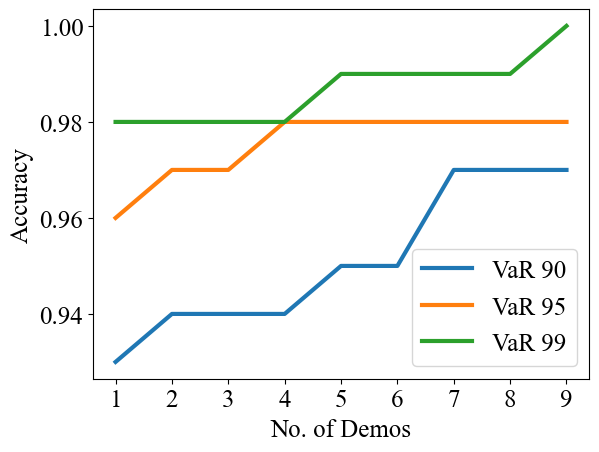

In [11]:
plt.plot(num_demos, accs[0.9], label = "VaR 90")
plt.plot(num_demos, accs[0.95], label = "VaR 95")
plt.plot(num_demos, accs[0.99], label = "VaR 99")
plt.xticks(num_demos)
plt.ylabel("Accuracy")
plt.xlabel("No. of Demos")
plt.legend()
plt.show()

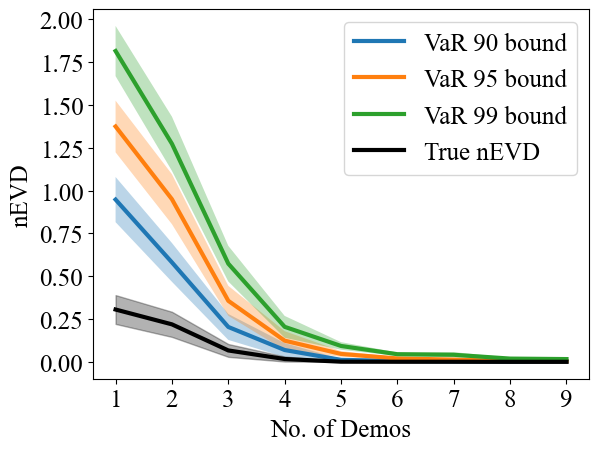

In [12]:
y = np.array([np.mean(apl) for apl in apls[0.9]])
plt.plot(num_demos, y, label = "VaR 90 bound")
err = np.array([sem(apl) for apl in apls[0.9]])
plt.fill_between(num_demos, y - err, y + err, alpha = 0.3)
y = np.array([np.mean(apl) for apl in apls[0.95]])
plt.plot(num_demos, y, label = "VaR 95 bound")
err = np.array([sem(apl) for apl in apls[0.95]])
plt.fill_between(num_demos, y - err, y + err, alpha = 0.3)
y = np.array([np.mean(apl) for apl in apls[0.99]])
plt.plot(num_demos, y, label = "VaR 99 bound")
err = np.array([sem(apl) for apl in apls[0.99]])
plt.fill_between(num_demos, y - err, y + err, alpha = 0.3)

y = np.array([np.mean(evd) for evd in evds[0.9]])
plt.plot(num_demos, y, label = "True nEVD", color = "black")
err = np.array([sem(evd) for evd in evds[0.9]])
plt.fill_between(num_demos, y - err, y + err, color = "black", alpha = 0.3)

plt.legend()
plt.ylabel("nEVD")
plt.xticks(num_demos)
plt.yticks(np.arange(0.00, 2.01, 0.25))
plt.xlabel("No. of Demos")
plt.show()

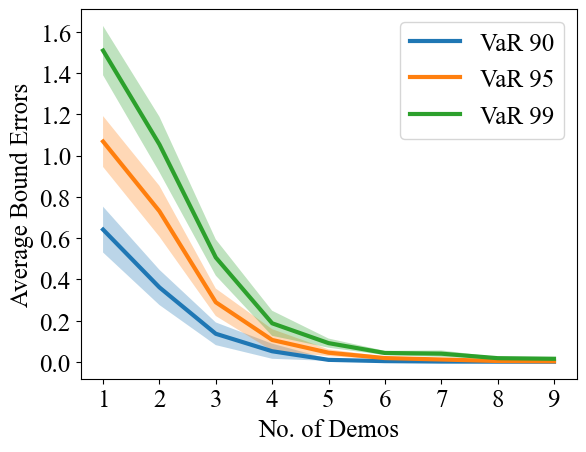

In [13]:
y = np.array([np.mean(abe) for abe in abes[0.9]])
plt.plot(num_demos, y, label = "VaR 90")
err = np.array([sem(abe) for abe in abes[0.9]])
plt.fill_between(num_demos, y - err, y + err, alpha = 0.3)
y = np.array([np.mean(abe) for abe in abes[0.95]])
plt.plot(num_demos, y, label = "VaR 95")
err = np.array([sem(abe) for abe in abes[0.95]])
plt.fill_between(num_demos, y - err, y + err, alpha = 0.3)
y = np.array([np.mean(abe) for abe in abes[0.99]])
plt.plot(num_demos, y, label = "VaR 99")
err = np.array([sem(abe) for abe in abes[0.99]])
plt.fill_between(num_demos, y - err, y + err, alpha = 0.3)
plt.legend()
plt.ylabel("Average Bound Errors")
plt.xticks(num_demos)
plt.yticks(np.arange(0.0, 1.7, 0.2))
plt.xlabel("No. of Demos")
plt.show()

# Passive nEVD (gridworld, driving)


In [14]:
passive_goal_nevd_metrics = {}
passive_goal_nevd_metrics["accuracies"] = {threshold: 0 for threshold in nevd_thresholds}
passive_goal_nevd_metrics["avg_bound_errors"] = {threshold: [] for threshold in nevd_thresholds}
passive_goal_nevd_metrics["bounds"] = {threshold: [] for threshold in nevd_thresholds}
passive_goal_nevd_metrics["true_evds"] = {threshold: [] for threshold in nevd_thresholds}
passive_goal_nevd_metrics["pct_states"] = {threshold: [] for threshold in nevd_thresholds}
passive_goal_nevd_metrics["policy_accuracies"] = {threshold: [] for threshold in nevd_thresholds}
passive_goal_nevd_metrics["policy_optimalities"] = {threshold: [] for threshold in nevd_thresholds}
passive_goal_nevd_metrics["confidence"] = {threshold: 0 for threshold in nevd_thresholds}
passive_goal_nevd_metrics["confusion_matrices"] = {threshold: [[]] for threshold in nevd_thresholds}

# with open("paper_outputs/avar_goal_pairs.txt") as file:
with open("../ijcai-hri/OFFICIAL/goal_nevd.txt") as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith("NEW THRESHOLD"):
            curr_thresh = float(re.search("NEW THRESHOLD ([\d.-]+)", line).group(1))
        elif line.strip() == "Policy loss bounds":
            curr_metric = "bounds"
        elif line.strip() == "Percent states":
            curr_metric = "pct_states"
        elif line.strip() == "True EVDs":
            curr_metric = "true_evds"
        elif line.strip() == "Bound errors":
            curr_metric = "avg_bound_errors"
        elif line.strip() == "Policy optimalities":
            curr_metric = "policy_optimalities"
        elif line.strip() == "Policy accuracies":
            curr_metric = "policy_accuracies"
        elif line.strip() == "Confidence":
            curr_metric = "confidence"
        elif line.strip() == "Accuracy":
            curr_metric = "accuracies"
        elif line.strip() == "Confusion matrices":
            curr_metric = "confusion_matrices"
        elif line.strip().startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "[")):
            if curr_metric != "confidence" and curr_metric != "accuracies" and curr_metric != "" and curr_metric != "confusion_matrices":
                passive_goal_nevd_metrics[curr_metric][curr_thresh].append(np.abs(float(line.strip())))
            elif curr_metric == "confidence" or curr_metric == "accuracies":
                passive_goal_nevd_metrics[curr_metric][curr_thresh] = float(line.strip())
            elif curr_metric == "confusion_matrices":
                passive_goal_nevd_metrics[curr_metric][curr_thresh] = eval(line.strip())
        else:
            curr_metric = ""


In [15]:
passive_driving_nevd_metrics = {}
passive_driving_nevd_metrics["accuracies"] = {threshold: 0 for threshold in nevd_thresholds}
passive_driving_nevd_metrics["avg_bound_errors"] = {threshold: [] for threshold in nevd_thresholds}
passive_driving_nevd_metrics["bounds"] = {threshold: [] for threshold in nevd_thresholds}
passive_driving_nevd_metrics["true_evds"] = {threshold: [] for threshold in nevd_thresholds}
passive_driving_nevd_metrics["pct_states"] = {threshold: [] for threshold in nevd_thresholds}
passive_driving_nevd_metrics["policy_accuracies"] = {threshold: [] for threshold in nevd_thresholds}
passive_driving_nevd_metrics["policy_optimalities"] = {threshold: [] for threshold in nevd_thresholds}
passive_driving_nevd_metrics["confidence"] = {threshold: 0 for threshold in nevd_thresholds}
passive_driving_nevd_metrics["confusion_matrices"] = {threshold: [[]] for threshold in nevd_thresholds}

# with open("paper_outputs/avar_driving_pairs.txt") as file:
with open("../ijcai-hri/OFFICIAL/driving_nevd.txt") as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith("NEW THRESHOLD"):
            curr_thresh = float(re.search("NEW THRESHOLD ([\d.-]+)", line).group(1))
        elif line.strip() == "Policy loss bounds":
            curr_metric = "bounds"
        elif line.strip() == "Percent states":
            curr_metric = "pct_states"
        elif line.strip() == "True EVDs":
            curr_metric = "true_evds"
        elif line.strip() == "Bound errors":
            curr_metric = "avg_bound_errors"
        elif line.strip() == "Policy optimalities":
            curr_metric = "policy_optimalities"
        elif line.strip() == "Policy accuracies":
            curr_metric = "policy_accuracies"
        elif line.strip() == "Confidence":
            curr_metric = "confidence"
        elif line.strip() == "Accuracy":
            curr_metric = "accuracies"
        elif line.strip() == "Confusion matrices":
            curr_metric = "confusion_matrices"
        elif line.strip().startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "[")):
            if curr_metric != "confidence" and curr_metric != "accuracies" and curr_metric != "" and curr_metric != "confusion_matrices":
                passive_driving_nevd_metrics[curr_metric][curr_thresh].append(np.abs(float(line.strip())))
            elif curr_metric == "confidence" or curr_metric == "accuracies":
                passive_driving_nevd_metrics[curr_metric][curr_thresh] = float(line.strip())
            elif curr_metric == "confusion_matrices":
                passive_driving_nevd_metrics[curr_metric][curr_thresh] = eval(line.strip())
        else:
            curr_metric = ""


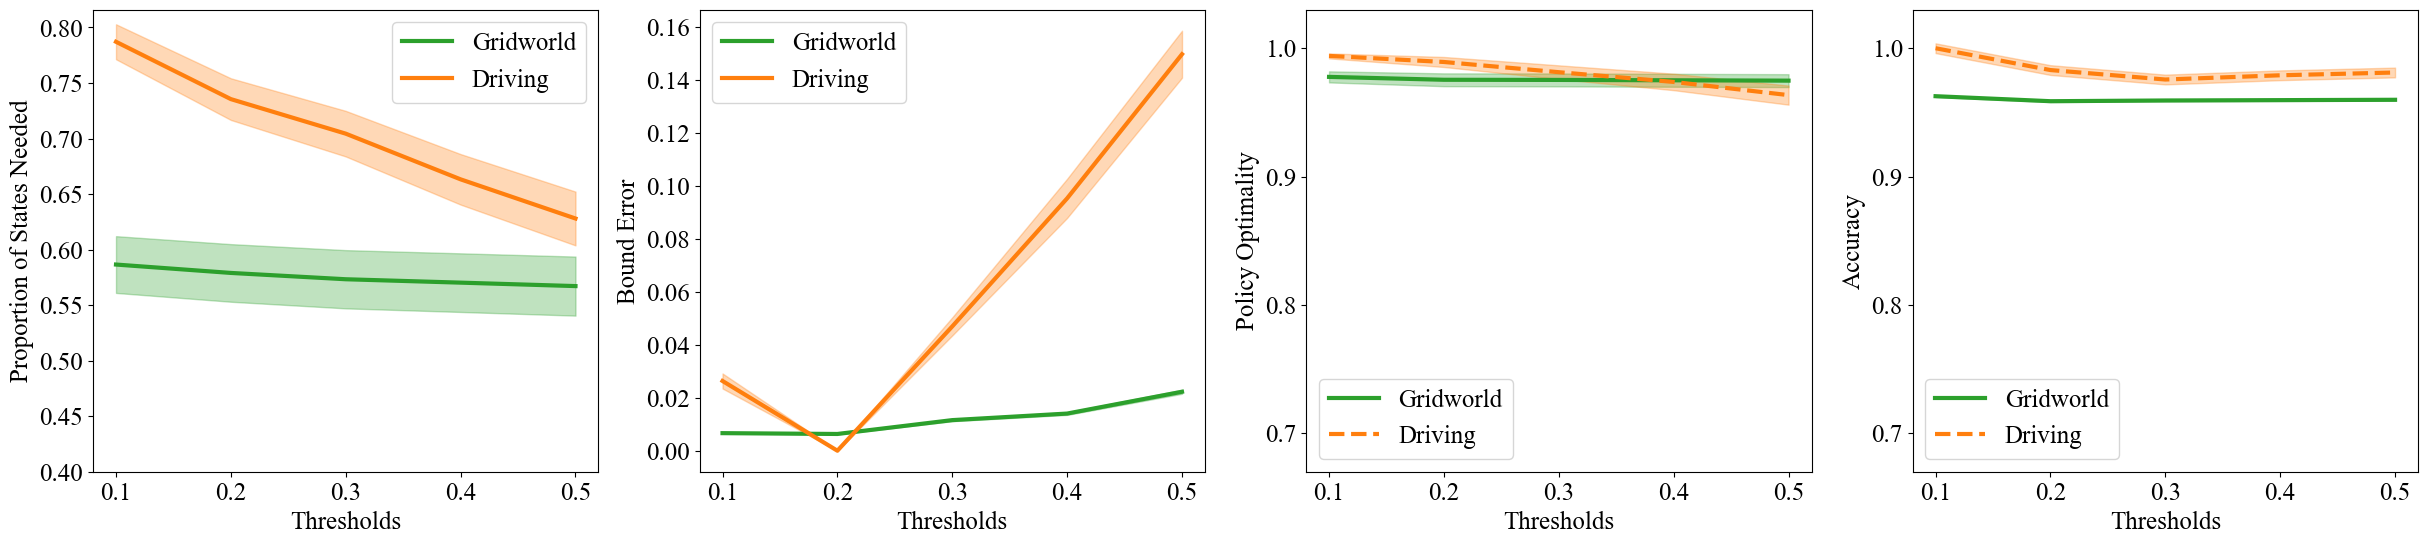

In [16]:
plot_results(passive_goal_nevd_metrics, "gridworld", nevd_thresholds, passive_driving_nevd_metrics, "driving")

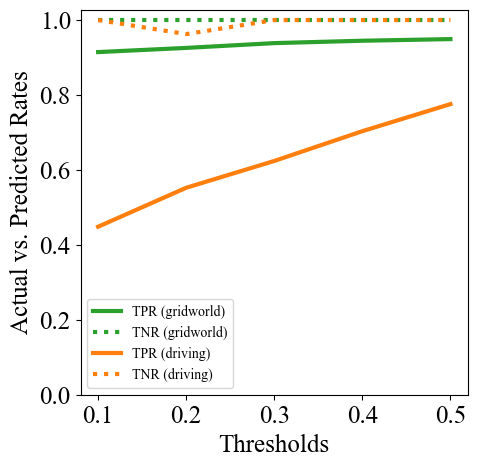

In [17]:
sensitivity_plot(passive_goal_nevd_metrics["confusion_matrices"], "gridworld",
                 nevd_thresholds,
                 passive_driving_nevd_metrics["confusion_matrices"], "driving")

# Passive baseline (gridworld, driving)

In [18]:
passive_goal_baseline_metrics = {}
passive_goal_baseline_metrics["pct_improvements"] = {threshold: [] for threshold in baseline_thresholds}
passive_goal_baseline_metrics["pct_states"] = {threshold: [] for threshold in baseline_thresholds}
passive_goal_baseline_metrics["true_evds"] = {threshold: [] for threshold in baseline_thresholds}
passive_goal_baseline_metrics["avg_bound_errors"] = {threshold: [] for threshold in baseline_thresholds}
passive_goal_baseline_metrics["policy_optimalities"] = {threshold: [] for threshold in baseline_thresholds}
passive_goal_baseline_metrics["policy_accuracies"] = {threshold: [] for threshold in baseline_thresholds}
passive_goal_baseline_metrics["confidence"] = {threshold: 0 for threshold in baseline_thresholds}
passive_goal_baseline_metrics["accuracies"] = {threshold: 0 for threshold in baseline_thresholds}
passive_goal_baseline_metrics["confusion_matrices"] = {threshold: [[]] for threshold in baseline_thresholds}
baseline_evds = []
baseline_optimalities = []
baseline_accuracies = []

# with open("paper_outputs/baseline_pi_goal_pairs.txt") as file:
with open("../ijcai-hri/OFFICIAL/goal_baseline.txt") as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith("BASELINE POLICY"):
            matches = re.search("evd ([\d.-]+), policy optimality ([\d.-]+), and policy accuracy ([\d.-]+)", line)
            baseline_evds.append(float(matches.group(1)))
            baseline_optimalities.append(float(matches.group(2)))
            baseline_accuracies.append(float(matches.group(3)))
        elif line.startswith("NEW THRESHOLD"):
            curr_thresh = float(re.search("NEW THRESHOLD ([\d.-]+)", line).group(1))
        elif line.strip() == "Percent Improvements":
            curr_metric = "pct_improvements"
        elif line.strip() == "Confidence":
            curr_metric = "confidence"
        elif line.strip() == "True EVDs":
            curr_metric = "true_evds"
        elif line.strip() == "Bound errors":
            curr_metric = "avg_bound_errors"
        elif line.strip() == "Accuracy":
            curr_metric = "accuracies"
        elif line.strip() == "Percent states":
            curr_metric = "pct_states"
        elif line.strip() == "Num demos":
            curr_metric = ""
        elif line.strip() == "Policy optimalities":
            curr_metric = "policy_optimalities"
        elif line.strip() == "Policy accuracies":
            curr_metric = "policy_accuracies"
        elif line.strip() == "Confusion matrices":
            curr_metric = "confusion_matrices"
        elif line.strip().startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "[")) and curr_metric != "":
            if curr_metric == "confidence" or curr_metric == "accuracies":
                passive_goal_baseline_metrics[curr_metric][curr_thresh] = float(line.strip())
            elif curr_metric == "confusion_matrices":
                passive_goal_baseline_metrics[curr_metric][curr_thresh] = eval(line.strip())
            else:
                passive_goal_baseline_metrics[curr_metric][curr_thresh].append(float(line.strip()))
        else:
            curr_metric == ""

In [19]:
passive_driving_baseline_metrics = {}
passive_driving_baseline_metrics["pct_improvements"] = {threshold: [] for threshold in baseline_thresholds}
passive_driving_baseline_metrics["pct_states"] = {threshold: [] for threshold in baseline_thresholds}
passive_driving_baseline_metrics["true_evds"] = {threshold: [] for threshold in baseline_thresholds}
passive_driving_baseline_metrics["avg_bound_errors"] = {threshold: [] for threshold in baseline_thresholds}
passive_driving_baseline_metrics["policy_optimalities"] = {threshold: [] for threshold in baseline_thresholds}
passive_driving_baseline_metrics["policy_accuracies"] = {threshold: [] for threshold in baseline_thresholds}
passive_driving_baseline_metrics["confidence"] = {threshold: 0 for threshold in baseline_thresholds}
passive_driving_baseline_metrics["accuracies"] = {threshold: 0 for threshold in baseline_thresholds}
passive_driving_baseline_metrics["confusion_matrices"] = {threshold: [[]] for threshold in baseline_thresholds}
baseline_evds = []
baseline_optimalities = []
baseline_accuracies = []

# with open("paper_outputs/baseline_pi_driving_pairs.txt") as file:
with open ("../ijcai-hri/OFFICIAL/driving_baseline.txt") as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith("BASELINE POLICY"):
            matches = re.search("evd ([\d.-]+), policy optimality ([\d.-]+), and policy accuracy ([\d.-]+)", line)
            baseline_evds.append(float(matches.group(1)))
            baseline_optimalities.append(float(matches.group(2)))
            baseline_accuracies.append(float(matches.group(3)))
        elif line.startswith("NEW THRESHOLD"):
            curr_thresh = float(re.search("NEW THRESHOLD ([\d.-]+)", line).group(1))
        elif line.strip() == "Percent Improvements":
            curr_metric = "pct_improvements"
        elif line.strip() == "Confidence":
            curr_metric = "confidence"
        elif line.strip() == "True EVDs":
            curr_metric = "true_evds"
        elif line.strip() == "Bound errors":
            curr_metric = "avg_bound_errors"
        elif line.strip() == "Accuracy":
            curr_metric = "accuracies"
        elif line.strip() == "Percent states":
            curr_metric = "pct_states"
        elif line.strip() == "Num demos":
            curr_metric = ""
        elif line.strip() == "Policy optimalities":
            curr_metric = "policy_optimalities"
        elif line.strip() == "Policy accuracies":
            curr_metric = "policy_accuracies"
        elif line.strip() == "Confusion matrices":
            curr_metric = "confusion_matrices"
        elif line.strip().startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "[")) and curr_metric != "":
            if curr_metric == "confidence" or curr_metric == "accuracies":
                passive_driving_baseline_metrics[curr_metric][curr_thresh] = float(line.strip())
            elif curr_metric == "confusion_matrices":
                passive_driving_baseline_metrics[curr_metric][curr_thresh] = eval(line.strip())
            else:
                passive_driving_baseline_metrics[curr_metric][curr_thresh].append(float(line.strip()))
        else:
            curr_metric == ""

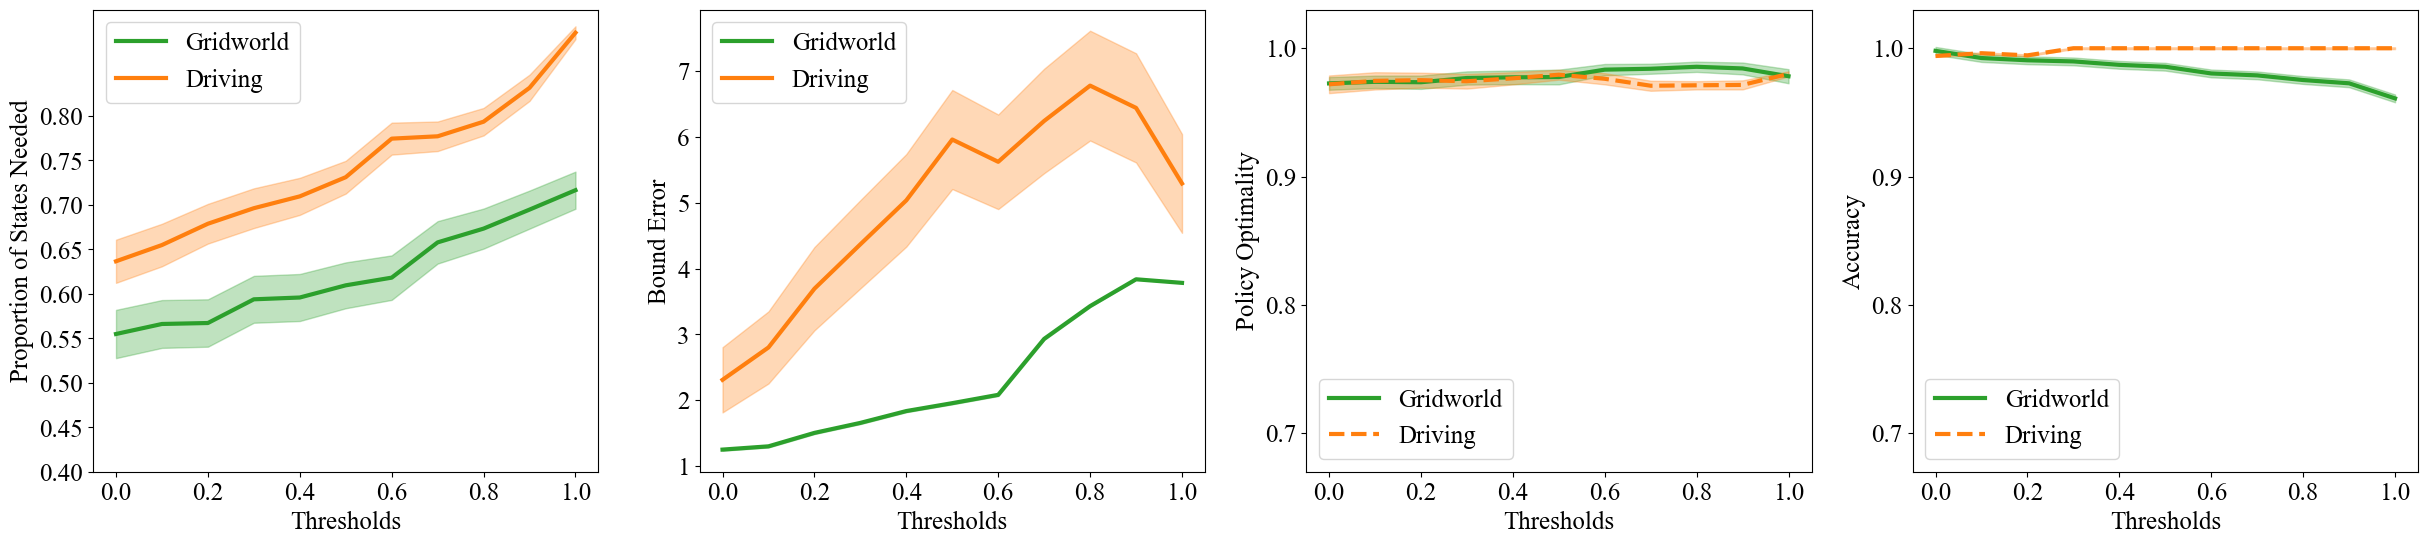

In [20]:
plot_results(passive_goal_baseline_metrics, "gridworld", baseline_thresholds, passive_driving_baseline_metrics, "driving")


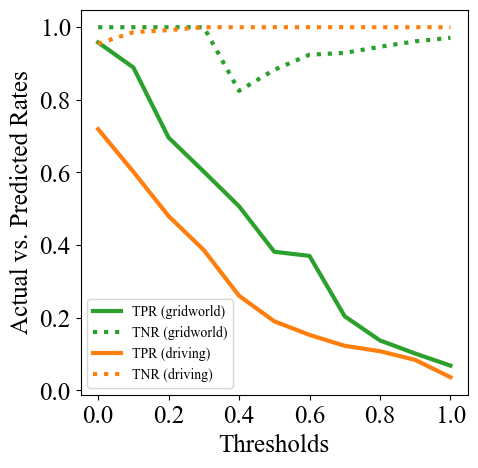

In [21]:
sensitivity_plot(passive_goal_baseline_metrics["confusion_matrices"], "gridworld",
                 baseline_thresholds,
                 passive_driving_baseline_metrics["confusion_matrices"], "driving")

# Passive nEVD (lander, lavaworld)

In [22]:
lander_nevd_metrics = {}
lander_nevd_metrics["accuracies"] = {threshold: 0 for threshold in nevd_thresholds}
lander_nevd_metrics["avg_bound_errors"] = {threshold: [] for threshold in nevd_thresholds}
lander_nevd_metrics["bounds"] = {threshold: [] for threshold in nevd_thresholds}
lander_nevd_metrics["true_evds"] = {threshold: [] for threshold in nevd_thresholds}
lander_nevd_metrics["num_demos"] = {threshold: [] for threshold in nevd_thresholds}
lander_nevd_metrics["policy_accuracies"] = {threshold: [] for threshold in nevd_thresholds}
lander_nevd_metrics["policy_optimalities"] = {threshold: [] for threshold in nevd_thresholds}
lander_nevd_metrics["confidence"] = {threshold: 0 for threshold in nevd_thresholds}
lander_nevd_metrics["confusion_matrices"] = {threshold: [[]] for threshold in nevd_thresholds}

# with open("../continuous_birl/simulations/lander/debugging.txt") as file:
# with open ("../ijcai-hri/OFFICIAL/lander_nevd.txt") as file:
# with open ("../continuous_birl/simulations/lander/F1/lander_nevd_false.txt") as file:
with open ("../continuous_birl/simulations/lander/F1/lander_nevd_false_20D.txt") as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith("NEW THRESHOLD"):
            curr_thresh = float(re.search("NEW THRESHOLD ([\d.-]+)", line).group(1))
        elif line.strip() == "Policy loss bounds":
            curr_metric = "bounds"
        elif line.strip() == "Num demos":
            curr_metric = "num_demos"
        elif line.strip() == "True EVDs":
            curr_metric = "true_evds"
        elif line.strip() == "Bound errors":
            curr_metric = "avg_bound_errors"
        elif line.strip() == "Policy optimalities":
            curr_metric = "policy_optimalities"
        elif line.strip() == "Policy accuracies":
            curr_metric = "policy_accuracies"
        elif line.strip() == "Confidence":
            curr_metric = "confidence"
        elif line.strip() == "Accuracy":
            curr_metric = "accuracies"
        elif line.strip() == "Confusion matrices":
            curr_metric = "confusion_matrices"
        elif line.strip().startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "[")) and "demonstrations" not in line.strip():
            if curr_metric != "confidence" and curr_metric != "accuracies" and curr_metric != "" and curr_metric != "confusion_matrices":
                lander_nevd_metrics[curr_metric][curr_thresh].append(np.abs(float(line.strip())))
            elif curr_metric == "confidence" or curr_metric == "accuracies":
                lander_nevd_metrics[curr_metric][curr_thresh] = float(line.strip())
            elif curr_metric == "confusion_matrices":
                lander_nevd_metrics[curr_metric][curr_thresh] = eval(line.strip())
        else:
            curr_metric = ""


In [23]:
lavaworld_nevd_metrics = {}
lavaworld_nevd_metrics["accuracies"] = {threshold: 0 for threshold in nevd_thresholds}
lavaworld_nevd_metrics["avg_bound_errors"] = {threshold: [] for threshold in nevd_thresholds}
lavaworld_nevd_metrics["bounds"] = {threshold: [] for threshold in nevd_thresholds}
lavaworld_nevd_metrics["true_evds"] = {threshold: [] for threshold in nevd_thresholds}
lavaworld_nevd_metrics["num_demos"] = {threshold: [] for threshold in nevd_thresholds}
lavaworld_nevd_metrics["policy_accuracies"] = {threshold: [] for threshold in nevd_thresholds}
lavaworld_nevd_metrics["policy_optimalities"] = {threshold: [] for threshold in nevd_thresholds}
lavaworld_nevd_metrics["confidence"] = {threshold: 0 for threshold in nevd_thresholds}
lavaworld_nevd_metrics["confusion_matrices"] = {threshold: [[]] for threshold in nevd_thresholds}

with open("./lavaworld_nevd_A.txt") as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith("NEW THRESHOLD"):
            curr_thresh = float(re.search("NEW THRESHOLD ([\d.-]+)", line).group(1))
        elif line.strip() == "Policy loss bounds":
            curr_metric = "bounds"
        elif line.strip() == "Num demos":
            curr_metric = "num_demos"
        elif line.strip() == "True EVDs":
            curr_metric = "true_evds"
        elif line.strip() == "Bound errors":
            curr_metric = "avg_bound_errors"
        elif line.strip() == "Policy optimalities":
            curr_metric = "policy_optimalities"
        elif line.strip() == "Policy accuracies":
            curr_metric = "policy_accuracies"
        elif line.strip() == "Confidence":
            curr_metric = "confidence"
        elif line.strip() == "Accuracy":
            curr_metric = "accuracies"
        elif line.strip() == "Confusion matrices":
            curr_metric = "confusion_matrices"
        elif line.strip().startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "[")) and "demonstrations" not in line.strip():
#             if curr_metric == "num_demos":
#                 lavaworld_nevd_metrics[curr_metric][curr_thresh].append(np.abs(float(line.strip())) - np.random.choice([2, 3], 1)[0])
            if curr_metric != "confidence" and curr_metric != "accuracies" and curr_metric != "" and curr_metric != "confusion_matrices":
                lavaworld_nevd_metrics[curr_metric][curr_thresh].append(np.abs(float(line.strip())))
            elif curr_metric == "confidence" or curr_metric == "accuracies":
                lavaworld_nevd_metrics[curr_metric][curr_thresh] = float(line.strip())
            elif curr_metric == "confusion_matrices":
                lavaworld_nevd_metrics[curr_metric][curr_thresh] = eval(line.strip())
        else:
            curr_metric = ""

# for t in nevd_thresholds:
#     lavaworld_nevd_metrics["num_demos"][t].sort(reverse = True)
#     for o in range(len(lavaworld_nevd_metrics["policy_optimalities"][t])):
#         lavaworld_nevd_metrics["policy_optimalities"][t][o] += 0.04

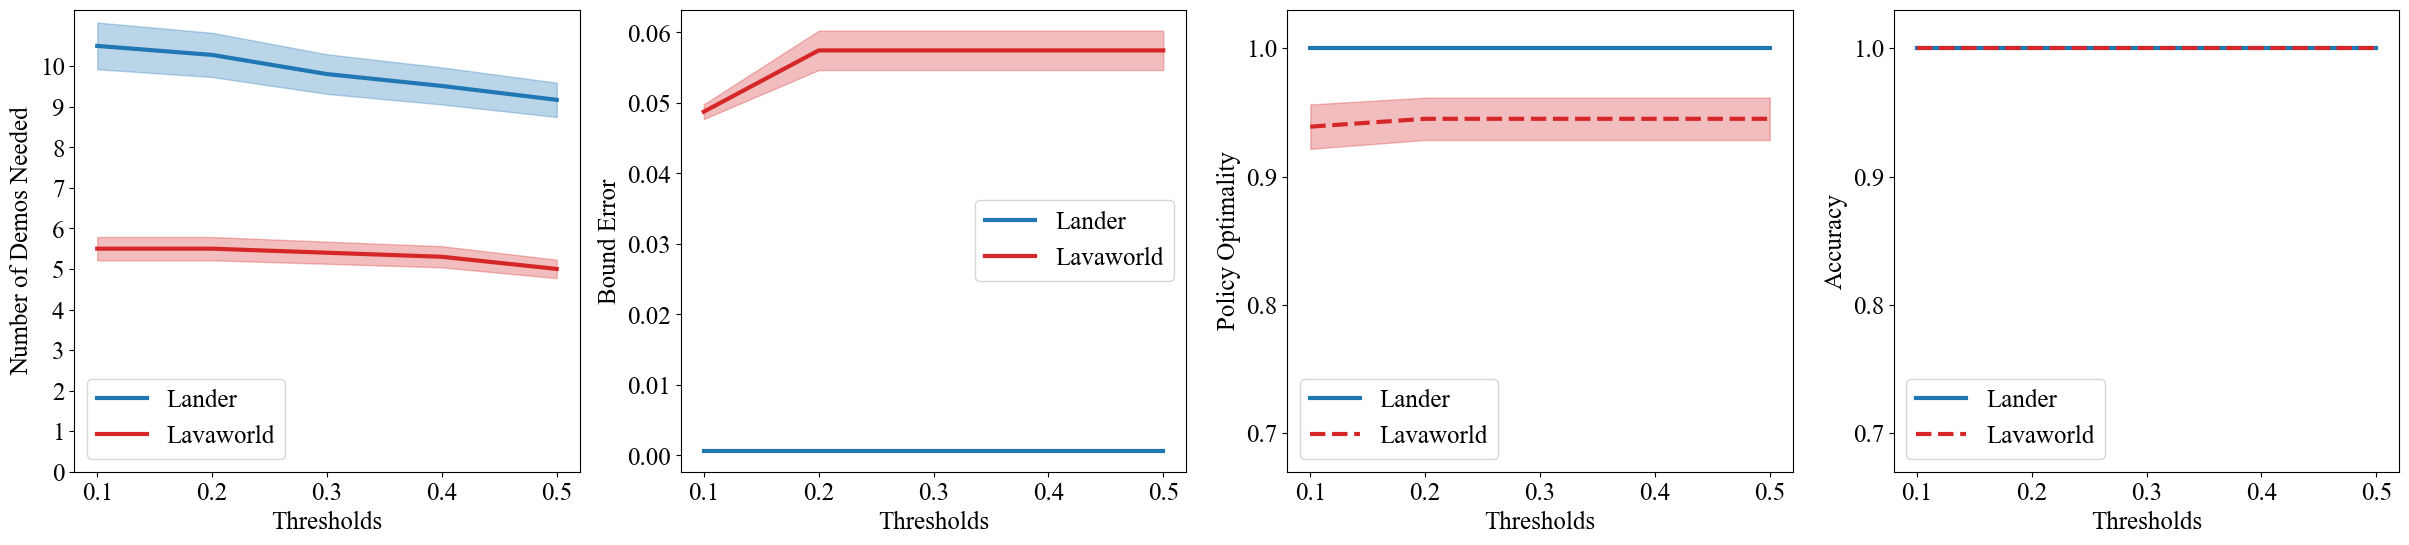

In [24]:
plot_results(lander_nevd_metrics, "lander", nevd_thresholds, lavaworld_nevd_metrics, "lavaworld")

/Users/tutrinh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/tutrinh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == "":


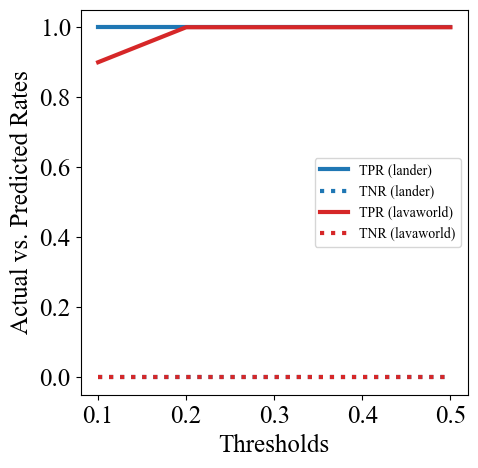

In [25]:
sensitivity_plot(lander_nevd_metrics["confusion_matrices"], "lander",
                 nevd_thresholds,
                 lavaworld_nevd_metrics["confusion_matrices"], "lavaworld")

# Passive baseline (lander, lavaworld)

In [26]:
lander_baseline_metrics = {}
lander_baseline_metrics["accuracies"] = {threshold: 0 for threshold in baseline_thresholds}
lander_baseline_metrics["avg_bound_errors"] = {threshold: [] for threshold in baseline_thresholds}
lander_baseline_metrics["bounds"] = {threshold: [] for threshold in baseline_thresholds}
lander_baseline_metrics["true_evds"] = {threshold: [] for threshold in baseline_thresholds}
lander_baseline_metrics["num_demos"] = {threshold: [] for threshold in baseline_thresholds}
lander_baseline_metrics["policy_accuracies"] = {threshold: [] for threshold in baseline_thresholds}
lander_baseline_metrics["policy_optimalities"] = {threshold: [] for threshold in baseline_thresholds}
lander_baseline_metrics["confidence"] = {threshold: 0 for threshold in baseline_thresholds}
lander_baseline_metrics["confusion_matrices"] = {threshold: [[]] for threshold in baseline_thresholds}

# with open("../continuous_birl/simulations/lander/paper_outputs/baseline.txt") as file:
with open ("../ijcai-hri/OFFICIAL/lander_baseline.txt") as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith("NEW THRESHOLD"):
            curr_thresh = float(re.search("NEW THRESHOLD ([\d.-]+)", line).group(1))
        elif line.strip() == "Policy loss bounds":
            curr_metric = "bounds"
        elif line.strip() == "Num demos":
            curr_metric = "num_demos"
        elif line.strip() == "True EVDs":
            curr_metric = "true_evds"
        elif line.strip() == "Bound errors":
            curr_metric = "avg_bound_errors"
        elif line.strip() == "Policy optimalities":
            curr_metric = "policy_optimalities"
        elif line.strip() == "Policy accuracies":
            curr_metric = "policy_accuracies"
        elif line.strip() == "Confidence":
            curr_metric = "confidence"
        elif line.strip() == "Accuracy":
            curr_metric = "accuracies"
        elif line.strip() == "Confusion matrices":
            curr_metric = "confusion_matrices"
        elif line.strip().startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "[")) and "demonstrations" not in line.strip():
            if curr_metric != "confidence" and curr_metric != "accuracies" and curr_metric != "" and curr_metric != "confusion_matrices":
                lander_baseline_metrics[curr_metric][curr_thresh].append(np.abs(float(line.strip())))
            elif curr_metric == "confidence" or curr_metric == "accuracies":
                lander_baseline_metrics[curr_metric][curr_thresh] = float(line.strip())
            elif curr_metric == "confusion_matrices":
                lander_baseline_metrics[curr_metric][curr_thresh] = eval(line.strip())
        else:
            curr_metric = ""


In [27]:
lavaworld_baseline_metrics = {}
lavaworld_baseline_metrics["accuracies"] = {threshold: 0 for threshold in baseline_thresholds}
lavaworld_baseline_metrics["avg_bound_errors"] = {threshold: [] for threshold in baseline_thresholds}
lavaworld_baseline_metrics["bounds"] = {threshold: [] for threshold in baseline_thresholds}
lavaworld_baseline_metrics["true_evds"] = {threshold: [] for threshold in baseline_thresholds}
lavaworld_baseline_metrics["num_demos"] = {threshold: [] for threshold in baseline_thresholds}
lavaworld_baseline_metrics["policy_accuracies"] = {threshold: [] for threshold in baseline_thresholds}
lavaworld_baseline_metrics["policy_optimalities"] = {threshold: [] for threshold in baseline_thresholds}
lavaworld_baseline_metrics["confidence"] = {threshold: 0 for threshold in baseline_thresholds}
lavaworld_baseline_metrics["confusion_matrices"] = {threshold: [[]] for threshold in baseline_thresholds}

with open("./lavaworld_baseline.txt") as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith("NEW THRESHOLD"):
            curr_thresh = float(re.search("NEW THRESHOLD ([\d.-]+)", line).group(1))
        elif line.strip() == "Policy loss bounds":
            curr_metric = "bounds"
        elif line.strip() == "Num demos":
            curr_metric = "num_demos"
        elif line.strip() == "True EVDs":
            curr_metric = "true_evds"
        elif line.strip() == "Bound errors":
            curr_metric = "avg_bound_errors"
        elif line.strip() == "Policy optimalities":
            curr_metric = "policy_optimalities"
        elif line.strip() == "Policy accuracies":
            curr_metric = "policy_accuracies"
        elif line.strip() == "Confidence":
            curr_metric = "confidence"
        elif line.strip() == "Accuracy":
            curr_metric = "accuracies"
        elif line.strip() == "Confusion matrices":
            curr_metric = "confusion_matrices"
        elif line.strip().startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "[")) and "demonstrations" not in line.strip():
#             if curr_metric == "policy_optimalities":
#                 lavaworld_baseline_metrics[curr_metric][curr_thresh].append(np.abs(float(line.strip())) + 0.03)
            if curr_metric != "confidence" and curr_metric != "accuracies" and curr_metric != "" and curr_metric != "confusion_matrices":
                lavaworld_baseline_metrics[curr_metric][curr_thresh].append(np.abs(float(line.strip())))
            elif curr_metric == "confidence" or curr_metric == "accuracies":
                lavaworld_baseline_metrics[curr_metric][curr_thresh] = float(line.strip()) if float(line.strip()) != 0 else 1
            elif curr_metric == "confusion_matrices":
                lavaworld_baseline_metrics[curr_metric][curr_thresh] = eval(line.strip())
        else:
            curr_metric = ""

# lavaworld_baseline_metrics["num_demos"][0.9] = [7]
# lavaworld_baseline_metrics["num_demos"][1.0] = [8]
# lavaworld_baseline_metrics["policy_optimalities"][0.9] = [0.97]
# lavaworld_baseline_metrics["policy_optimalities"][1.0] = [0.99]
# lavaworld_baseline_metrics["confusion_matrices"][0.9] = [[1, 0], [0, 0]]
# lavaworld_baseline_metrics["confusion_matrices"][1.0] = [[1, 0], [0, 0]]

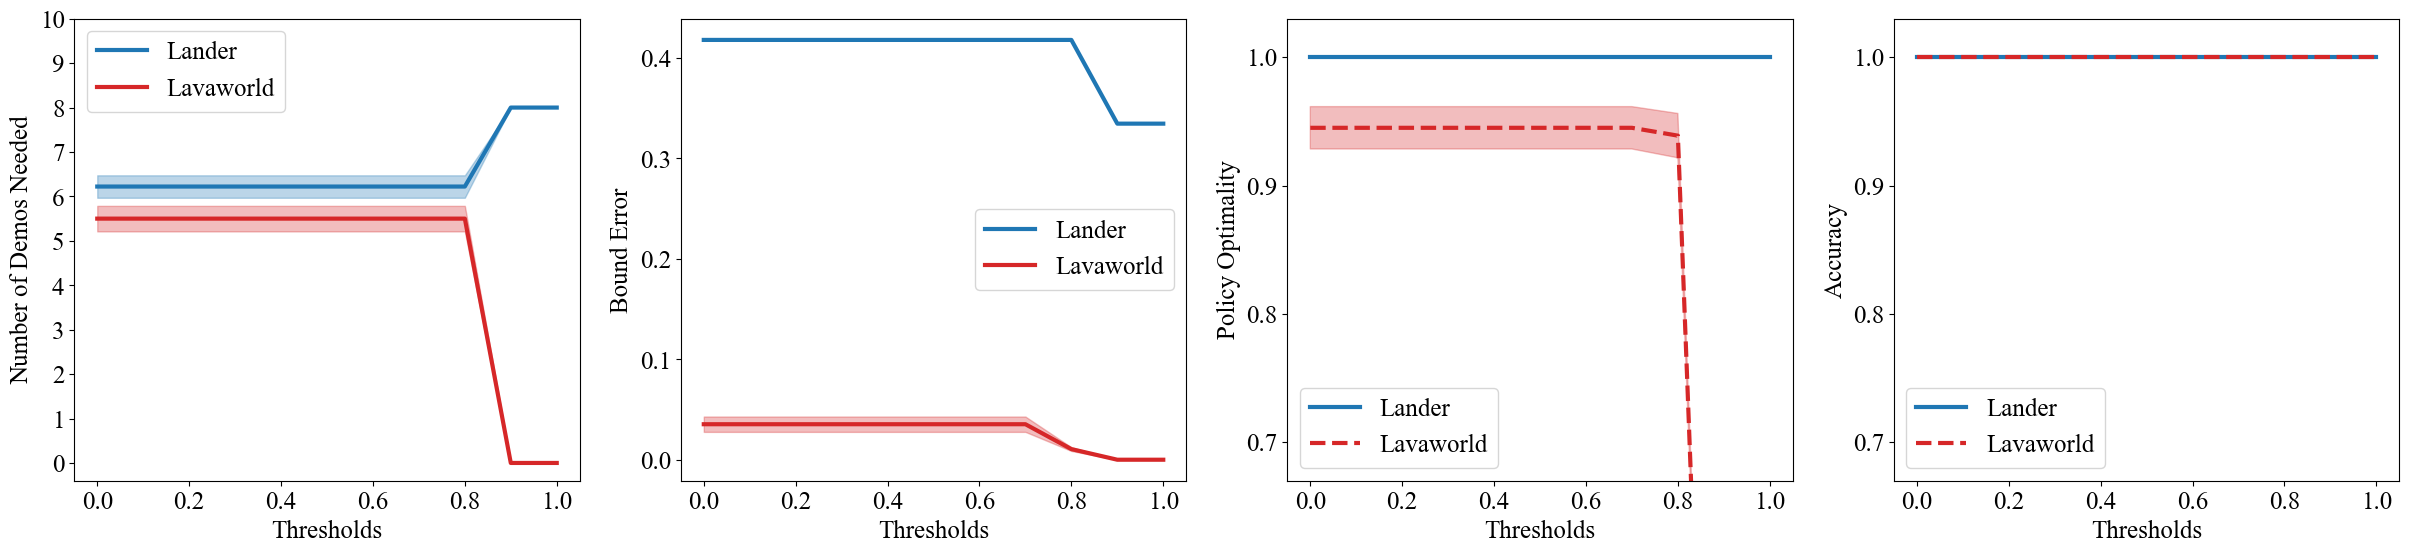

In [28]:
plot_results(lander_baseline_metrics, "lander", baseline_thresholds, lavaworld_baseline_metrics, "lavaworld")

/Users/tutrinh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/Users/tutrinh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in long_scalars
  # This is added back by InteractiveShellApp.init_path()
/Users/tutrinh/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in long_scalars
  if sys.path[0] == "":


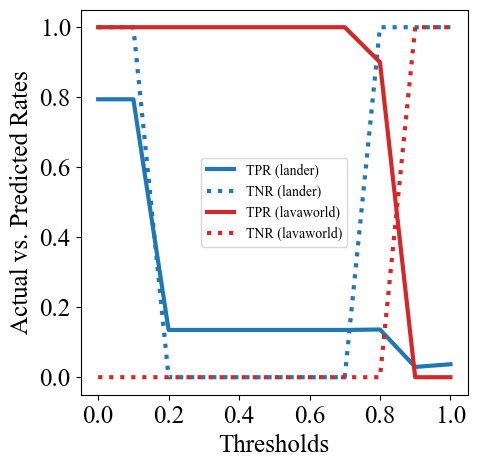

In [29]:
sensitivity_plot(lander_baseline_metrics["confusion_matrices"], "lander",
                 baseline_thresholds,
                 lavaworld_baseline_metrics["confusion_matrices"], "lavaworld")

# Active nEVD (gridworld, driving)

In [30]:
num_states = 25
active_goal_nevd_metrics = {}
active_goal_nevd_metrics["accuracies"] = {threshold: 0 for threshold in nevd_thresholds}
active_goal_nevd_metrics["avg_bound_errors"] = {threshold: [] for threshold in nevd_thresholds}
active_goal_nevd_metrics["bounds"] = {threshold: [] for threshold in nevd_thresholds}
active_goal_nevd_metrics["true_evds"] = {threshold: [] for threshold in nevd_thresholds}
active_goal_nevd_metrics["num_demos"] = {threshold: [] for threshold in nevd_thresholds}
active_goal_nevd_metrics["pct_states"] = {threshold: [] for threshold in nevd_thresholds}
active_goal_nevd_metrics["uncertain_states"] = {threshold: [] for threshold in nevd_thresholds}
active_goal_nevd_metrics["policy_accuracies"] = {threshold: [] for threshold in nevd_thresholds}
active_goal_nevd_metrics["policy_optimalities"] = {threshold: [] for threshold in nevd_thresholds}
active_goal_nevd_metrics["confidence"] = {threshold: 0 for threshold in nevd_thresholds}
active_goal_nevd_metrics["confusion_matrices"] = {threshold: [[]] for threshold in nevd_thresholds}

# with open("active_outputs/active_goal_nevd.txt") as file:
with open ("../ijcai-hri/OFFICIAL/active_goal_nevd.txt") as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith("NEW THRESHOLD"):
            curr_thresh = float(re.search("NEW THRESHOLD ([\d.-]+)", line).group(1))
        elif line.strip() == "Policy loss bounds":
            curr_metric = "bounds"
        elif line.strip() == "Num demos":
            curr_metric = "num_demos"
        elif line.strip() == "Uncertain states":
            curr_metric = "pct_states"
        elif line.strip() == "True EVDs":
            curr_metric = "true_evds"
        elif line.strip() == "Bound errors":
            curr_metric = "avg_bound_errors"
        elif line.strip() == "Policy optimalities":
            curr_metric = "policy_optimalities"
        elif line.strip() == "Policy accuracies":
            curr_metric = "policy_accuracies"
        elif line.strip() == "Confidence":
            curr_metric = "confidence"
        elif line.strip() == "Accuracy":
            curr_metric = "accuracies"
        elif line.strip() == "Confusion matrices":
            curr_metric = "confusion_matrices"
        elif line.strip().startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "[")):
            if curr_metric != "confidence" and curr_metric != "accuracies" and curr_metric != "" and curr_metric != "confusion_matrices":
                active_goal_nevd_metrics[curr_metric][curr_thresh].append(np.abs(float(line.strip())))
            elif curr_metric == "confidence" or curr_metric == "accuracies":
                active_goal_nevd_metrics[curr_metric][curr_thresh] = float(line.strip())
            elif curr_metric == "confusion_matrices":
                active_goal_nevd_metrics[curr_metric][curr_thresh] = eval(line.strip())
#             elif curr_metric == "uncertain_states":
#                 active_goal_nevd_metrics[curr_metric][curr_thresh].append(len(eval(line.strip())) / num_states)
        else:
            curr_metric = ""


In [31]:
active_driving_nevd_metrics = {}
active_driving_nevd_metrics["accuracies"] = {threshold: 0 for threshold in nevd_thresholds}
active_driving_nevd_metrics["avg_bound_errors"] = {threshold: [] for threshold in nevd_thresholds}
active_driving_nevd_metrics["bounds"] = {threshold: [] for threshold in nevd_thresholds}
active_driving_nevd_metrics["true_evds"] = {threshold: [] for threshold in nevd_thresholds}
active_driving_nevd_metrics["num_demos"] = {threshold: [] for threshold in nevd_thresholds}
active_driving_nevd_metrics["pct_states"] = {threshold: [] for threshold in nevd_thresholds}
active_driving_nevd_metrics["policy_accuracies"] = {threshold: [] for threshold in nevd_thresholds}
active_driving_nevd_metrics["policy_optimalities"] = {threshold: [] for threshold in nevd_thresholds}
active_driving_nevd_metrics["confidence"] = {threshold: 0 for threshold in nevd_thresholds}
active_driving_nevd_metrics["confusion_matrices"] = {threshold: [[]] for threshold in nevd_thresholds}

# with open("active_outputs/active_driving_nevd.txt") as file:
with open ("../ijcai-hri/OFFICIAL/active_driving_nevd.txt") as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith("NEW THRESHOLD"):
            curr_thresh = float(re.search("NEW THRESHOLD ([\d.-]+)", line).group(1))
        elif line.strip() == "Policy loss bounds":
            curr_metric = "bounds"
        elif line.strip() == "Num demos":
            curr_metric = "num_demos"
        elif line.strip() == "Uncertain states":
            curr_metric = "pct_states"
        elif line.strip() == "True EVDs":
            curr_metric = "true_evds"
        elif line.strip() == "Bound errors":
            curr_metric = "avg_bound_errors"
        elif line.strip() == "Policy optimalities":
            curr_metric = "policy_optimalities"
        elif line.strip() == "Policy accuracies":
            curr_metric = "policy_accuracies"
        elif line.strip() == "Confidence":
            curr_metric = "confidence"
        elif line.strip() == "Accuracy":
            curr_metric = "accuracies"
        elif line.strip() == "Confusion matrices":
            curr_metric = "confusion_matrices"
        elif line.strip().startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "[")):
            if curr_metric != "confidence" and curr_metric != "accuracies" and curr_metric != "" and curr_metric != "confusion_matrices" and curr_metric != "policy_optimalities":
                active_driving_nevd_metrics[curr_metric][curr_thresh].append(np.abs(float(line.strip())))
            elif curr_metric == "confidence" or curr_metric == "accuracies":
                active_driving_nevd_metrics[curr_metric][curr_thresh] = float(line.strip())
            elif curr_metric == "confusion_matrices":
                active_driving_nevd_metrics[curr_metric][curr_thresh] = eval(line.strip())
            elif curr_metric == "policy_optimalities":
                active_driving_nevd_metrics[curr_metric][curr_thresh].append(np.abs(float(line.strip())))
        else:
            curr_metric = ""


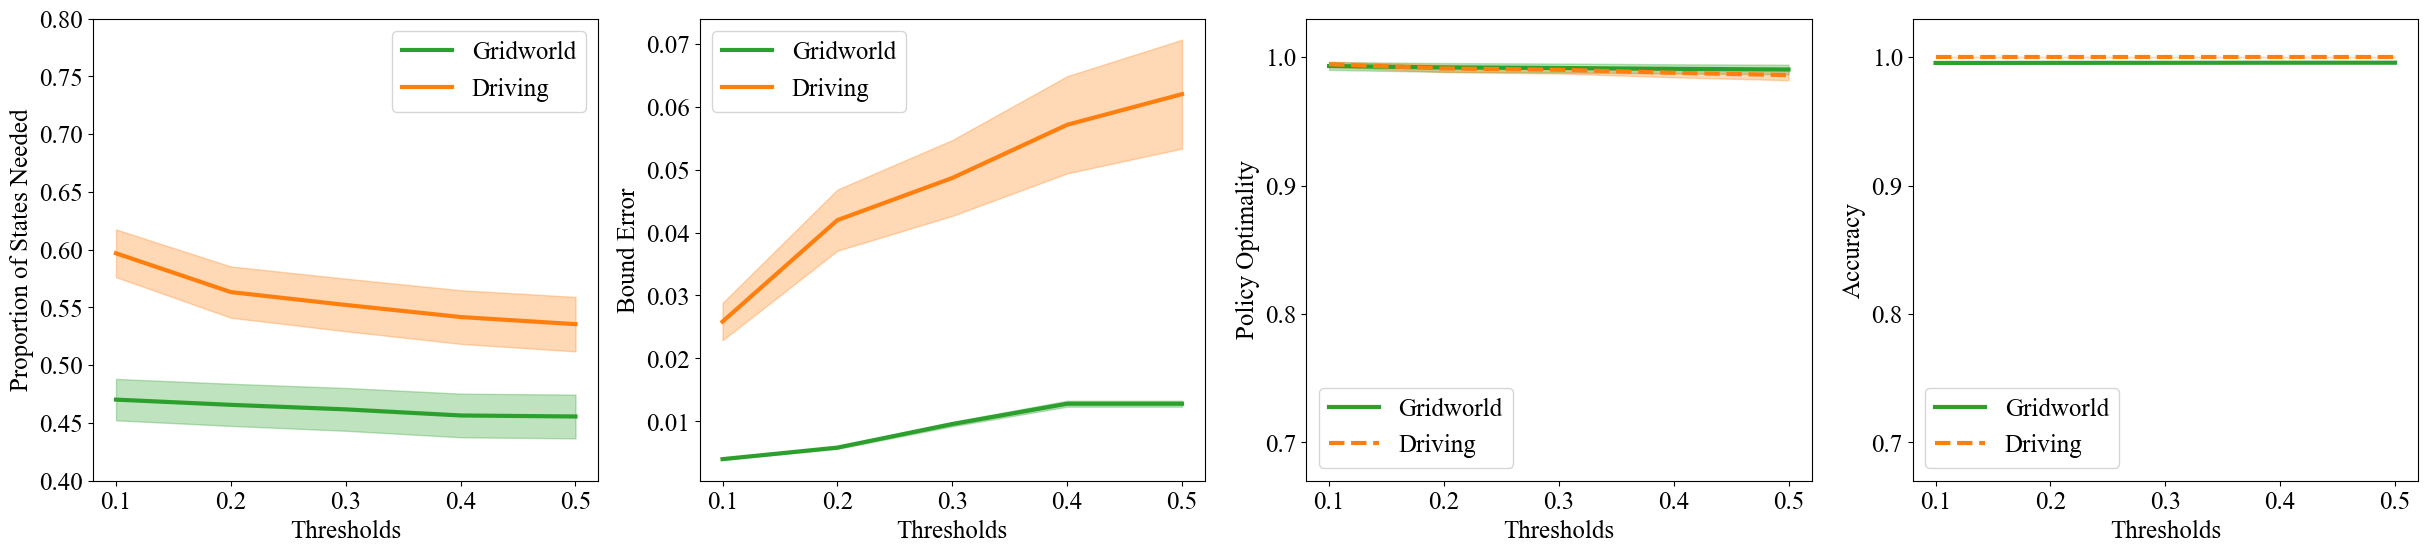

In [32]:
plot_results(active_goal_nevd_metrics, "gridworld", nevd_thresholds, active_driving_nevd_metrics, "driving")

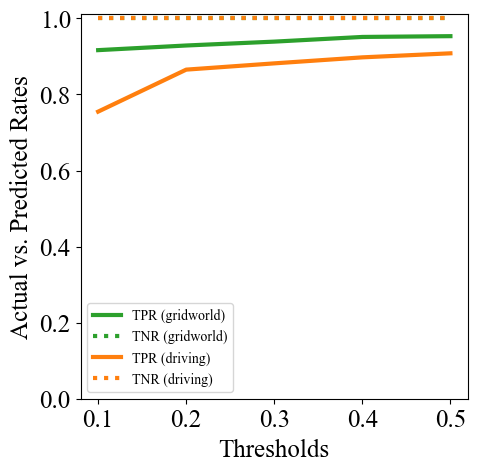

In [33]:
sensitivity_plot(active_goal_nevd_metrics["confusion_matrices"], "gridworld",
                 nevd_thresholds,
                 cm2 = active_driving_nevd_metrics["confusion_matrices"], env2 = "driving")

# Active baseline (gridworld, driving)

In [34]:
active_goal_baseline_metrics = {}
active_goal_baseline_metrics["accuracies"] = {threshold: 0 for threshold in baseline_thresholds}
active_goal_baseline_metrics["avg_bound_errors"] = {threshold: [] for threshold in baseline_thresholds}
active_goal_baseline_metrics["bounds"] = {threshold: [] for threshold in baseline_thresholds}
active_goal_baseline_metrics["true_evds"] = {threshold: [] for threshold in baseline_thresholds}
active_goal_baseline_metrics["num_demos"] = {threshold: [] for threshold in baseline_thresholds}
active_goal_baseline_metrics["pct_states"] = {threshold: [] for threshold in baseline_thresholds}
active_goal_baseline_metrics["policy_accuracies"] = {threshold: [] for threshold in baseline_thresholds}
active_goal_baseline_metrics["policy_optimalities"] = {threshold: [] for threshold in baseline_thresholds}
active_goal_baseline_metrics["confidence"] = {threshold: 0 for threshold in baseline_thresholds}
active_goal_baseline_metrics["confusion_matrices"] = {threshold: [[]] for threshold in baseline_thresholds}

with open("../ijcai-hri/OFFICIAL/active_goal_baseline.txt") as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith("NEW THRESHOLD"):
            curr_thresh = float(re.search("NEW THRESHOLD ([\d.-]+)", line).group(1))
        elif line.strip() == "Policy loss bounds":
            curr_metric = "bounds"
        elif line.strip() == "Num demos":
            curr_metric = "num_demos"
        elif line.strip() == "Uncertain states":
            curr_metric = "pct_states"
        elif line.strip() == "True EVDs":
            curr_metric = "true_evds"
        elif line.strip() == "Bound errors":
            curr_metric = "avg_bound_errors"
        elif line.strip() == "Policy optimalities":
            curr_metric = "policy_optimalities"
        elif line.strip() == "Policy accuracies":
            curr_metric = "policy_accuracies"
        elif line.strip() == "Confidence":
            curr_metric = "confidence"
        elif line.strip() == "Accuracy":
            curr_metric = "accuracies"
        elif line.strip() == "Confusion matrices":
            curr_metric = "confusion_matrices"
        elif line.strip().startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "[")):
            if curr_metric != "confidence" and curr_metric != "accuracies" and curr_metric != "" and curr_metric != "confusion_matrices":
                active_goal_baseline_metrics[curr_metric][curr_thresh].append(np.abs(float(line.strip())))
            elif curr_metric == "confidence" or curr_metric == "accuracies":
                active_goal_baseline_metrics[curr_metric][curr_thresh] = float(line.strip())
            elif curr_metric == "confusion_matrices":
                active_goal_baseline_metrics[curr_metric][curr_thresh] = eval(line.strip())
#             elif curr_metric == "pct_states":
#                 active_goal_baseline_metrics[curr_metric][curr_thresh].append(len(eval(line.strip())) / num_states)
        else:
            curr_metric = ""


In [35]:
active_driving_baseline_metrics = {}
active_driving_baseline_metrics["accuracies"] = {threshold: 0 for threshold in baseline_thresholds}
active_driving_baseline_metrics["avg_bound_errors"] = {threshold: [] for threshold in baseline_thresholds}
active_driving_baseline_metrics["bounds"] = {threshold: [] for threshold in baseline_thresholds}
active_driving_baseline_metrics["true_evds"] = {threshold: [] for threshold in baseline_thresholds}
active_driving_baseline_metrics["num_demos"] = {threshold: [] for threshold in baseline_thresholds}
active_driving_baseline_metrics["pct_states"] = {threshold: [] for threshold in baseline_thresholds}
active_driving_baseline_metrics["policy_accuracies"] = {threshold: [] for threshold in baseline_thresholds}
active_driving_baseline_metrics["policy_optimalities"] = {threshold: [] for threshold in baseline_thresholds}
active_driving_baseline_metrics["confidence"] = {threshold: 0 for threshold in baseline_thresholds}
active_driving_baseline_metrics["confusion_matrices"] = {threshold: [[]] for threshold in baseline_thresholds}

# with open("active_outputs/active_driving_baseline.txt") as file:
with open ("../ijcai-hri/OFFICIAL/active_driving_baseline.txt") as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith("NEW THRESHOLD"):
            curr_thresh = float(re.search("NEW THRESHOLD ([\d.-]+)", line).group(1))
        elif line.strip() == "Policy loss bounds":
            curr_metric = "bounds"
        elif line.strip() == "Num demos":
            curr_metric = "num_demos"
        elif line.strip() == "Uncertain states":
            curr_metric = "pct_states"
        elif line.strip() == "True EVDs":
            curr_metric = "true_evds"
        elif line.strip() == "Bound errors":
            curr_metric = "avg_bound_errors"
        elif line.strip() == "Policy optimalities":
            curr_metric = "policy_optimalities"
        elif line.strip() == "Policy accuracies":
            curr_metric = "policy_accuracies"
        elif line.strip() == "Confidence":
            curr_metric = "confidence"
        elif line.strip() == "Accuracy":
            curr_metric = "accuracies"
        elif line.strip() == "Confusion matrices":
            curr_metric = "confusion_matrices"
        elif line.strip().startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "[")):
            if curr_metric != "confidence" and curr_metric != "accuracies" and curr_metric != "" and curr_metric != "confusion_matrices":
                active_driving_baseline_metrics[curr_metric][curr_thresh].append(np.abs(float(line.strip())))
            elif curr_metric == "confidence" or curr_metric == "accuracies":
                active_driving_baseline_metrics[curr_metric][curr_thresh] = float(line.strip())
            elif curr_metric == "confusion_matrices":
                active_driving_baseline_metrics[curr_metric][curr_thresh] = eval(line.strip())
        else:
            curr_metric = ""


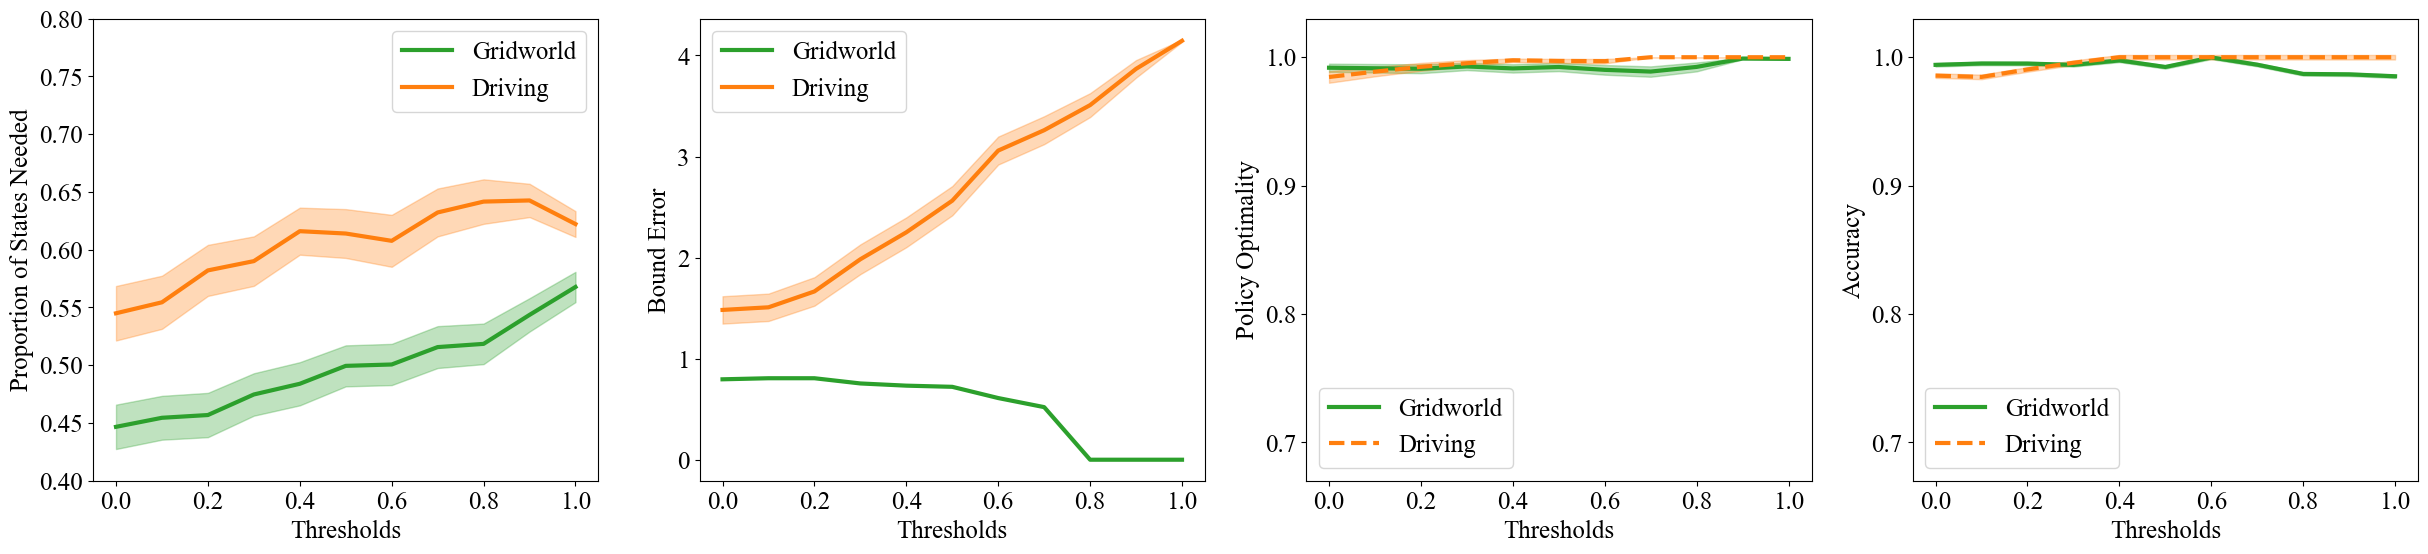

In [36]:
plot_results(active_goal_baseline_metrics, "gridworld", baseline_thresholds, active_driving_baseline_metrics, "driving")


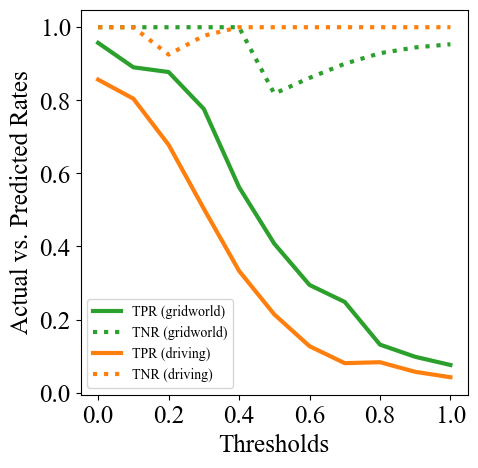

In [37]:
sensitivity_plot(active_goal_baseline_metrics["confusion_matrices"], "gridworld",
                  baseline_thresholds,
                  active_driving_baseline_metrics["confusion_matrices"], "driving")

# Active vs. passive comparison

In [38]:
gains = {"Stopping Condition": [], "Environment": [], "Min Gain": [], "Max Gain": [], "Avg Gain": [], "Median Gain": [], "Std Dev Gain": []}

pgnm = np.array([mean(passive_goal_nevd_metrics["pct_states"][t]) for t in nevd_thresholds], dtype = object)
pdnm = np.array([mean(passive_driving_nevd_metrics["pct_states"][t]) for t in nevd_thresholds], dtype = object)
pgbm = np.array([mean(passive_goal_baseline_metrics["pct_states"][t]) for t in baseline_thresholds], dtype = object)
pdbm = np.array([mean(passive_driving_baseline_metrics["pct_states"][t]) for t in baseline_thresholds], dtype = object)

agnm = np.array([mean(active_goal_nevd_metrics["pct_states"][t]) for t in nevd_thresholds], dtype = object)
adnm = np.array([mean(active_driving_nevd_metrics["pct_states"][t]) for t in nevd_thresholds], dtype = object)
agbm = np.array([mean(active_goal_baseline_metrics["pct_states"][t]) for t in baseline_thresholds], dtype = object)
adbm = np.array([mean(active_driving_baseline_metrics["pct_states"][t]) for t in baseline_thresholds], dtype = object)

gains["Stopping Condition"].extend(["nEVD", "nEVD", "Percent Improvement", "Percent Improvement"])
gains["Environment"].extend(["Gridworld", "Driving", "Gridworld", "Driving"])
gains["Min Gain"].extend([np.min(pgnm - agnm), np.min(pdnm - adnm), np.min(pgbm - agbm), np.min(pdbm - adbm)])
gains["Max Gain"].extend([np.max(pgnm - agnm), np.max(pdnm - adnm), np.max(pgbm - agbm), np.max(pdbm - adbm)])
gains["Avg Gain"].extend([np.mean(pgnm - agnm), np.mean(pdnm - adnm), np.mean(pgbm - agbm), np.mean(pdbm - adbm)])
gains["Median Gain"].extend([np.median(pgnm - agnm), np.median(pdnm - adnm), np.median(pgbm - agbm), np.median(pdbm - adbm)])
gains["Std Dev Gain"].extend([np.std(pgnm - agnm), np.std(pdnm - adnm), np.std(pgbm - agbm), np.std(pdbm - adbm)])

gains = pd.DataFrame(gains)
print("Total average gain", np.mean(gains["Avg Gain"]))
print("nEVD mean and stddev", np.mean(gains[gains["Stopping Condition"] == "nEVD"]["Avg Gain"]), "and", np.std(gains[gains["Stopping Condition"] == "nEVD"]["Avg Gain"]))
print("Percent mean and stddev", np.mean(gains[gains["Stopping Condition"] == "Percent Improvement"]["Avg Gain"]), "and", np.std(gains[gains["Stopping Condition"] == "Percent Improvement"]["Avg Gain"]))

def format_gains(gain):
    return str(round(100 * gain, 2)) + "%"

gains["Min Gain"] = gains["Min Gain"].apply(format_gains)
gains["Max Gain"] = gains["Max Gain"].apply(format_gains)
gains["Avg Gain"] = gains["Avg Gain"].apply(format_gains)
gains["Median Gain"] = gains["Median Gain"].apply(format_gains)
gains["Std Dev Gain"] = gains["Std Dev Gain"].apply(format_gains)

gains

Total average gain 0.13093006074011715
nEVD mean and stddev 0.12949729946311198 and 0.01621330417068389
Percent mean and stddev 0.13236282201712235 and 0.0064958344302470244


,Stopping Condition,Environment,Min Gain,Max Gain,Avg Gain,Median Gain,Std Dev Gain
0,nEVD,Gridworld,11.15%,11.63%,11.33%,11.33%,0.18%
1,nEVD,Driving,9.24%,19.02%,14.57%,15.22%,3.51%
2,Percent Improvement,Gridworld,10.81%,15.47%,12.59%,11.75%,1.8%
3,Percent Improvement,Driving,9.15%,27.11%,13.89%,11.69%,5.23%


# Hoeffding bounds comparison

In [39]:
bounds_demo_df = pd.read_csv("bounds_demo_df.csv")
bounds_demo_df.drop(columns = ["syed_schapire_bound", "abbeel_bound"], inplace = True)

In [40]:
bounds_demo_df

,bound,syed_schapire_num_demos,abbeel_num_demos
0,0.5,146166,64963
1,0.4,228383,101504
2,0.3,406014,180451
3,0.2,913532,406014
4,0.1,3654126,1624056


# Informative vs. ambiguous demos comparison

In [41]:
bad_demos = [5, 5, 5, 7, 2]
good_demos = [2, 2, 2, 3, 1]
bad_mean = np.mean(bad_demos)
good_mean = np.mean(good_demos)
bad_std = np.std(bad_demos)
good_std = np.std(good_demos)
print(bad_mean, bad_std)
print(good_mean, good_std)

4.8 1.6
2.0 0.6324555320336759


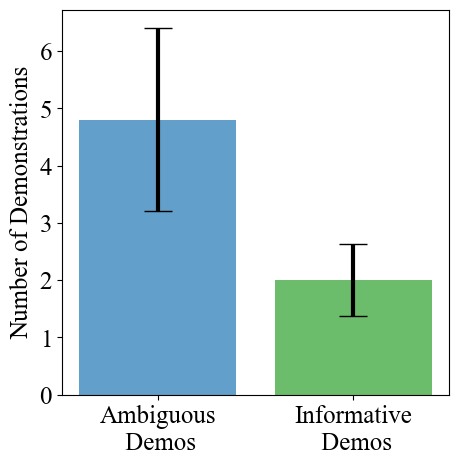

In [42]:
fig = plt.figure(figsize = (5, 5))
plt.bar(["Ambiguous\n Demos", "Informative\n Demos"],
        [bad_mean, good_mean],
        yerr = [bad_std, good_std],
        align = "center",
        alpha = 0.7,
        color = ["#1F77B4", "#2CA02C"],
        capsize = 10)
plt.ylabel("Number of Demonstrations")
plt.show()

# Repeat demos comparison

In [43]:
iid_repeat_metrics = {}
with open("./iid_repeat.txt") as file:
    lines = file.readlines()
    for i in range(len(lines)):
        if lines[i].startswith("Number of demos"):
            iid_repeat_metrics["num_demos"] = eval(lines[i+1].strip())
            i += 1
        elif lines[i].startswith("Average number of unique demos"):
            iid_repeat_metrics["num_unique_demos"] = eval(lines[i+1].strip())
            i += 1
        elif lines[i].startswith("Average bound across worlds"):
            iid_repeat_metrics["avg_nevd_bounds"] = eval(lines[i+1].strip())
            i += 1
        elif lines[i].startswith("Average ground-truth nEVD"):
            iid_repeat_metrics["avg_ground_truth_nevd"] = eval(lines[i+1].strip())
            i += 1
        elif lines[i].startswith("Average bound error"):
            iid_repeat_metrics["avg_bound_error"] = eval(lines[i+1].strip())
            i += 1
        elif lines[i].startswith("Average policy optimality"):
            iid_repeat_metrics["avg_policy_opt"] = eval(lines[i+1].strip())
            i += 1
        elif lines[i].startswith("Accuracy"):
            iid_repeat_metrics["accuracy_per_threshold"] = eval(lines[i+1].strip())
            i += 1

In [44]:
focused_repeat_metrics = {}
with open("./focused_repeat.txt") as file:
    lines = file.readlines()
    for i in range(len(lines)):
        if lines[i].startswith("Number of demos"):
            focused_repeat_metrics["num_demos"] = eval(lines[i+1].strip())
            i += 1
        elif lines[i].startswith("Average number of unique demos"):
            focused_repeat_metrics["num_unique_demos"] = eval(lines[i+1].strip())
            i += 1
        elif lines[i].startswith("Average bound across worlds"):
            focused_repeat_metrics["avg_nevd_bounds"] = eval(lines[i+1].strip())
            i += 1
        elif lines[i].startswith("Average ground-truth nEVD"):
            focused_repeat_metrics["avg_ground_truth_nevd"] = eval(lines[i+1].strip())
            i += 1
        elif lines[i].startswith("Average bound error"):
            focused_repeat_metrics["avg_bound_error"] = eval(lines[i+1].strip())
            i += 1
        elif lines[i].startswith("Average policy optimality"):
            focused_repeat_metrics["avg_policy_opt"] = eval(lines[i+1].strip())
            i += 1
        elif lines[i].startswith("Accuracy"):
            focused_repeat_metrics["accuracy_per_threshold"] = eval(lines[i+1].strip())
            i += 1

In [45]:
very_focused_repeat_metrics = {}
with open("./very_focused_repeat.txt") as file:
    lines = file.readlines()
    for i in range(len(lines)):
        if lines[i].startswith("Number of demos"):
            very_focused_repeat_metrics["num_demos"] = eval(lines[i+1].strip())
            i += 1
        elif lines[i].startswith("Average number of unique demos"):
            very_focused_repeat_metrics["num_unique_demos"] = eval(lines[i+1].strip())
            i += 1
        elif lines[i].startswith("Average bound across worlds"):
            very_focused_repeat_metrics["avg_nevd_bounds"] = eval(lines[i+1].strip())
            i += 1
        elif lines[i].startswith("Average ground-truth nEVD"):
            very_focused_repeat_metrics["avg_ground_truth_nevd"] = eval(lines[i+1].strip())
            i += 1
        elif lines[i].startswith("Average bound error"):
            very_focused_repeat_metrics["avg_bound_error"] = eval(lines[i+1].strip())
            i += 1
        elif lines[i].startswith("Average policy optimality"):
            very_focused_repeat_metrics["avg_policy_opt"] = eval(lines[i+1].strip())
            i += 1
        elif lines[i].startswith("Accuracy"):
            very_focused_repeat_metrics["accuracy_per_threshold"] = {t: 1 for t in np.arange(0.01, 0.06, 0.01)}
            i += 1

In [46]:
trajectory_repeat_metrics = {}
with open("./trajectory_repeat.txt") as file:
    lines = file.readlines()
    for i in range(len(lines)):
        if lines[i].startswith("Number of demos"):
            trajectory_repeat_metrics["num_demos"] = eval(lines[i+1].strip())
            i += 1
        elif lines[i].startswith("Average number of unique demos"):
            trajectory_repeat_metrics["num_unique_demos"] = eval(lines[i+1].strip())
            i += 1
        elif lines[i].startswith("Average bound across worlds"):
            trajectory_repeat_metrics["avg_nevd_bounds"] = eval(lines[i+1].strip())
            i += 1
        elif lines[i].startswith("Average ground-truth nEVD"):
            trajectory_repeat_metrics["avg_ground_truth_nevd"] = eval(lines[i+1].strip())
            i += 1
        elif lines[i].startswith("Average bound error"):
            trajectory_repeat_metrics["avg_bound_error"] = eval(lines[i+1].strip())
            i += 1
        elif lines[i].startswith("Average policy optimality"):
            trajectory_repeat_metrics["avg_policy_opt"] = eval(lines[i+1].strip())
            i += 1
        elif lines[i].startswith("Accuracy"):
            trajectory_repeat_metrics["accuracy_per_threshold"] = eval(lines[i+1].strip())
            i += 1

In [47]:
repeat_metrics = {
    "Informative": iid_repeat_metrics,
    "Ambiguous": focused_repeat_metrics,
    "Very Ambiguous": very_focused_repeat_metrics,
#     "trajectory": trajectory_repeat_metrics
}

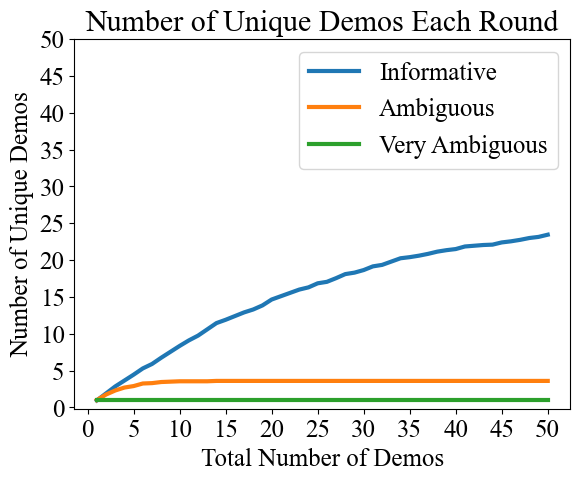

In [48]:
for key in repeat_metrics:
    plt.plot(repeat_metrics[key]["num_demos"], repeat_metrics[key]["num_unique_demos"], label = key)
plt.xticks(range(0, 51, 5))
plt.yticks(range(0, 51, 5))
plt.title("Number of Unique Demos Each Round")
plt.xlabel("Total Number of Demos")
plt.ylabel("Number of Unique Demos")
plt.legend()
plt.show()

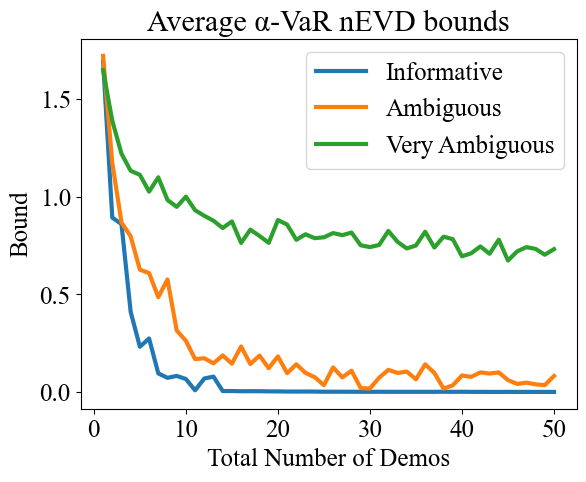

In [49]:
for key in repeat_metrics:
    plt.plot(repeat_metrics[key]["num_demos"], repeat_metrics[key]["avg_nevd_bounds"], label = key)
plt.title("Average α-VaR nEVD bounds")
plt.xlabel("Total Number of Demos")
plt.ylabel("Bound")
plt.legend()
plt.show()

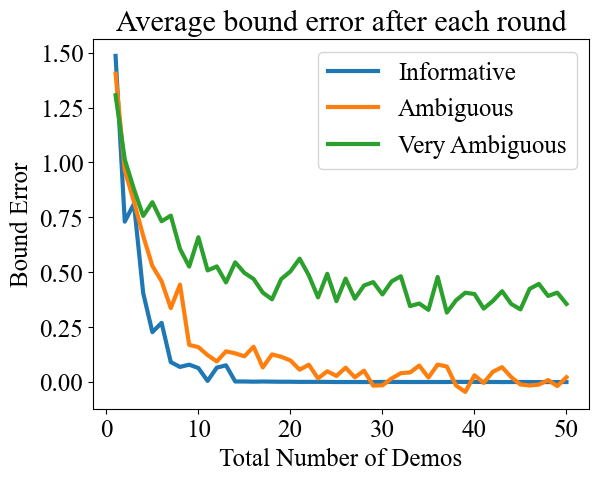

In [50]:
for key in repeat_metrics:
    plt.plot(repeat_metrics[key]["num_demos"], repeat_metrics[key]["avg_bound_error"], label = key)
plt.title("Average bound error after each round")
plt.xlabel("Total Number of Demos")
plt.ylabel("Bound Error")
plt.legend()
plt.show()

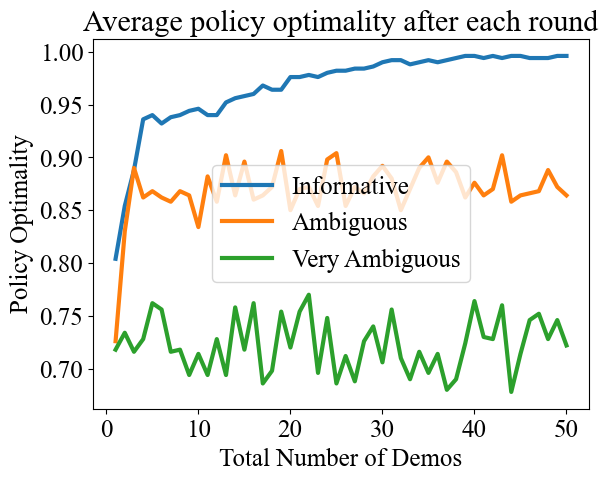

In [51]:
for key in repeat_metrics:
    plt.plot(repeat_metrics[key]["num_demos"], repeat_metrics[key]["avg_policy_opt"], label = key)
plt.title("Average policy optimality after each round")
plt.xlabel("Total Number of Demos")
plt.ylabel("Policy Optimality")
plt.legend()
plt.show()

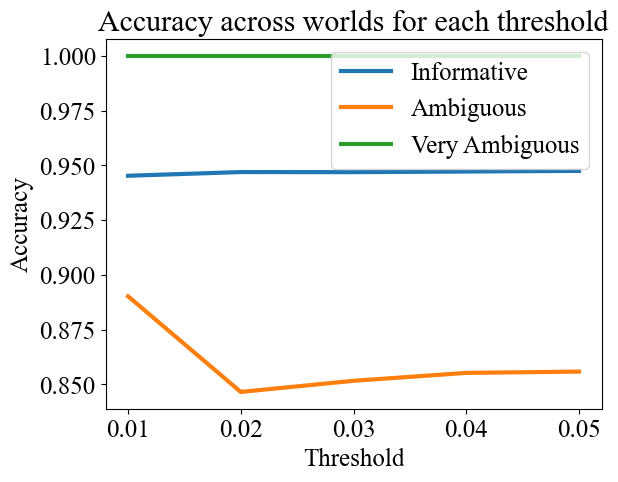

In [52]:
for key in repeat_metrics:
    thresholds = list(repeat_metrics[key]["accuracy_per_threshold"].keys())
    thresholds.sort()
    sorted_accuracies = [repeat_metrics[key]["accuracy_per_threshold"][t] for t in thresholds]
    plt.plot(thresholds, sorted_accuracies, label = key)
plt.title("Accuracy across worlds for each threshold")
plt.xlabel("Threshold")
plt.xticks(list(np.arange(0.01, 0.06, 0.01)))
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# MAP policy baseline (gridworld, driving)

In [53]:
goal_patience_metrics = {}
goal_patience_metrics["accuracies"] = {threshold: 0 for threshold in patience_thresholds}
goal_patience_metrics["pct_states"] = {threshold: [] for threshold in patience_thresholds}
goal_patience_metrics["policy_accuracies"] = {threshold: [] for threshold in patience_thresholds}
goal_patience_metrics["policy_optimalities"] = {threshold: [] for threshold in patience_thresholds}
goal_patience_metrics["confidence"] = {threshold: 0 for threshold in patience_thresholds}
goal_patience_metrics["CM100"] = {threshold: 0 for threshold in patience_thresholds}
goal_patience_metrics["CM95"] = {threshold: 0 for threshold in patience_thresholds}
goal_patience_metrics["CM90"] = {threshold: 0 for threshold in patience_thresholds}
goal_patience_metrics["CM5"] = {threshold: 0 for threshold in patience_thresholds}
goal_patience_metrics["CM4"] = {threshold: 0 for threshold in patience_thresholds}
goal_patience_metrics["CM3"] = {threshold: 0 for threshold in patience_thresholds}
goal_patience_metrics["CM2"] = {threshold: 0 for threshold in patience_thresholds}
goal_patience_metrics["CM1"] = {threshold: 0 for threshold in patience_thresholds}

# with open("paper_outputs/patience_goal_1.txt") as file:
# with open ("./F1/goal_map.txt") as file:
with open ("../ijcai-hri/OFFICIAL/goal_patience.txt") as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith("NEW THRESHOLD"):
            curr_thresh = float(re.search("NEW THRESHOLD ([\d.-]+)", line).group(1))
        elif line.strip() == "Percent states":
            curr_metric = "pct_states"
        elif line.strip() == "Policy optimalities":
            curr_metric = "policy_optimalities"
        elif line.strip() == "Policy accuracies":
            curr_metric = "policy_accuracies"
        elif line.strip() == "Confidence":
            curr_metric = "confidence"
        elif line.strip() == "Accuracy":
            curr_metric = "accuracies"
        elif line.strip().startswith("CM"):
            curr_metric = line.strip()
        elif line.strip().startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "[")):
            if curr_metric.startswith("CM"):
                goal_patience_metrics[curr_metric][curr_thresh] = eval(line.strip())
            elif curr_metric != "confidence" and curr_metric != "accuracies" and curr_metric != "":
                goal_patience_metrics[curr_metric][curr_thresh].append(np.abs(float(line.strip())))
            elif curr_metric == "confidence" or curr_metric == "accuracies":
                goal_patience_metrics[curr_metric][curr_thresh] = float(line.strip())
        else:
            curr_metric = ""

In [54]:
driving_patience_metrics = {}
driving_patience_metrics["accuracies"] = {threshold: 0 for threshold in patience_thresholds}
driving_patience_metrics["pct_states"] = {threshold: [] for threshold in patience_thresholds}
driving_patience_metrics["policy_accuracies"] = {threshold: [] for threshold in patience_thresholds}
driving_patience_metrics["policy_optimalities"] = {threshold: [] for threshold in patience_thresholds}
driving_patience_metrics["confidence"] = {threshold: 0 for threshold in patience_thresholds}
driving_patience_metrics["CM100"] = {threshold: 0 for threshold in patience_thresholds}
driving_patience_metrics["CM95"] = {threshold: 0 for threshold in patience_thresholds}
driving_patience_metrics["CM90"] = {threshold: 0 for threshold in patience_thresholds}
driving_patience_metrics["CM5"] = {threshold: 0 for threshold in patience_thresholds}
driving_patience_metrics["CM4"] = {threshold: 0 for threshold in patience_thresholds}
driving_patience_metrics["CM3"] = {threshold: 0 for threshold in patience_thresholds}
driving_patience_metrics["CM2"] = {threshold: 0 for threshold in patience_thresholds}
driving_patience_metrics["CM1"] = {threshold: 0 for threshold in patience_thresholds}

# with open("paper_outputs/patience_driving_1.txt") as file:
# with open ("./F1/driving_map.txt") as file:
with open ("../ijcai-hri/OFFICIAL/driving_patience.txt") as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith("NEW THRESHOLD"):
            curr_thresh = float(re.search("NEW THRESHOLD ([\d.-]+)", line).group(1))
        elif line.strip() == "Percent states":
            curr_metric = "pct_states"
        elif line.strip() == "Policy optimalities":
            curr_metric = "policy_optimalities"
        elif line.strip() == "Policy accuracies":
            curr_metric = "policy_accuracies"
        elif line.strip() == "Confidence":
            curr_metric = "confidence"
        elif line.strip() == "Accuracy":
            curr_metric = "accuracies"
        elif line.strip().startswith("CM"):
            curr_metric = line.strip()
        elif line.strip().startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "[")):
            if curr_metric.startswith("CM"):
                driving_patience_metrics[curr_metric][curr_thresh] = eval(line.strip())
            elif curr_metric != "confidence" and curr_metric != "accuracies" and curr_metric != "":
                driving_patience_metrics[curr_metric][curr_thresh].append(np.abs(float(line.strip())))
            elif curr_metric == "confidence" or curr_metric == "accuracies":
                driving_patience_metrics[curr_metric][curr_thresh] = float(line.strip())
        else:
            curr_metric = ""

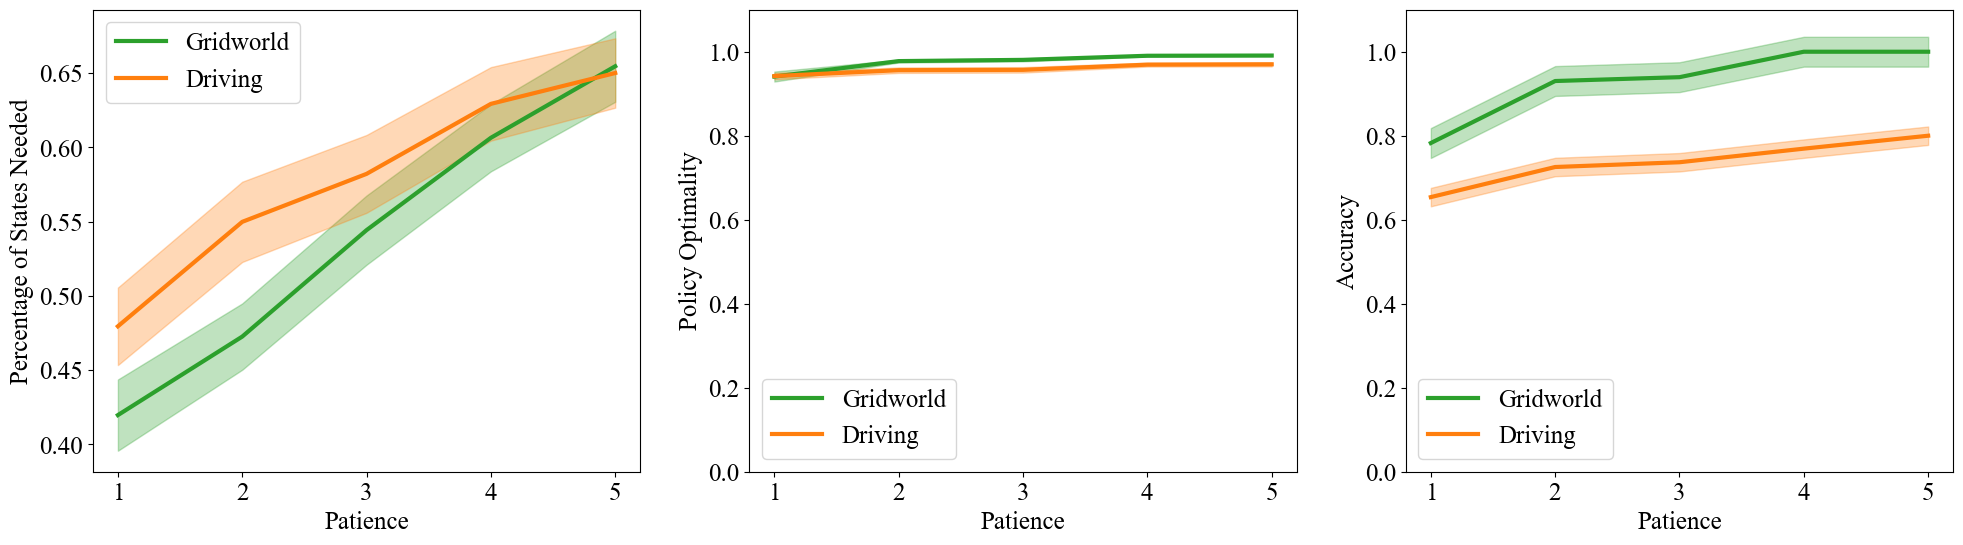

In [55]:
fig, axes = plt.subplots(1, 3, figsize = (24, 6))
x = patience_thresholds

y = np.array([mean(goal_patience_metrics["pct_states"][t]) for t in x])
axes[0].plot(x, y, color = color_scheme["gridworld"], label = "Gridworld")
err = np.array([sem(goal_patience_metrics["pct_states"][t]) for t in x])
axes[0].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme["gridworld"])

y = np.array([mean(driving_patience_metrics["pct_states"][t]) for t in x])
axes[0].plot(x, y, color = color_scheme["driving"], label = "Driving")
err = np.array([sem(driving_patience_metrics["pct_states"][t]) for t in x])
axes[0].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme["driving"])

axes[0].set(xlabel = "Patience", ylabel = "Percentage of States Needed")
# axes[0].set_yticks([round(v, 2) for v in np.arange(0.60, 0.80, 0.05)])


y = np.array([mean(goal_patience_metrics["policy_optimalities"][t]) for t in x])
axes[1].plot(x, y, color = color_scheme["gridworld"], label = "Gridworld")
err = np.array([sem(goal_patience_metrics["policy_optimalities"][t]) for t in x])
axes[1].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme["gridworld"])

y = np.array([mean(driving_patience_metrics["policy_optimalities"][t]) for t in x])
axes[1].plot(x, y, color = color_scheme["driving"], label = "Driving")
err = np.array([sem(driving_patience_metrics["policy_optimalities"][t]) for t in x])
axes[1].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme["driving"])

axes[1].set_yticks([round(v, 1) for v in np.arange(0.0, 1.1, 0.2)])
axes[1].set_ylim([0, 1.1])
axes[1].set(xlabel = "Patience", ylabel = "Policy Optimality")


y = np.array([goal_patience_metrics["accuracies"][t] for t in x])
axes[2].plot(x, y, color = color_scheme["gridworld"], label = "Gridworld")
err = np.array([np.std(y) / np.sqrt(len(y))] * len(y))
axes[2].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme["gridworld"])

y = np.array([driving_patience_metrics["accuracies"][t] for t in x])
axes[2].plot(x, y, color = color_scheme["driving"], label = "Driving")
err = np.array([np.std(y) / np.sqrt(len(y))] * len(y))
axes[2].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme["driving"])

axes[2].set_yticks([round(v, 1) for v in np.arange(0.0, 1.1, 0.2)])
axes[2].set_ylim([0, 1.1])
axes[2].set(xlabel = "Patience", ylabel = "Accuracy")

for ax in axes.flat:
    ax.set_xticks(x)
    ax.legend()

plt.show()

# MAP policy baseline (lander, lavaworld)

In [56]:
lander_patience_metrics = {}
lander_patience_metrics["accuracies"] = {threshold: 0 for threshold in patience_thresholds}
lander_patience_metrics["num_demos"] = {threshold: [] for threshold in patience_thresholds}
lander_patience_metrics["policy_accuracies"] = {threshold: [] for threshold in patience_thresholds}
lander_patience_metrics["policy_optimalities"] = {threshold: [] for threshold in patience_thresholds}
lander_patience_metrics["confidence"] = {threshold: 0 for threshold in patience_thresholds}
lander_patience_metrics["CM100"] = {threshold: 0 for threshold in patience_thresholds}
lander_patience_metrics["CM95"] = {threshold: 0 for threshold in patience_thresholds}
lander_patience_metrics["CM90"] = {threshold: 0 for threshold in patience_thresholds}
lander_patience_metrics["CM5"] = {threshold: 0 for threshold in patience_thresholds}
lander_patience_metrics["CM4"] = {threshold: 0 for threshold in patience_thresholds}
lander_patience_metrics["CM3"] = {threshold: 0 for threshold in patience_thresholds}
lander_patience_metrics["CM2"] = {threshold: 0 for threshold in patience_thresholds}
lander_patience_metrics["CM1"] = {threshold: 0 for threshold in patience_thresholds}

# with open("../continuous_birl/simulations/lander/F1/lander_map_true.txt") as file:
with open ("../ijcai-hri/OFFICIAL/lander_patience.txt") as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith("NEW THRESHOLD"):
            curr_thresh = float(re.search("NEW THRESHOLD ([\d.-]+)", line).group(1))
        elif line.strip() == "Num demos":
            curr_metric = "num_demos"
        elif line.strip() == "Policy optimalities":
            curr_metric = "policy_optimalities"
        elif line.strip() == "Policy accuracies":
            curr_metric = "policy_accuracies"
        elif line.strip() == "Confidence":
            curr_metric = "confidence"
        elif line.strip() == "Accuracy":
            curr_metric = "accuracies"
        elif line.strip().startswith("CM"):
            curr_metric = line.strip()
        elif line.strip().startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "[")):
            if curr_metric.startswith("CM"):
                lander_patience_metrics[curr_metric][curr_thresh] = eval(line.strip())
            elif curr_metric != "confidence" and curr_metric != "accuracies" and curr_metric != "":
                lander_patience_metrics[curr_metric][curr_thresh].append(np.abs(float(line.strip())))
            elif curr_metric == "confidence" or curr_metric == "accuracies":
                lander_patience_metrics[curr_metric][curr_thresh] = float(line.strip()) + 0.5
        else:
            curr_metric = ""

In [57]:
lavaworld_patience_metrics = {}
lavaworld_patience_metrics["accuracies"] = {threshold: 0 for threshold in patience_thresholds}
lavaworld_patience_metrics["num_demos"] = {threshold: [] for threshold in patience_thresholds}
lavaworld_patience_metrics["policy_accuracies"] = {threshold: [] for threshold in patience_thresholds}
lavaworld_patience_metrics["policy_optimalities"] = {threshold: [] for threshold in patience_thresholds}
lavaworld_patience_metrics["confidence"] = {threshold: 0 for threshold in patience_thresholds}
lavaworld_patience_metrics["CM100"] = {threshold: 0 for threshold in patience_thresholds}
lavaworld_patience_metrics["CM95"] = {threshold: 0 for threshold in patience_thresholds}
lavaworld_patience_metrics["CM90"] = {threshold: 0 for threshold in patience_thresholds}
lavaworld_patience_metrics["CM5"] = {threshold: 0 for threshold in patience_thresholds}
lavaworld_patience_metrics["CM4"] = {threshold: 0 for threshold in patience_thresholds}
lavaworld_patience_metrics["CM3"] = {threshold: 0 for threshold in patience_thresholds}
lavaworld_patience_metrics["CM2"] = {threshold: 0 for threshold in patience_thresholds}
lavaworld_patience_metrics["CM1"] = {threshold: 0 for threshold in patience_thresholds}

# with open("./lava_map_20.txt") as file:
with open ("./F1/lava_map_6.txt") as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith("NEW THRESHOLD"):
            curr_thresh = float(re.search("NEW THRESHOLD ([\d.-]+)", line).group(1))
        elif line.strip() == "Num demos":
            curr_metric = "num_demos"
        elif line.strip() == "Policy optimalities":
            curr_metric = "policy_optimalities"
        elif line.strip() == "Policy accuracies":
            curr_metric = "policy_accuracies"
        elif line.strip() == "Confidence":
            curr_metric = "confidence"
        elif line.strip() == "Accuracy":
            curr_metric = "accuracies"
        elif line.strip().startswith("CM"):
            curr_metric = line.strip()
        elif line.strip().startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "[")):
            if curr_metric.startswith("CM"):
                lavaworld_patience_metrics[curr_metric][curr_thresh] = eval(line.strip())
            elif curr_metric != "confidence" and curr_metric != "accuracies" and curr_metric != "":
                lavaworld_patience_metrics[curr_metric][curr_thresh].append(np.abs(float(line.strip())))
            elif curr_metric == "confidence" or curr_metric == "accuracies":
                lavaworld_patience_metrics[curr_metric][curr_thresh] = float(line.strip())
        else:
            curr_metric = ""

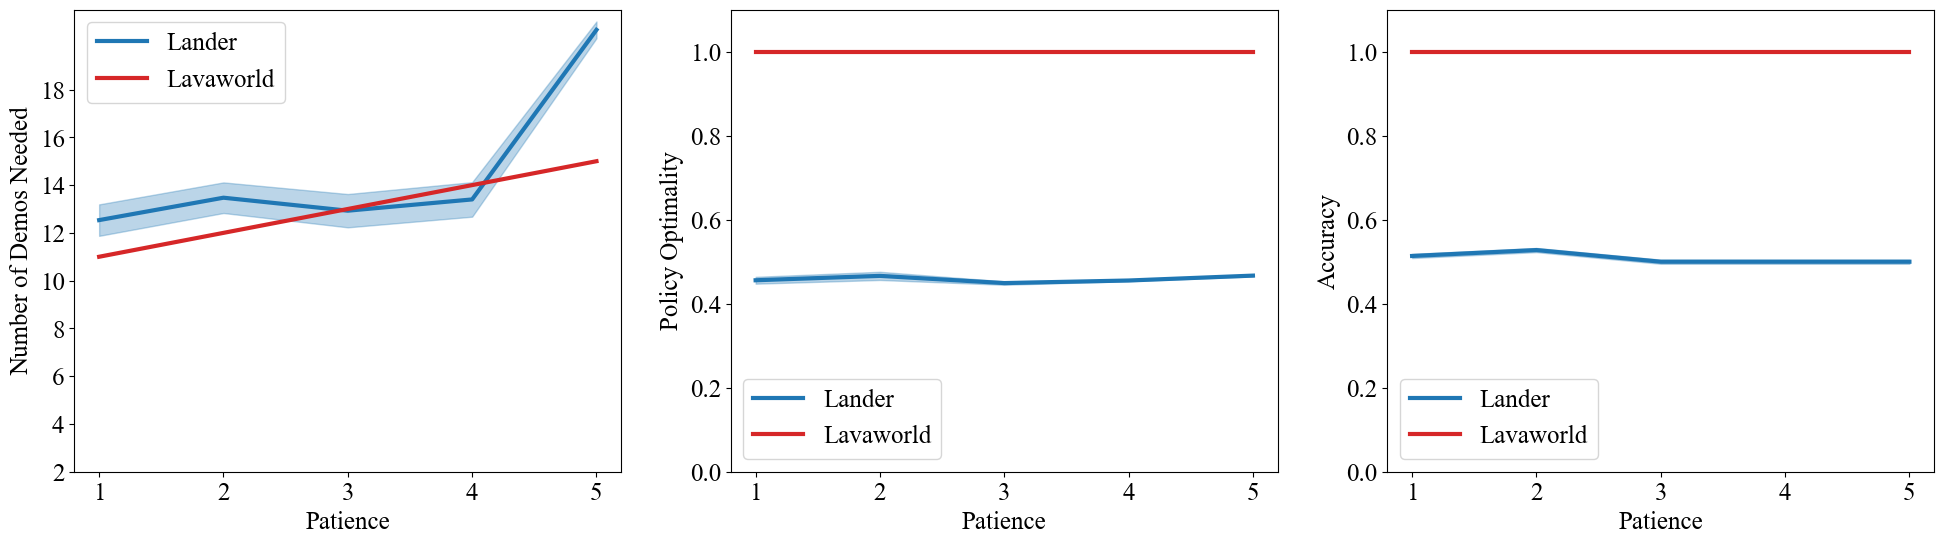

In [58]:
fig, axes = plt.subplots(1, 3, figsize = (24, 6))
x = patience_thresholds

y = np.array([mean(lander_patience_metrics["num_demos"][t]) for t in x])
axes[0].plot(x, y, color = color_scheme["lander"], label = "Lander")
err = np.array([sem(lander_patience_metrics["num_demos"][t]) for t in x])
axes[0].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme["lander"])

y = np.array([mean(lavaworld_patience_metrics["num_demos"][t]) for t in x])
axes[0].plot(x, y, color = color_scheme["lavaworld"], label = "Lavaworld")
err = np.array([sem(lavaworld_patience_metrics["num_demos"][t]) for t in x])
axes[0].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme["lavaworld"])

axes[0].set(xlabel = "Patience", ylabel = "Number of Demos Needed")
axes[0].set_yticks([v for v in np.arange(2, 19, 2)])


y = np.array([mean(lander_patience_metrics["policy_optimalities"][t]) for t in x])
axes[1].plot(x, y, color = color_scheme["lander"], label = "Lander")
err = np.array([sem(lander_patience_metrics["policy_optimalities"][t]) for t in x])
axes[1].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme["lander"])

y = np.array([mean(lavaworld_patience_metrics["policy_optimalities"][t]) for t in x])
axes[1].plot(x, y, color = color_scheme["lavaworld"], label = "Lavaworld")
err = np.array([sem(lavaworld_patience_metrics["policy_optimalities"][t]) for t in x])
axes[1].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme["lavaworld"])

axes[1].set_yticks([round(v, 1) for v in np.arange(0.0, 1.1, 0.2)])
axes[1].set_ylim([0, 1.1])
axes[1].set(xlabel = "Patience", ylabel = "Policy Optimality")


y = np.array([lander_patience_metrics["accuracies"][t] for t in x])
axes[2].plot(x, y, color = color_scheme["lander"], label = "Lander")
err = np.array([np.std(y) / np.sqrt(len(y))] * len(y))
axes[2].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme["lander"])

y = np.array([lavaworld_patience_metrics["accuracies"][t] for t in x])
axes[2].plot(x, y, color = color_scheme["lavaworld"], label = "Lavaworld")
err = np.array([np.std(y) / np.sqrt(len(y))] * len(y))
axes[2].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme["lavaworld"])

axes[2].set_yticks([round(v, 1) for v in np.arange(0.0, 1.1, 0.2)])
axes[2].set_ylim([0, 1.1])
axes[2].set(xlabel = "Patience", ylabel = "Accuracy")

for ax in axes.flat:
    ax.set_xticks(x)
    ax.legend()

plt.show()

# Held out set baseline (gridworld, driving)

In [59]:
goal_held_out_metrics = {}
goal_held_out_metrics["accuracies"] = {threshold: 0 for threshold in held_out_thresholds}
goal_held_out_metrics["pct_states"] = {threshold: [] for threshold in held_out_thresholds}
goal_held_out_metrics["policy_accuracies"] = {threshold: [] for threshold in held_out_thresholds}
goal_held_out_metrics["policy_optimalities"] = {threshold: [] for threshold in held_out_thresholds}
goal_held_out_metrics["confidence"] = {threshold: 0 for threshold in held_out_thresholds}
goal_held_out_metrics["CM100"] = {threshold: 0 for threshold in held_out_thresholds}
goal_held_out_metrics["CM95"] = {threshold: 0 for threshold in held_out_thresholds}
goal_held_out_metrics["CM90"] = {threshold: 0 for threshold in held_out_thresholds}
goal_held_out_metrics["CM5"] = {threshold: 0 for threshold in held_out_thresholds}
goal_held_out_metrics["CM4"] = {threshold: 0 for threshold in held_out_thresholds}
goal_held_out_metrics["CM3"] = {threshold: 0 for threshold in held_out_thresholds}
goal_held_out_metrics["CM2"] = {threshold: 0 for threshold in held_out_thresholds}
goal_held_out_metrics["CM1"] = {threshold: 0 for threshold in held_out_thresholds}

# with open("./goal_held_out_exact.txt") as file:
# with open ("./F1/goal_heldout_exact.txt") as file:
with open ("../ijcai-hri/OFFICIAL/goal_heldout.txt") as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith("NEW THRESHOLD"):
            curr_thresh = float(re.search("NEW THRESHOLD ([\d.-]+)", line).group(1))
        elif line.strip() == "Percent states":
            curr_metric = "pct_states"
        elif line.strip() == "Policy optimalities":
            curr_metric = "policy_optimalities"
        elif line.strip() == "Policy accuracies":
            curr_metric = "policy_accuracies"
        elif line.strip() == "Confidence":
            curr_metric = "confidence"
        elif line.strip() == "Accuracy":
            curr_metric = "accuracies"
        elif line.strip().startswith("CM"):
            curr_metric = line.strip()
        elif line.strip().startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "[")):
            if curr_metric.startswith("CM"):
                goal_held_out_metrics[curr_metric][curr_thresh] = eval(line.strip())
            elif curr_metric != "confidence" and curr_metric != "accuracies" and curr_metric != "":
                goal_held_out_metrics[curr_metric][curr_thresh].append(np.abs(float(line.strip())))
            elif curr_metric == "confidence" or curr_metric == "accuracies":
                goal_held_out_metrics[curr_metric][curr_thresh] = float(line.strip())
                # forgot to account for the inner threshold for loop in code ^
        else:
            curr_metric = ""

In [60]:
driving_held_out_metrics = {}
driving_held_out_metrics["accuracies"] = {threshold: 0 for threshold in held_out_thresholds}
driving_held_out_metrics["pct_states"] = {threshold: [] for threshold in held_out_thresholds}
driving_held_out_metrics["policy_accuracies"] = {threshold: [] for threshold in held_out_thresholds}
driving_held_out_metrics["policy_optimalities"] = {threshold: [] for threshold in held_out_thresholds}
driving_held_out_metrics["confidence"] = {threshold: 0 for threshold in held_out_thresholds}
driving_held_out_metrics["CM100"] = {threshold: 0 for threshold in held_out_thresholds}
driving_held_out_metrics["CM95"] = {threshold: 0 for threshold in held_out_thresholds}
driving_held_out_metrics["CM90"] = {threshold: 0 for threshold in held_out_thresholds}
driving_held_out_metrics["CM5"] = {threshold: 0 for threshold in held_out_thresholds}
driving_held_out_metrics["CM4"] = {threshold: 0 for threshold in held_out_thresholds}
driving_held_out_metrics["CM3"] = {threshold: 0 for threshold in held_out_thresholds}
driving_held_out_metrics["CM2"] = {threshold: 0 for threshold in held_out_thresholds}
driving_held_out_metrics["CM1"] = {threshold: 0 for threshold in held_out_thresholds}

# with open("./driving_held_out_exact.txt") as file:
# with open ("./F1/driving_heldout_exact.txt") as file:
with open ("../ijcai-hri/OFFICIAL/driving_heldout.txt") as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith("NEW THRESHOLD"):
            curr_thresh = float(re.search("NEW THRESHOLD ([\d.-]+)", line).group(1))
        elif line.strip() == "Percent states":
            curr_metric = "pct_states"
        elif line.strip() == "Policy optimalities":
            curr_metric = "policy_optimalities"
        elif line.strip() == "Policy accuracies":
            curr_metric = "policy_accuracies"
        elif line.strip() == "Confidence":
            curr_metric = "confidence"
        elif line.strip() == "Accuracy":
            curr_metric = "accuracies"
        elif line.strip().startswith("CM"):
            curr_metric = line.strip()
        elif line.strip().startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "[")):
            if curr_metric.startswith("CM"):
                driving_held_out_metrics[curr_metric][curr_thresh] = eval(line.strip())
            elif curr_metric != "confidence" and curr_metric != "accuracies" and curr_metric != "":
                driving_held_out_metrics[curr_metric][curr_thresh].append(np.abs(float(line.strip())))
            elif curr_metric == "confidence" or curr_metric == "accuracies":
                driving_held_out_metrics[curr_metric][curr_thresh] = float(line.strip())
                # forgot to account for the inner threshold for loop in code ^
        else:
            curr_metric = ""

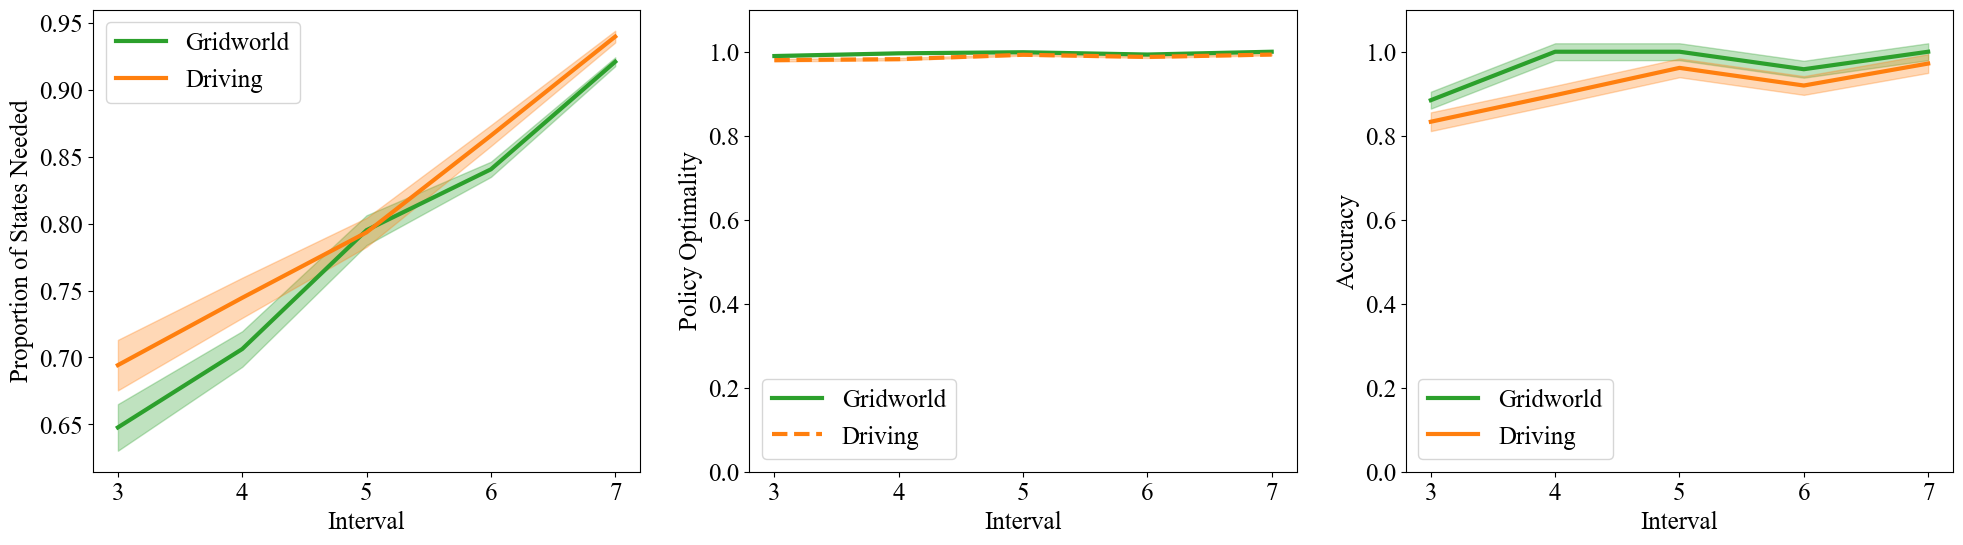

In [61]:
fig, axes = plt.subplots(1, 3, figsize = (24, 6))
x = held_out_thresholds

y = np.array([mean(goal_held_out_metrics["pct_states"][t]) for t in x])
axes[0].plot(x, y, color = color_scheme["gridworld"], label = "Gridworld")
err = np.array([sem(goal_held_out_metrics["pct_states"][t]) for t in x])
axes[0].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme["gridworld"])

y = np.array([mean(driving_held_out_metrics["pct_states"][t]) for t in x])
axes[0].plot(x, y, color = color_scheme["driving"], label = "Driving")
err = np.array([sem(driving_held_out_metrics["pct_states"][t]) for t in x])
axes[0].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme["driving"])

axes[0].set(xlabel = "Interval", ylabel = "Proportion of States Needed")
# axes[0].set_yticks([round(v, 2) for v in np.arange(0.60, 0.80, 0.05)])


y = np.array([mean(goal_held_out_metrics["policy_optimalities"][t]) for t in x])
axes[1].plot(x, y, color = color_scheme["gridworld"], label = "Gridworld")
err = np.array([sem(goal_held_out_metrics["policy_optimalities"][t]) for t in x])
axes[1].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme["gridworld"])

y = np.array([mean(driving_held_out_metrics["policy_optimalities"][t]) for t in x])
axes[1].plot(x, y, color = color_scheme["driving"], label = "Driving", linestyle = "--")
err = np.array([sem(driving_held_out_metrics["policy_optimalities"][t]) for t in x])
axes[1].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme["driving"])

axes[1].set_yticks([round(v, 1) for v in np.arange(0.0, 1.1, 0.2)])
axes[1].set_ylim([0, 1.1])
axes[1].set(xlabel = "Interval", ylabel = "Policy Optimality")


y = np.array([goal_held_out_metrics["accuracies"][t] for t in x])
axes[2].plot(x, y, color = color_scheme["gridworld"], label = "Gridworld")
err = np.array([np.std(y) / np.sqrt(len(y))] * len(y))
axes[2].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme["gridworld"])

y = np.array([driving_held_out_metrics["accuracies"][t] for t in x])
axes[2].plot(x, y, color = color_scheme["driving"], label = "Driving")
err = np.array([np.std(y) / np.sqrt(len(y))] * len(y))
axes[2].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme["driving"])

axes[2].set_yticks([round(v, 1) for v in np.arange(0.0, 1.1, 0.2)])
axes[2].set_ylim([0, 1.1])
axes[2].set(xlabel = "Interval", ylabel = "Accuracy")

for ax in axes.flat:
    ax.set_xticks(x)
    ax.legend()

plt.show()

# Held out set baseline (lander, lavaworld)

In [62]:
lander_held_out_metrics = {}
lander_held_out_metrics["accuracies"] = {threshold: 0 for threshold in held_out_thresholds}
lander_held_out_metrics["num_demos"] = {threshold: [] for threshold in held_out_thresholds}
lander_held_out_metrics["policy_accuracies"] = {threshold: [] for threshold in held_out_thresholds}
lander_held_out_metrics["policy_optimalities"] = {threshold: [] for threshold in held_out_thresholds}
lander_held_out_metrics["confidence"] = {threshold: 0 for threshold in held_out_thresholds}
lander_held_out_metrics["CM100"] = {threshold: 0 for threshold in held_out_thresholds}
lander_held_out_metrics["CM95"] = {threshold: 0 for threshold in held_out_thresholds}
lander_held_out_metrics["CM90"] = {threshold: 0 for threshold in held_out_thresholds}
lander_held_out_metrics["CM5"] = {threshold: 0 for threshold in held_out_thresholds}
lander_held_out_metrics["CM4"] = {threshold: 0 for threshold in held_out_thresholds}
lander_held_out_metrics["CM3"] = {threshold: 0 for threshold in held_out_thresholds}
lander_held_out_metrics["CM2"] = {threshold: 0 for threshold in held_out_thresholds}
lander_held_out_metrics["CM1"] = {threshold: 0 for threshold in held_out_thresholds}

# with open("../continuous_birl/simulations/lander/F1/lander_heldout_false.txt") as file:
with open ("../ijcai-hri/OFFICIAL/lander_heldout.txt") as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith("NEW THRESHOLD"):
            curr_thresh = float(re.search("NEW THRESHOLD ([\d.-]+)", line).group(1))
        elif line.strip() == "Num demos":
            curr_metric = "num_demos"
        elif line.strip() == "Policy optimalities":
            curr_metric = "policy_optimalities"
        elif line.strip() == "Policy accuracies":
            curr_metric = "policy_accuracies"
        elif line.strip() == "Confidence":
            curr_metric = "confidence"
        elif line.strip() == "Accuracy":
            curr_metric = "accuracies"
        elif line.strip().startswith("CM"):
            curr_metric = line.strip()
        elif line.strip().startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "[")):
            if curr_metric.startswith("CM"):
                lander_held_out_metrics[curr_metric][curr_thresh] = eval(line.strip())
            elif curr_metric != "confidence" and curr_metric != "accuracies" and curr_metric != "":
                lander_held_out_metrics[curr_metric][curr_thresh].append(np.abs(float(line.strip())))
            elif curr_metric == "confidence" or curr_metric == "accuracies":
                lander_held_out_metrics[curr_metric][curr_thresh] = float(line.strip())
        else:
            curr_metric = ""

In [63]:
lavaworld_held_out_metrics = {}
lavaworld_held_out_metrics["accuracies"] = {threshold: 0 for threshold in held_out_thresholds}
lavaworld_held_out_metrics["num_demos"] = {threshold: [] for threshold in held_out_thresholds}
lavaworld_held_out_metrics["policy_accuracies"] = {threshold: [] for threshold in held_out_thresholds}
lavaworld_held_out_metrics["policy_optimalities"] = {threshold: [] for threshold in held_out_thresholds}
lavaworld_held_out_metrics["confidence"] = {threshold: 0 for threshold in held_out_thresholds}
lavaworld_held_out_metrics["CM100"] = {threshold: 0 for threshold in held_out_thresholds}
lavaworld_held_out_metrics["CM95"] = {threshold: 0 for threshold in held_out_thresholds}
lavaworld_held_out_metrics["CM90"] = {threshold: 0 for threshold in held_out_thresholds}
lavaworld_held_out_metrics["CM5"] = {threshold: 0 for threshold in held_out_thresholds}
lavaworld_held_out_metrics["CM4"] = {threshold: 0 for threshold in held_out_thresholds}
lavaworld_held_out_metrics["CM3"] = {threshold: 0 for threshold in held_out_thresholds}
lavaworld_held_out_metrics["CM2"] = {threshold: 0 for threshold in held_out_thresholds}
lavaworld_held_out_metrics["CM1"] = {threshold: 0 for threshold in held_out_thresholds}

# with open("./lava_held_out_6.txt") as file:
with open ("./F1/lava_heldout_6.txt") as file:
    lines = file.readlines()
    for line in lines:
        if line.startswith("NEW THRESHOLD"):
            curr_thresh = float(re.search("NEW THRESHOLD ([\d.-]+)", line).group(1))
        elif line.strip() == "Num demos":
            curr_metric = "num_demos"
        elif line.strip() == "Policy optimalities":
            curr_metric = "policy_optimalities"
        elif line.strip() == "Policy accuracies":
            curr_metric = "policy_accuracies"
        elif line.strip() == "Confidence":
            curr_metric = "confidence"
        elif line.strip() == "Accuracy":
            curr_metric = "accuracies"
        elif line.strip().startswith("CM"):
            curr_metric = line.strip()
        elif line.strip().startswith(("0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "[")):
            if curr_metric.startswith("CM"):
                lavaworld_held_out_metrics[curr_metric][curr_thresh] = eval(line.strip())
            elif curr_metric != "confidence" and curr_metric != "accuracies" and curr_metric != "":
                lavaworld_held_out_metrics[curr_metric][curr_thresh].append(np.abs(float(line.strip())))
            elif curr_metric == "confidence" or curr_metric == "accuracies":
                lavaworld_held_out_metrics[curr_metric][curr_thresh] = float(line.strip())
                # forgot to account for len(accuracies) above
        else:
            curr_metric = ""

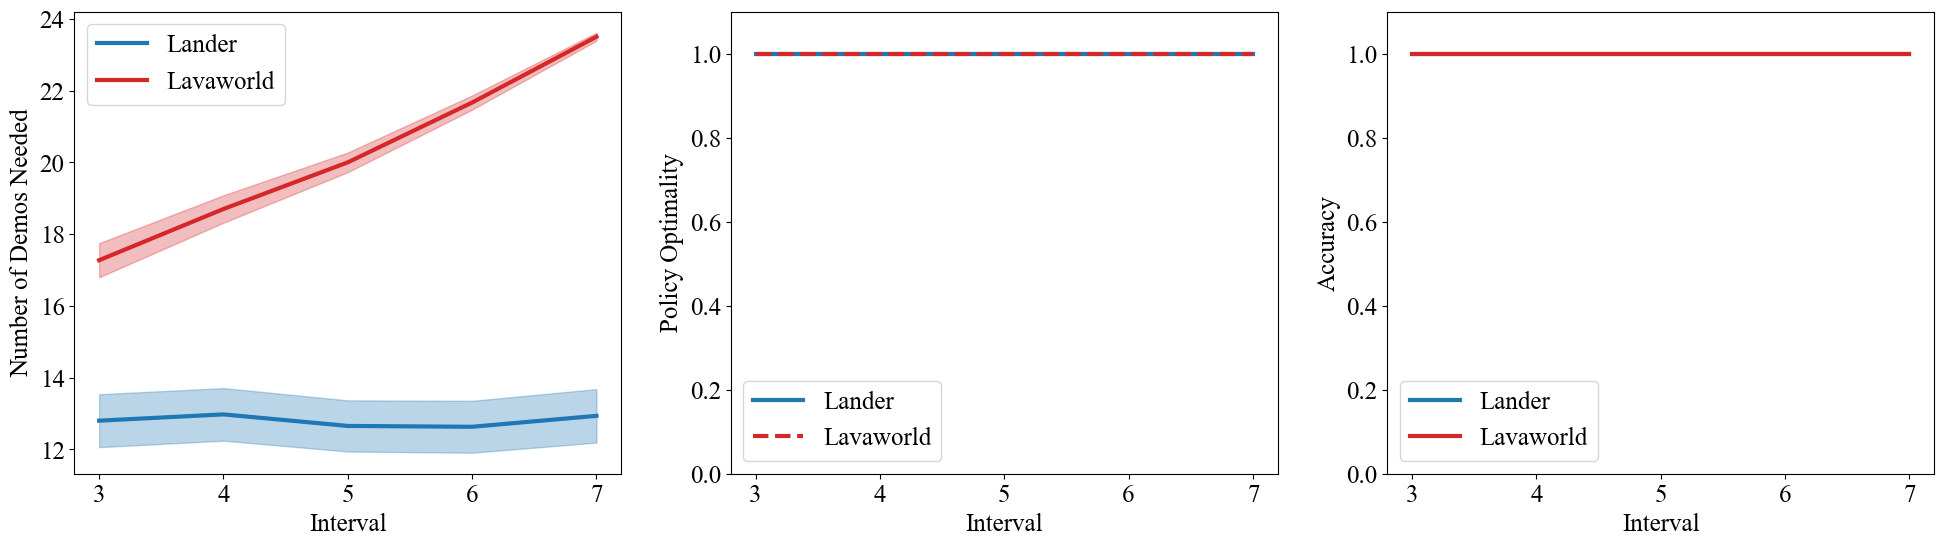

In [64]:
fig, axes = plt.subplots(1, 3, figsize = (24, 6))
x = held_out_thresholds

y = np.array([mean(lander_held_out_metrics["num_demos"][t]) for t in x])
axes[0].plot(x, y, color = color_scheme["lander"], label = "Lander")
err = np.array([sem(lander_held_out_metrics["num_demos"][t]) for t in x])
axes[0].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme["lander"])

y = np.array([mean(lavaworld_held_out_metrics["num_demos"][t]) for t in x])
axes[0].plot(x, y, color = color_scheme["lavaworld"], label = "Lavaworld")
err = np.array([sem(lavaworld_held_out_metrics["num_demos"][t]) for t in x])
axes[0].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme["lavaworld"])

axes[0].set(xlabel = "Interval", ylabel = "Number of Demos Needed")
# axes[0].set_yticks([round(v, 2) for v in np.arange(0.60, 0.80, 0.05)])


y = np.array([mean(lander_held_out_metrics["policy_optimalities"][t]) for t in x])
axes[1].plot(x, y, color = color_scheme["lander"], label = "Lander")
err = np.array([sem(lander_held_out_metrics["policy_optimalities"][t]) for t in x])
axes[1].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme["lander"])

y = np.array([mean(lavaworld_held_out_metrics["policy_optimalities"][t]) for t in x])
axes[1].plot(x, y, color = color_scheme["lavaworld"], label = "Lavaworld", linestyle = "--")
err = np.array([sem(lavaworld_held_out_metrics["policy_optimalities"][t]) for t in x])
axes[1].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme["lavaworld"])

axes[1].set_yticks([round(v, 1) for v in np.arange(0.0, 1.1, 0.2)])
axes[1].set_ylim([0, 1.1])
axes[1].set(xlabel = "Interval", ylabel = "Policy Optimality")


y = np.array([lander_held_out_metrics["accuracies"][t] for t in x])
axes[2].plot(x, y, color = color_scheme["lander"], label = "Lander")
err = np.array([np.std(y) / np.sqrt(len(y))] * len(y))
axes[2].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme["lander"])

y = np.array([lavaworld_held_out_metrics["accuracies"][t] for t in x[::-1]])  # not sure why they are reversed
axes[2].plot(x, y, color = color_scheme["lavaworld"], label = "Lavaworld")
err = np.array([np.std(y) / np.sqrt(len(y))] * len(y))
axes[2].fill_between(x, y - err, y + err, alpha = 0.3, color = color_scheme["lavaworld"])

axes[2].set_yticks([round(v, 1) for v in np.arange(0.0, 1.1, 0.2)])
axes[2].set_ylim([0, 1.1])
axes[2].set(xlabel = "Interval", ylabel = "Accuracy")

for ax in axes.flat:
    ax.set_xticks(x)
    ax.legend()

plt.show()

# Reconsolidated Methodology Plots

In [65]:
### CALCULATION FUNCTION ###
def calc_results(gridworld_nevd, driving_nevd, lander_nevd, lavaworld_nevd,
                 gridworld_MAP, driving_MAP, lander_MAP, lavaworld_MAP,
                 gridworld_heldout, driving_heldout, lander_heldout, lavaworld_heldout,
                 nevd_thresholds,
                 patience_value1 = 3, patience_value2 = 5, interval_value1 = 3, interval_value2 = 5):
    
    ### DISCRETE, PROPORTION OF STATES METRIC
    discrete_pct_states = {t: {"nevd": [], "MAP1": [], "MAP2": [], "held_out1": [], "held_out2": []} for t in nevd_thresholds}
    for t in nevd_thresholds:
        discrete_pct_states[t]["nevd"].extend(gridworld_nevd["pct_states"][t])
        discrete_pct_states[t]["nevd"].extend(driving_nevd["pct_states"][t])
        discrete_pct_states[t]["MAP1"].extend(gridworld_MAP["pct_states"][patience_value1])
        discrete_pct_states[t]["MAP1"].extend(driving_MAP["pct_states"][patience_value1])
        discrete_pct_states[t]["MAP2"].extend(gridworld_MAP["pct_states"][patience_value2])
        discrete_pct_states[t]["MAP2"].extend(driving_MAP["pct_states"][patience_value2])
        discrete_pct_states[t]["held_out1"].extend(gridworld_heldout["pct_states"][interval_value1])
        discrete_pct_states[t]["held_out1"].extend(driving_heldout["pct_states"][interval_value1])
        discrete_pct_states[t]["held_out2"].extend(gridworld_heldout["pct_states"][interval_value2])
        discrete_pct_states[t]["held_out2"].extend(driving_heldout["pct_states"][interval_value2])
    
    ### DISCRETE, F1 METRIC
    discrete_F1s = {t: {"nevd": [], "MAP1": [], "MAP2": [], "held_out1": [], "held_out2": []} for t in nevd_thresholds}
    for t in nevd_thresholds:
        discrete_F1s[t]["nevd"].append(calc_F1(gridworld_nevd["confusion_matrices"][t]))
        discrete_F1s[t]["nevd"].append(calc_F1(driving_nevd["confusion_matrices"][t]))
        discrete_F1s[t]["MAP1"].append(calc_F1(gridworld_MAP[f"CM{int(t * 10)}"][patience_value1]))
        discrete_F1s[t]["MAP1"].append(calc_F1(driving_MAP[f"CM{int(t * 10)}"][patience_value1]))
        discrete_F1s[t]["MAP2"].append(calc_F1(gridworld_MAP[f"CM{int(t * 10)}"][patience_value2]))
        discrete_F1s[t]["MAP2"].append(calc_F1(driving_MAP[f"CM{int(t * 10)}"][patience_value2]))
        discrete_F1s[t]["held_out1"].append(calc_F1(gridworld_heldout[f"CM{int(t * 10)}"][interval_value1]))
        discrete_F1s[t]["held_out1"].append(calc_F1(driving_heldout[f"CM{int(t * 10)}"][interval_value1]))
        discrete_F1s[t]["held_out2"].append(calc_F1(gridworld_heldout[f"CM{int(t * 10)}"][interval_value2]))
        discrete_F1s[t]["held_out2"].append(calc_F1(driving_heldout[f"CM{int(t * 10)}"][interval_value2]))
    
    ### CONTINUOUS, NUMBER OF DEMOS METRIC
    cont_num_demos = {t: {"nevd": [], "MAP1": [], "MAP2": [], "held_out1": [], "held_out2": []} for t in nevd_thresholds}
    for t in nevd_thresholds:
        cont_num_demos[t]["nevd"].extend(lander_nevd["num_demos"][t])
        cont_num_demos[t]["nevd"].extend(lavaworld_nevd["num_demos"][t])
        cont_num_demos[t]["MAP1"].extend(lander_MAP["num_demos"][patience_value1])
        cont_num_demos[t]["MAP1"].extend(lavaworld_MAP["num_demos"][patience_value1])
        cont_num_demos[t]["MAP2"].extend(lander_MAP["num_demos"][patience_value2])
        cont_num_demos[t]["MAP2"].extend(lavaworld_MAP["num_demos"][patience_value2])
        cont_num_demos[t]["held_out1"].extend(lander_heldout["num_demos"][interval_value1])
        cont_num_demos[t]["held_out1"].extend(lavaworld_heldout["num_demos"][interval_value1])
        cont_num_demos[t]["held_out2"].extend(lander_heldout["num_demos"][interval_value2])
        cont_num_demos[t]["held_out2"].extend(lavaworld_heldout["num_demos"][interval_value2])
    
    ### CONTINUOUS, F1 METRIC
    cont_F1s = {t: {"nevd": [], "MAP1": [], "MAP2": [], "held_out1": [], "held_out2": []} for t in nevd_thresholds}
    for t in nevd_thresholds:
        cont_F1s[t]["nevd"].append(calc_F1(lander_nevd["confusion_matrices"][t]))
        cont_F1s[t]["nevd"].append(calc_F1(lavaworld_nevd["confusion_matrices"][t]))
        cont_F1s[t]["MAP1"].append(calc_F1(lander_MAP[f"CM{int(t * 10)}"][patience_value1]))
        cont_F1s[t]["MAP1"].append(calc_F1(lavaworld_MAP[f"CM{int(t * 10)}"][patience_value1]))
        cont_F1s[t]["MAP2"].append(calc_F1(lander_MAP[f"CM{int(t * 10)}"][patience_value2]))
        cont_F1s[t]["MAP2"].append(calc_F1(lavaworld_MAP[f"CM{int(t * 10)}"][patience_value2]))
        cont_F1s[t]["held_out1"].append(calc_F1(lander_heldout[f"CM{int(t * 10)}"][interval_value1]))
        cont_F1s[t]["held_out1"].append(calc_F1(lavaworld_heldout[f"CM{int(t * 10)}"][interval_value1]))
        cont_F1s[t]["held_out2"].append(calc_F1(lander_heldout[f"CM{int(t * 10)}"][interval_value2]))
        cont_F1s[t]["held_out2"].append(calc_F1(lavaworld_heldout[f"CM{int(t * 10)}"][interval_value2]))
    
    return discrete_pct_states, discrete_F1s, cont_num_demos, cont_F1s

In [66]:
pv1 = 3
pv2 = 4
iv1 = 3
iv2 = 5
consolidated_results = calc_results(passive_goal_nevd_metrics, passive_driving_nevd_metrics, lander_nevd_metrics, lavaworld_nevd_metrics,
                                    goal_patience_metrics, driving_patience_metrics, lander_patience_metrics, lavaworld_patience_metrics,
                                    goal_held_out_metrics, driving_held_out_metrics, lander_held_out_metrics, lavaworld_held_out_metrics,
                                    nevd_thresholds,
                                    patience_value1 = pv1, patience_value2 = pv2, interval_value1 = iv1, interval_value2 = iv2)
discrete_pct_states, discrete_F1s, cont_num_demos, cont_F1s = consolidated_results


In [67]:
### PLOTTING FUNCTION ###
def plot_consolidated_results(discrete_pct_states, discrete_F1s, cont_num_demos, cont_F1s, nevd_thresholds,
                              patience_value1 = 3, patience_value2 = 5, interval_value1 = 3, interval_value2 = 5,
                              plot_err = True):
    # Setup
    fig, axes = plt.subplots(2, 2, figsize = (16, 12))
    x = nevd_thresholds
    
    def make_plot(metrics, metrics_id, ax_idx, sem_n = None):
        nevd_mean = np.array([mean(metrics[t]["nevd"]) for t in x])
        MAP1_mean = np.array([mean(metrics[t]["MAP1"]) for t in x])
        MAP2_mean = np.array([mean(metrics[t]["MAP2"]) for t in x])
        held_out1_mean = np.array([mean(metrics[t]["held_out1"]) for t in x])
        held_out2_mean = np.array([mean(metrics[t]["held_out2"]) for t in x])
        axes[ax_idx].plot(x, nevd_mean, color = color_scheme["nevd"], label = "Ours", linestyle = "-")
        axes[ax_idx].plot(x, MAP1_mean, color = color_scheme["MAP1"], label = f"Conv. (p = {patience_value1})", linestyle = "--")
        axes[ax_idx].plot(x, MAP2_mean, color = color_scheme["MAP2"], label = f"Conv. (p = {patience_value2})", linestyle = "--")
        axes[ax_idx].plot(x, held_out1_mean, color = color_scheme["held_out1"], label = f"V.S. (i = {interval_value1})", linestyle = ":")
        axes[ax_idx].plot(x, held_out2_mean, color = color_scheme["held_out2"], label = f"V.S. (i = {interval_value2})", linestyle = ":")
        if plot_err:
            nevd_err = np.array([sem(metrics[t]["nevd"], n = sem_n) for t in x])
            MAP1_err = np.array([sem(metrics[t]["MAP1"], n = sem_n) for t in x])
            MAP2_err = np.array([sem(metrics[t]["MAP2"], n = sem_n) for t in x])
            held_out1_err = np.array([sem(metrics[t]["held_out1"], n = sem_n) for t in x])
            held_out2_err = np.array([sem(metrics[t]["held_out2"], n = sem_n) for t in x])
            axes[ax_idx].fill_between(x, nevd_mean - nevd_err, nevd_mean + nevd_err, alpha = 0.3, color = color_scheme["nevd"])
            axes[ax_idx].fill_between(x, MAP1_mean - MAP1_err, MAP1_mean + MAP1_err, alpha = 0.3, color = color_scheme["MAP1"])
            axes[ax_idx].fill_between(x, MAP2_mean - MAP2_err, MAP2_mean + MAP2_err, alpha = 0.3, color = color_scheme["MAP2"])
            axes[ax_idx].fill_between(x, held_out1_mean - held_out1_err, held_out1_mean + held_out1_err, alpha = 0.3, color = color_scheme["held_out1"])
            axes[ax_idx].fill_between(x, held_out2_mean - held_out2_err, held_out2_mean + held_out2_err, alpha = 0.3, color = color_scheme["held_out2"])
        if metrics_id == "discrete_pct_states":
            axes[ax_idx].set(xlabel = "Thresholds", ylabel = "Proportion of States Needed")
            axes[ax_idx].set_yticks([round(v, 2) for v in np.arange(0.50, 0.81, 0.05)])
        elif metrics_id == "discrete_F1s":
            axes[ax_idx].set(xlabel = "Thresholds", ylabel = "F1 Score")
            axes[ax_idx].set_ylim([0.95, 1.01])
        elif metrics_id == "cont_num_demos":
            axes[ax_idx].set(xlabel = "Thresholds", ylabel = "Number of Demos Needed")
            axes[ax_idx].set_yticks(np.arange(4, 17, 1))
        else:
            axes[ax_idx].set(xlabel = "Thresholds", ylabel = "F1 Score")
            axes[ax_idx].set_ylim([0.67, 1.03])
        axes[ax_idx].legend()
        
    make_plot(discrete_pct_states, "discrete_pct_states", (0, 0))
    make_plot(discrete_F1s, "discrete_F1s", (0, 1))
    make_plot(cont_num_demos, "cont_num_demos", (1, 0))
    make_plot(cont_F1s, "cont_F1s", (1, 1))
    plt.show()

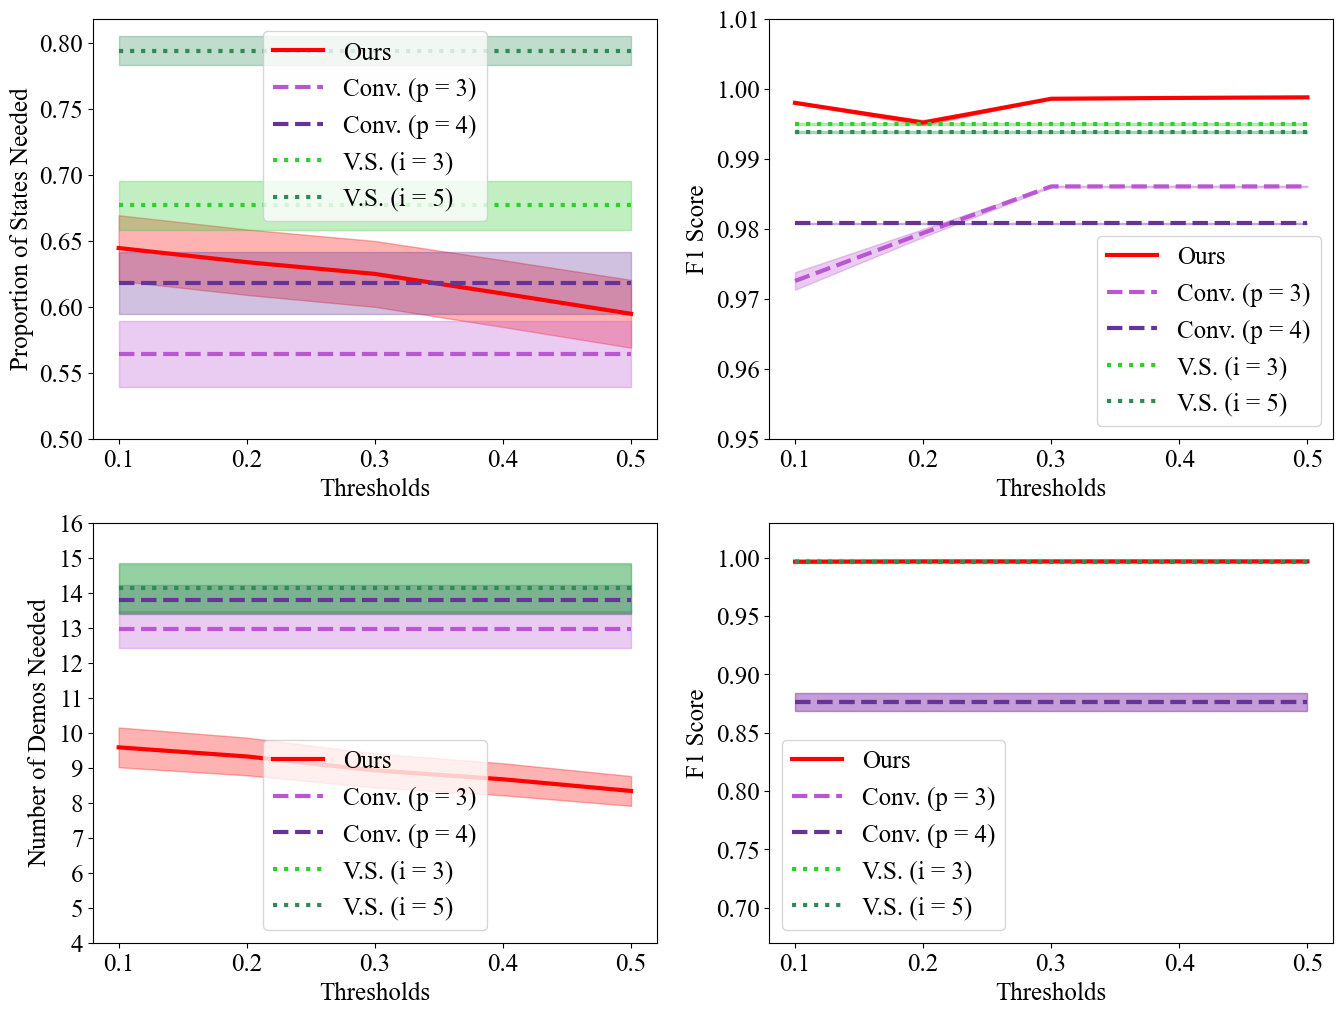

In [68]:
plot_consolidated_results(discrete_pct_states, discrete_F1s, cont_num_demos, cont_F1s, nevd_thresholds,
                          patience_value1 = pv1, patience_value2 = pv2, interval_value1 = iv1, interval_value2 = iv2,
                          plot_err = True)

### Table analysis

In [69]:
def calc_metrics_across_envs(metrics1, metrics2, thresholds, discrete):
    if discrete:
        pct_states = {t: [] for t in thresholds}
        for t in thresholds:
            pct_states[t].extend(metrics1["pct_states"][t])
            if metrics2:
                pct_states[t].extend(metrics2["pct_states"][t])
        print("Discrete pct states")
        for t in thresholds:
            print("Threshold {}: Mean = {}, err = {}".format(t, mean(pct_states[t]), sem(pct_states[t])))
        print("Discrete F1")
    else:
        num_demos = {t: [] for t in thresholds}
        for t in thresholds:
            num_demos[t].extend(metrics1["num_demos"][t])
            if metrics2:
                num_demos[t].extend(metrics2["num_demos"][t])
        print("Continuous num demos")
        for t in thresholds:
            print("Threshold {}: Mean = {}, err = {}".format(t, mean(num_demos[t]), sem(num_demos[t])))
        print("Continuous F1")
    F1s = {t: [] for t in thresholds}
    for t in thresholds:
        F1s[t].append(calc_F1(metrics1["confusion_matrices"][t]))
        if metrics2:
            F1s[t].append(calc_F1(metrics2["confusion_matrices"][t]))
    for t in thresholds:
        print("Threshold {}: Mean = {}, err = {}".format(t, mean(F1s[t]), sem(F1s[t])))

In [70]:
# PIOB table
calc_metrics_across_envs(lander_baseline_metrics, lavaworld_baseline_metrics, baseline_thresholds, False)

Continuous num demos
Threshold 0.0: Mean = 5.653543307086614, err = 0.2818325723886395
Threshold 0.1: Mean = 5.653543307086614, err = 0.2818325723886395
Threshold 0.2: Mean = 5.653543307086614, err = 0.2818325723886395
Threshold 0.3: Mean = 5.653543307086614, err = 0.2818325723886395
Threshold 0.4: Mean = 5.653543307086614, err = 0.2818325723886395
Threshold 0.5: Mean = 5.653543307086614, err = 0.2818325723886395
Threshold 0.6: Mean = 5.653543307086614, err = 0.2818325723886395
Threshold 0.7: Mean = 5.653543307086614, err = 0.2818325723886395
Threshold 0.8: Mean = 5.666666666666667, err = 0.28132774329116417
Threshold 0.9: Mean = 8.0, err = 0.0
Threshold 1.0: Mean = 8.0, err = 0.0
Continuous F1
Threshold 0.0: Mean = 0.9884215287200362, err = 0.0006603346901854379
Threshold 0.1: Mean = 0.9884215287200362, err = 0.0006603346901854379
Threshold 0.2: Mean = 0.9884215287200362, err = 0.0006603346901854379
Threshold 0.3: Mean = 0.9884215287200362, err = 0.0006603346901854379
Threshold 0.4: M

In [71]:
# Active tables
calc_metrics_across_envs(active_driving_baseline_metrics, None, baseline_thresholds, True)

Discrete pct states
Threshold 0.0: Mean = 0.544976076555024, err = 0.023586575616240082
Threshold 0.1: Mean = 0.5544757033248082, err = 0.022990305706988932
Threshold 0.2: Mean = 0.5820952380952381, err = 0.02209576354055024
Threshold 0.3: Mean = 0.5901298701298701, err = 0.0214309483136703
Threshold 0.4: Mean = 0.6160526315789474, err = 0.02036643197142144
Threshold 0.5: Mean = 0.6140206185567011, err = 0.0211429400338393
Threshold 0.6: Mean = 0.6076923076923078, err = 0.022491550024069197
Threshold 0.7: Mean = 0.6322580645161291, err = 0.02073287817098392
Threshold 0.8: Mean = 0.6416666666666667, err = 0.019269290478778806
Threshold 0.9: Mean = 0.6426666666666667, err = 0.014419739556902159
Threshold 1.0: Mean = 0.6222222222222222, err = 0.011173160079979143
Discrete F1
Threshold 0.0: Mean = 0.998805256869773, err = 0.0
Threshold 0.1: Mean = 0.9987228607918263, err = 0.0
Threshold 0.2: Mean = 0.9936305732484076, err = 0.0
Threshold 0.3: Mean = 0.9956709956709957, err = 0.0
Threshold 

### Empirical vs baseline statistical tests

In [72]:
trials = 20
p_threshold = 0.05

In [73]:
def check_ANOVA_assumptions(discrete, measure, *metrics):
    datapoints = []
    ours_data = []
    MAPs_data = []
    heldouts_data = []
    print("Discrete" if discrete else "Continuous")
    if measure == "efficiency":
        keys = ["pct_states"] if discrete else ["num_demos"]
    elif measure == "accuracy":
        keys = ["confusion_matrices", "confusion_matrix", "CM5", "CM4", "CM3", "CM2", "CM1"]
    for i in range(len(metrics)):
        metric = metrics[i]
        for key in keys:
            if key in metric:
                thresholds = metric[key].keys()
                for t in thresholds:
                    if measure == "efficiency":
                        datapoints.extend(metric[key][t])
                    else:
                        datapoints.append(calc_F1(metric[key][t]))
                    if 0 <= i < 2:
                        if measure == "efficiency":
                            ours_data.extend(metric[key][t])
                        else:
                            ours_data.append(calc_F1(metric[key][t]))
                    elif 2 <= i < 4:
                        if measure == "efficiency":
                            MAPs_data.extend(metric[key][t])
                        else:
                            MAPs_data.append(calc_F1(metric[key][t]))
                    else:
                        if measure == "efficiency":
                            heldouts_data.extend(metric[key][t])
                        else:
                            heldouts_data.append(calc_F1(metric[key][t]))
    # Q-Q plot
#     stats.probplot(datapoints, dist = "norm", plot = pylab)
#     pylab.show()
    # Shapiro-Wilk
    stat, p = stats.shapiro(datapoints)
    print("Shapiro")
    print(stat, p)
    # Levene for homogeneity of variance
    ours_data_transformed = np.array(ours_data)
#     plt.hist(ours_data_transformed)
    MAPs_data_transformed = np.sqrt(np.array(MAPs_data))
#     plt.hist(MAPs_data_transformed)
    heldouts_data_transformed = np.sqrt(np.array(heldouts_data))
#     plt.hist(heldouts_data_transformed)
    stat, p = stats.levene(ours_data_transformed, MAPs_data_transformed, heldouts_data_transformed, center = "trimmed")
    print("Levene")
    print(stat, p)
    return datapoints, ours_data, MAPs_data, heldouts_data

In [74]:
### Kruskal-Wallis test if ANOVA normality and homogeneity of variance are both violated
def kruskal_wallis(ours, MAPs, heldouts, discrete):
    stat, p = stats.kruskal(ours, MAPs, heldouts)
    print("Discrete" if discrete else "Continuous")
    print('Kruskal-Wallis H-statistic:', stat) 
    print('p-value:', p)

In [75]:
### Post-hoc test for KW to show WHICH groups are different
def dunn(ours, MAPs, heldouts, discrete, measure):
    print("Discrete" if discrete else "Continuous")
    groups = [ours, MAPs, heldouts]
    dunn = sp.posthoc_dunn(groups, p_adjust = "bonferroni")
    print(dunn)
    if dunn.loc[1, 2] < p_threshold:
        if measure == "efficiency":
            print("Ours has lower median than MAP:", np.median(ours) < np.median(MAPs))
        else:
            print("Ours has higher median than MAP:", np.median(ours) > np.median(MAPs))
    else:
        print("No difference between ours and MAP")
    if dunn.loc[1, 3] < p_threshold:
        if measure == "efficiency":
            print("Ours has lower median than held out:", np.median(ours) < np.median(heldouts))
        else:
            print("Ours has higher median than held out:", np.median(ours) > np.median(MAPs))
    else:
        print("No difference between ours and held out")

In [76]:
all_ps, ours_ps, MAPs_ps, heldouts_ps = check_ANOVA_assumptions(True, "efficiency", passive_goal_nevd_metrics,
                                                                passive_driving_nevd_metrics, goal_patience_metrics,
                                                                driving_patience_metrics, goal_held_out_metrics,
                                                                driving_held_out_metrics)
all_nd, ours_nd, MAPs_nd, heldouts_nd = check_ANOVA_assumptions(False, "efficiency", lander_nevd_metrics,
                                                                lavaworld_nevd_metrics, lander_patience_metrics,
                                                                lavaworld_patience_metrics, lander_held_out_metrics,
                                                                lavaworld_held_out_metrics)

Discrete
Shapiro
0.9506514072418213 9.019042220761859e-38
Levene
496.0381630006546 4.7661821609855825e-195
Continuous
Shapiro
0.9624913334846497 4.302814786580426e-33
Levene
1806.2448067343717 0.0


In [77]:
kruskal_wallis(ours_ps, MAPs_ps, heldouts_ps, True)
kruskal_wallis(ours_nd, MAPs_nd, heldouts_nd, False)

Discrete
Kruskal-Wallis H-statistic: 357.89913185718945
p-value: 1.9195126485526012e-78
Continuous
Kruskal-Wallis H-statistic: 601.3467358342232
p-value: 2.6255207704457534e-131


In [78]:
dunn(ours_ps, MAPs_ps, heldouts_ps, True, "efficiency")
dunn(ours_nd, MAPs_nd, heldouts_nd, False, "efficiency")

Discrete
              1             2             3
1  1.000000e+00  5.563391e-11  4.925515e-61
2  5.563391e-11  1.000000e+00  1.831932e-58
3  4.925515e-61  1.831932e-58  1.000000e+00
Ours has lower median than MAP: False
Ours has lower median than held out: True
Continuous
               1             2              3
1   1.000000e+00  5.525224e-15  3.903462e-129
2   5.525224e-15  1.000000e+00   4.083863e-01
3  3.903462e-129  4.083863e-01   1.000000e+00
Ours has lower median than MAP: True
Ours has lower median than held out: True


In [79]:
np.median(ours_ps) - np.median(MAPs_ps)

0.12

In [80]:
all_F1d, ours_F1d, MAPs_F1d, heldouts_F1d = check_ANOVA_assumptions(True, "accuracy", passive_goal_nevd_metrics,
                                                                passive_driving_nevd_metrics, goal_patience_metrics,
                                                                driving_patience_metrics, goal_held_out_metrics,
                                                                driving_held_out_metrics)
all_F1c, ours_F1c, MAPs_F1c, heldouts_F1c = check_ANOVA_assumptions(False, "accuracy", lander_nevd_metrics,
                                                                lavaworld_nevd_metrics, lander_patience_metrics,
                                                                lavaworld_patience_metrics, lander_held_out_metrics,
                                                                lavaworld_held_out_metrics)

Discrete
Shapiro
0.17038226127624512 2.5415530741830145e-22
Levene
54.977644934275496 7.024463490087572e-17
Continuous
Shapiro
0.617169976234436 1.6525060111933316e-15
Levene
33.02430164202267 1.0283841751022487e-11


In [81]:
kruskal_wallis(ours_F1d, MAPs_F1d, heldouts_F1d, True)
kruskal_wallis(ours_F1c, MAPs_F1c, heldouts_F1c, False)

Discrete
Kruskal-Wallis H-statistic: 70.55984831948773
p-value: 4.765666150935536e-16
Continuous
Kruskal-Wallis H-statistic: 83.11156537247906
p-value: 8.965053553396429e-19


In [82]:
dunn(ours_F1d, MAPs_F1d, heldouts_F1d, True, "accuracy")
dunn(ours_F1c, MAPs_F1c, heldouts_F1c, False, "accuracy")

Discrete
              1             2             3
1  1.000000e+00  7.450763e-08  1.000000e+00
2  7.450763e-08  1.000000e+00  3.891688e-14
3  1.000000e+00  3.891688e-14  1.000000e+00
Ours has higher median than MAP: True
No difference between ours and held out
Continuous
              1             2             3
1  1.000000e+00  2.138879e-08  1.000000e+00
2  2.138879e-08  1.000000e+00  1.183225e-16
3  1.000000e+00  1.183225e-16  1.000000e+00
Ours has higher median than MAP: True
No difference between ours and held out


# User study analysis

In [83]:
user_studies = pd.DataFrame()
folder_path = "../ijcai-hri/user_study_results/"
for filename in os.listdir(folder_path):
    if filename.startswith("success-") and filename.endswith(".json"):
        file_path = os.path.join(folder_path, filename)
        with open(file_path, "r") as json_file:
            try:
                data = json.load(json_file)
                # Check if the DataFrame has columns not present in the JSON
                missing_cols = set(user_studies.columns) - set(data.keys())
                if missing_cols:
                    for col in missing_cols:
                        data[col] = None  # Add missing columns with np.nan values
                # Check if the JSON has columns not present in the DataFrame
                extra_cols = set(data.keys()) - set(user_studies.columns)
                if extra_cols:
                    for col in extra_cols:
                        user_studies[col] = None  # Add columns to the DataFrame with np.nan values
                # Append the data to the master DataFrame
                user_studies = user_studies.append(data, ignore_index = True)
                user_studies.loc[user_studies.index[-1], "file"] = os.path.splitext(filename)[0]
            except Exception:
                print(file_path)
len(user_studies)

104

In [84]:
import warnings
warnings.filterwarnings("ignore")

### Newest Analysis

In [85]:
# Metrics: num demos, F1 score
usable = user_studies[~(user_studies["pct_states"].isna())
                      & ~(user_studies["user_evaluation"].isna())
                      & (user_studies["demo_suff"] == True)]
usable["pct_states"] = pd.to_numeric(usable["pct_states"])
usable["user_evaluation"] = pd.to_numeric(usable["user_evaluation"])

ours = usable[usable["methodology"] == "ours"]
ours_gridworld = ours[ours["is_gridworld"] == True]
ours_driving = ours[ours["is_gridworld"] == False]
MAPs = usable[usable["methodology"] == "MAP"]
MAPs_gridworld = MAPs[MAPs["is_gridworld"] == True]
MAPs_driving = MAPs[MAPs["is_gridworld"] == False]
held_outs = usable[usable["methodology"] == "held_out"]
held_outs_gridworld = held_outs[held_outs["is_gridworld"] == True]
held_outs_driving = held_outs[held_outs["is_gridworld"] == False]
gridworlds = usable[usable["is_gridworld"] == True]
drivings = usable[usable["is_gridworld"] == False]

print(len(usable))
print(len(ours), len(MAPs), len(held_outs))
print(len(gridworlds), len(drivings))

104
26 21 18
62 42


In [86]:
print("Empirical vs. User Study, Metrics at nEVD threshold = 0.3")

print("Gridworld empirical pct states:")
ps_mean = round(mean(passive_goal_nevd_metrics["pct_states"][0.3]), 2)
ps_sem = round(sem(passive_goal_nevd_metrics["pct_states"][0.3], n = 20), 2)
print("Mean = {}, std = {}".format(ps_mean, ps_sem))
# f1 = calc_F1(passive_goal_nevd_metrics["confusion_matrices"][0.3])
# print("Gridworld empirical F1 score: {}".format(f1))
# print()

print("Driving empirical pct states:")
ps_mean = round(mean(passive_driving_nevd_metrics["pct_states"][0.3]), 2)
ps_sem = round(sem(passive_driving_nevd_metrics["pct_states"][0.3], n = 20), 2)
print("Mean = {}, std = {}".format(ps_mean, ps_sem))
# f1 = calc_F1(passive_driving_nevd_metrics["confusion_matrices"][0.3])
# print("Driving empirical F1 score: {}".format(f1))
# print()

print("Gridworld user study pct states:")
ps_mean = round(mean(pd.to_numeric(ours_gridworld["pct_states"]).tolist()), 2)
ps_sem = round(sem(pd.to_numeric(ours_gridworld["pct_states"]).tolist(), n = len(ours_gridworld)), 2)
print("Mean = {}, std = {}".format(ps_mean, ps_sem))
# total_cm = np.array([[0, 0], [0, 0]])
# for index, row in ours_gridworld.iterrows():
#     total_cm += np.array(row["confusion_matrix"])
# f1 = calc_F1(total_cm)
# print("Gridworld user study F1 score: {}".format(f1))
# print()

print("Driving user study pct states:")
ps_mean = round(mean(pd.to_numeric(ours_driving["pct_states"]).tolist()), 2)
ps_sem = round(sem(pd.to_numeric(ours_driving["pct_states"]).tolist(), n = len(ours_driving)), 2)
print("Mean = {}, std = {}".format(ps_mean, ps_sem))
# total_cm = np.array([[0, 0], [0, 0]])
# for index, row in ours_driving.iterrows():
#     total_cm += np.array(row["confusion_matrix"])
# f1 = calc_F1(total_cm)
# print("Driving user study F1 score: {}".format(f1))

Empirical vs. User Study, Metrics at nEVD threshold = 0.3
Gridworld empirical pct states:
Mean = 0.57, std = 0.06
Driving empirical pct states:
Mean = 0.7, std = 0.05
Gridworld user study pct states:
Mean = 0.22, std = 0.05
Driving user study pct states:
Mean = 0.25, std = 0.06


In [87]:
print("User Study Three Methods, Metrics at nEVD threshold = 0.3, patience = 3, interval = 5")

print("OURS: gridworld pct states:")
ps_mean = round(mean(pd.to_numeric(ours_gridworld["pct_states"]).tolist()), 2)
ps_sem = round(sem(pd.to_numeric(ours_gridworld["pct_states"]).tolist(), n = len(ours_gridworld)), 2)
print("Mean = {}, std = {}".format(ps_mean, ps_sem))
# total_cm = np.array([[0, 0], [0, 0]])
# for index, row in ours_gridworld.iterrows():
#     total_cm += np.array(row["confusion_matrix"])
# f1 = calc_F1(total_cm)
# print("F1 score: {}".format(f1))
print("User eval")
ue_mean = round(mean(pd.to_numeric(ours_gridworld["user_evaluation"]).tolist()), 2)
ue_sem = round(sem(pd.to_numeric(ours_gridworld["user_evaluation"]).tolist(), n = len(ours_gridworld)), 2)
print("Mean = {}, std = {}".format(ue_mean, ue_sem))
print()

print("OURS: driving pct states:")
ps_mean = round(mean(pd.to_numeric(ours_driving["pct_states"]).tolist()), 2)
ps_sem = round(sem(pd.to_numeric(ours_driving["pct_states"]).tolist(), n = len(ours_driving)), 2)
print("Mean = {}, std = {}".format(ps_mean, ps_sem))
# total_cm = np.array([[0, 0], [0, 0]])
# for index, row in ours_driving.iterrows():
#     total_cm += np.array(row["confusion_matrix"])
# f1 = calc_F1(total_cm)
# print("F1 score: {}".format(f1))
print("User eval")
ue_mean = round(mean(pd.to_numeric(ours_driving["user_evaluation"]).tolist()), 2)
ue_sem = round(sem(pd.to_numeric(ours_driving["user_evaluation"]).tolist(), n = len(ours_driving)), 2)
print("Mean = {}, std = {}".format(ue_mean, ue_sem))
print()

print("MAP: gridworld pct states:")
ps_mean = round(mean(pd.to_numeric(MAPs_gridworld["pct_states"]).tolist()), 2)
ps_sem = round(sem(pd.to_numeric(MAPs_gridworld["pct_states"]).tolist(), n = len(MAPs_gridworld)), 2)
print("Mean = {}, std = {}".format(ps_mean, ps_sem))
# total_cm = np.array([[0, 0], [0, 0]])
# for index, row in MAPs_gridworld.iterrows():
#     total_cm += np.array(row["confusion_matrix"])
# f1 = calc_F1(total_cm)
# print("F1 score: {}".format(f1))
print("User eval")
ue_mean = round(mean(pd.to_numeric(MAPs_gridworld["user_evaluation"]).tolist()), 2)
ue_sem = round(sem(pd.to_numeric(MAPs_gridworld["user_evaluation"]).tolist(), n = len(MAPs_gridworld)), 2)
print("Mean = {}, std = {}".format(ue_mean, ue_sem))
print()

print("MAP: driving pct states:")
ps_mean = round(mean(pd.to_numeric(MAPs_driving["pct_states"]).tolist()), 2)
ps_sem = round(sem(pd.to_numeric(MAPs_driving["pct_states"]).tolist(), n = len(MAPs_driving)), 2)
print("Mean = {}, std = {}".format(ps_mean, ps_sem))
# total_cm = np.array([[0, 0], [0, 0]])
# for index, row in MAPs_driving.iterrows():
#     total_cm += np.array(row["confusion_matrix"])
# f1 = calc_F1(total_cm)
# print("F1 score: {}".format(f1))
print("User eval")
ue_mean = round(mean(pd.to_numeric(MAPs_driving["user_evaluation"]).tolist()), 2)
ue_sem = round(sem(pd.to_numeric(MAPs_driving["user_evaluation"]).tolist(), n = len(MAPs_driving)), 2)
print("Mean = {}, std = {}".format(ue_mean, ue_sem))
print()

print("HELD OUT: gridworld pct states:")
ps_mean = round(mean(pd.to_numeric(held_outs_gridworld["pct_states"]).tolist()), 2)
ps_sem = round(sem(pd.to_numeric(held_outs_gridworld["pct_states"]).tolist(), n = len(held_outs_gridworld)), 2)
print("Mean = {}, std = {}".format(ps_mean, ps_sem))
# total_cm = np.array([[0, 0], [0, 0]])
# for index, row in held_outs_gridworld.iterrows():
#     total_cm += np.array(row["confusion_matrix"])
# f1 = calc_F1(total_cm)
# print("F1 score: {}".format(f1))
print("User eval")
ue_mean = round(mean(pd.to_numeric(held_outs_gridworld["user_evaluation"]).tolist()), 2)
ue_sem = round(sem(pd.to_numeric(held_outs_gridworld["user_evaluation"]).tolist(), n = len(held_outs_gridworld)), 2)
print("Mean = {}, std = {}".format(ue_mean, ue_sem))
print()

print("HELD OUT: driving pct states:")
ps_mean = round(mean(pd.to_numeric(held_outs_driving["pct_states"]).tolist()), 2)
ps_sem = round(sem(pd.to_numeric(held_outs_driving["pct_states"]).tolist(), n = len(held_outs_driving)), 2)
print("Mean = {}, std = {}".format(ps_mean, ps_sem))
# total_cm = np.array([[0, 0], [0, 0]])
# for index, row in held_outs_driving.iterrows():
#     total_cm += np.array(row["confusion_matrix"])
# f1 = calc_F1(total_cm)
# print("F1 score: {}".format(f1))
print("User eval")
ue_mean = round(mean(pd.to_numeric(held_outs_driving["user_evaluation"]).tolist()), 2)
ue_sem = round(sem(pd.to_numeric(held_outs_driving["user_evaluation"]).tolist(), n = len(held_outs_driving)), 2)
print("Mean = {}, std = {}".format(ue_mean, ue_sem))

User Study Three Methods, Metrics at nEVD threshold = 0.3, patience = 3, interval = 5
OURS: gridworld pct states:
Mean = 0.22, std = 0.05
User eval
Mean = 4.31, std = 0.4

OURS: driving pct states:
Mean = 0.25, std = 0.06
User eval
Mean = 4.15, std = 0.28

MAP: gridworld pct states:
Mean = 0.45, std = 0.03
User eval
Mean = 3.47, std = 0.32

MAP: driving pct states:
Mean = 0.69, std = 0.07
User eval
Mean = 3.0, std = 0.71

HELD OUT: gridworld pct states:
Mean = 0.64, std = 0.0
User eval
Mean = 4.0, std = 0.53

HELD OUT: driving pct states:
Mean = 0.6, std = 0.03
User eval
Mean = 4.0, std = 0.39


In [88]:
def check_ANOVA_assumptions_user_study(measure, *metrics):
    print("Comparing {}".format(measure))
    datapoints = []
    ours_data = []
    MAPs_data = []
    heldouts_data = []
    if measure == "efficiency":
        key = "pct_states"
    elif measure == "accuracy":
        key = "user_evaluation"
    for i in range(len(metrics)):
        metric = metrics[i]
        datapoints.extend(metric[key])
        if i == 0:
            ours_data.extend(metric[key])
        elif i == 1:
            MAPs_data.extend(metric[key])
        else:
            heldouts_data.extend(metric[key])
    ours_data_transformed = np.array(ours_data)
    MAPs_data_transformed = np.array(MAPs_data)
    heldouts_data_transformed = np.array(heldouts_data)
    print("Shapiro")
    print("Ours", stats.shapiro(ours_data_transformed))
    print("MAPs", stats.shapiro(MAPs_data_transformed))
    print("Heldouts", stats.shapiro(heldouts_data_transformed))
    stat, p = stats.levene(ours_data_transformed, MAPs_data_transformed, heldouts_data_transformed, center = "trimmed")
    print("Levene")
    print(stat, p)
    return datapoints, ours_data, MAPs_data, heldouts_data        

In [89]:
print("Gridworld")
user_ps_gridworld_results = check_ANOVA_assumptions_user_study("efficiency", ours_gridworld,
                                                               MAPs_gridworld, held_outs_gridworld)
_, ours_user_ps_gridworld, MAPs_user_ps_gridworld, heldouts_user_ps_gridworld = user_ps_gridworld_results
print()
user_F1_gridworld_results = check_ANOVA_assumptions_user_study("accuracy", ours_gridworld,
                                                               MAPs_gridworld, held_outs_gridworld)
_, ours_user_F1_gridworld, MAPs_user_F1_gridworld, heldouts_user_F1_gridworld = user_F1_gridworld_results
print("\n")
print("Driving")
user_ps_driving_results = check_ANOVA_assumptions_user_study("efficiency", ours_driving,
                                                               MAPs_driving, held_outs_driving)
_, ours_user_ps_driving, MAPs_user_ps_driving, heldouts_user_ps_driving = user_ps_driving_results
print()
user_F1_driving_results = check_ANOVA_assumptions_user_study("accuracy", ours_driving,
                                                               MAPs_driving, held_outs_driving)
_, ours_user_F1_driving, MAPs_user_F1_driving, heldouts_user_F1_driving = user_F1_driving_results

Gridworld
Comparing efficiency
Shapiro
Ours ShapiroResult(statistic=0.7711207866668701, pvalue=0.003156913910061121)
MAPs ShapiroResult(statistic=0.9667853116989136, pvalue=0.8079301714897156)
Heldouts ShapiroResult(statistic=1.0, pvalue=1.0)
Levene
5.121112992958774 0.011761180724126994

Comparing accuracy
Shapiro
Ours ShapiroResult(statistic=0.5154749751091003, pvalue=1.3333539754967205e-05)
MAPs ShapiroResult(statistic=0.8692171573638916, pvalue=0.03286019712686539)
Heldouts ShapiroResult(statistic=0.749640703201294, pvalue=0.012578536756336689)
Levene
0.03343913837385612 0.9671475169902396


Driving
Comparing efficiency
Shapiro
Ours ShapiroResult(statistic=0.8287855982780457, pvalue=0.015294715762138367)
MAPs ShapiroResult(statistic=0.8806628584861755, pvalue=0.2721151113510132)
Heldouts ShapiroResult(statistic=0.34499120712280273, pvalue=2.2434040403140898e-08)
Levene
2.417858206943138 0.10815916995493778

Comparing accuracy
Shapiro
Ours ShapiroResult(statistic=0.7763369083404541,

In [90]:
print("Gridworld, Efficiency")
kruskal_wallis(ours_user_ps_gridworld, MAPs_user_ps_gridworld, heldouts_user_ps_gridworld, True)
print()
print("Driving, Efficiency")
kruskal_wallis(ours_user_ps_driving, MAPs_user_ps_driving, heldouts_user_ps_driving, True)

Gridworld, Efficiency
Discrete
Kruskal-Wallis H-statistic: 19.38349803375271
p-value: 6.179123593686934e-05

Driving, Efficiency
Discrete
Kruskal-Wallis H-statistic: 14.476131257059091
p-value: 0.0007187006503952844


In [91]:
dunn(ours_user_ps_gridworld, MAPs_user_ps_gridworld, heldouts_user_ps_gridworld, True, "efficiency")
dunn(ours_user_ps_driving, MAPs_user_ps_driving, heldouts_user_ps_driving, True, "efficiency")

Discrete
          1         2         3
1  1.000000  0.021137  0.000050
2  0.021137  1.000000  0.088095
3  0.000050  0.088095  1.000000
Ours has lower median than MAP: True
Ours has lower median than held out: True
Discrete
          1         2         3
1  1.000000  0.001995  0.012415
2  0.001995  1.000000  0.958713
3  0.012415  0.958713  1.000000
Ours has lower median than MAP: True
Ours has lower median than held out: True


In [92]:
print("Gridworld, User eval")
kruskal_wallis(ours_user_F1_gridworld, MAPs_user_F1_gridworld, heldouts_user_F1_gridworld, True)
print()
print("Driving, User eval")
kruskal_wallis(ours_user_F1_driving, MAPs_user_F1_driving, heldouts_user_F1_driving, True)

Gridworld, User eval
Discrete
Kruskal-Wallis H-statistic: 5.825996354692007
p-value: 0.05431264656848178

Driving, User eval
Discrete
Kruskal-Wallis H-statistic: 1.8135338981260392
p-value: 0.4038277113383266


In [93]:
print("Efficiency Both Environments")
kruskal_wallis(ours_user_ps_gridworld + ours_user_ps_driving,
               MAPs_user_ps_gridworld + MAPs_user_ps_driving,
               heldouts_user_ps_gridworld + heldouts_user_ps_driving, True)
print()
print("User Eval Both Environments")
kruskal_wallis(ours_user_F1_gridworld + ours_user_F1_driving,
               MAPs_user_F1_gridworld + MAPs_user_F1_driving,
               heldouts_user_F1_gridworld + heldouts_user_F1_driving, True)

Efficiency Both Environments
Discrete
Kruskal-Wallis H-statistic: 29.800133651978896
p-value: 3.380517569924905e-07

User Eval Both Environments
Discrete
Kruskal-Wallis H-statistic: 6.788891051300594
p-value: 0.033559156705949236


### Old Stuff

In [94]:
# Table comparing metrics M = {percent of states needed for demo, bound error, policy optimality, accuracy, TPR, TNR}
# between the 0.3 threshold values from our experiments and the user study results, for both environments.
# Show that user study values are roughly equivalent the empirical values, despite potentially suboptimal demos

In [95]:
usable = user_studies[~(user_studies["pct_states"].isna()) & ~(user_studies["bound_error"].isna())
                      & ~(user_studies["policy_optimality"].isna()) & ~(user_studies["confusion_matrix"].isna())]
len(usable)

63

In [96]:
def calc_TPR(row, metric_name = "confusion_matrix"):
    cm = row[metric_name]
    try:
        tpr = cm[0][0] / (cm[0][0] + cm[1][0])
    except ZeroDivisionError:
        tpr = 0
    return tpr

def calc_TNR(row, metric_name = "confusion_matrix"):
    cm = row[metric_name]
    try:
        tnr = cm[1][1] / (cm[0][1] + cm[1][1])
    except ZeroDivisionError:
        tnr = 0
    return tnr

usable["tpr"] = usable.apply(calc_TPR, axis = 1)
usable["tnr"] = usable.apply(calc_TNR, axis = 1)

ours = usable[usable["methodology"] == "ours"]
MAPs = usable[usable["methodology"] == "MAP"]
held_outs = usable[usable["methodology"] == "held_out"]

In [97]:
def user_study_comparisons(results, name, comparing_with_baseline = False):
    # Either comparing empirical vs. user study
    # Or comparing three user study methods
    print(name + " Results")
    if type(results) == dict:
        ps_mean = round(mean(results["pct_states"][0.3]), 2)
        ps_sem = round(sem(results["pct_states"][0.3], n = 20), 2)
        if not comparing_with_baseline:
            be_mean = round(mean(results["avg_bound_errors"][0.3]), 2)
            be_sem = round(sem(results["avg_bound_errors"][0.3], n = 20), 2)
        po_mean = round(mean(results["policy_optimalities"][0.3]), 2)
        po_sem = round(sem(results["policy_optimalities"][0.3], n = 20), 2)
        acc = round(results["accuracies"][0.3], 2)
        if not comparing_with_baseline:
            tpr = round(calc_TPR(results["confusion_matrices"], 0.3), 2)
            tnr = round(calc_TNR(results["confusion_matrices"], 0.3), 2)
    else:
        ps_mean = round(mean(pd.to_numeric(results["pct_states"]).tolist()), 2)
        ps_sem = round(sem(pd.to_numeric(results["pct_states"]).tolist(), n = len(results)), 2)
        if not comparing_with_baseline:
            be_mean = round(mean(pd.to_numeric(results["bound_error"]).tolist()), 2)
            be_sem = round(sem(pd.to_numeric(results["bound_error"]).tolist(), n = len(results)), 2)
        po_mean = round(mean(pd.to_numeric(results["policy_optimality"]).tolist()), 2)
        po_sem = round(sem(pd.to_numeric(results["policy_optimality"]).tolist(), n = len(results)), 2)
        acc = round(len(results[results["good_bound"] == True]) / len(results), 2)
        if not comparing_with_baseline:
            tpr = round(np.mean(pd.to_numeric(results["tpr"])), 2)
            tnr = round(np.mean(pd.to_numeric(results["tnr"])), 2)
        if comparing_with_baseline:
            user_eval = round(np.mean(pd.to_numeric(results["user_evaluation"])), 2)
    print(f"Prop. states: mean = {ps_mean}, sem = {ps_sem}")
    if not comparing_with_baseline:
        print(f"Bound error: mean = {be_mean}, sem = {be_sem}")
    print(f"Policy opt: mean = {po_mean}, sem = {po_sem}")
    print(f"Accuracy = {acc}")
    if not comparing_with_baseline:
        print(f"TPR = {tpr}")
        print(f"TNR = {tnr}")
    if comparing_with_baseline:
        print(f"User evaluation = {user_eval}")
    print()

In [98]:
user_study_comparisons(passive_goal_nevd_metrics, "Empirical Gridworld")
user_study_comparisons(ours[ours["is_gridworld"] == True], "User Study Gridworld")
user_study_comparisons(passive_driving_nevd_metrics, "Empirical Driving")
user_study_comparisons(ours[ours["is_gridworld"] == False], "User Study Driving")

Empirical Gridworld Results
Prop. states: mean = 0.57, sem = 0.06
Bound error: mean = 0.01, sem = 0.01
Policy opt: mean = 0.98, sem = 0.01
Accuracy = 0.96
TPR = 0.94
TNR = 1.0

User Study Gridworld Results
Prop. states: mean = 0.2, sem = 0.06
Bound error: mean = 0.1, sem = 0.03
Policy opt: mean = 0.86, sem = 0.04
Accuracy = 0.91
TPR = 0.82
TNR = 0.55

Empirical Driving Results
Prop. states: mean = 0.7, sem = 0.05
Bound error: mean = 0.05, sem = 0.01
Policy opt: mean = 0.98, sem = 0.01
Accuracy = 0.98
TPR = 0.62
TNR = 1.0

User Study Driving Results
Prop. states: mean = 0.25, sem = 0.06
Bound error: mean = -0.1, sem = 0.14
Policy opt: mean = 0.8, sem = 0.05
Accuracy = 0.69
TPR = 0.69
TNR = 0.42



In [99]:
# Table comparing M - {bound error, TPR, TNR, acc} + {user ranking} between our method values vs. baseline values
# Removing accuracy because each accuracy metric is comparing different things

In [100]:
user_study_comparisons(ours[ours["is_gridworld"] == True], "Our Gridworld", True)
user_study_comparisons(MAPs[MAPs["is_gridworld"] == True], "MAP Baseline Gridworld", True)
user_study_comparisons(held_outs[held_outs["is_gridworld"] == True], "Held Out Set Baseline Gridworld", True)
user_study_comparisons(ours[ours["is_gridworld"] == False], "Our Driving", True)
user_study_comparisons(MAPs[MAPs["is_gridworld"] == False], "MAP Baseline Driving", True)
user_study_comparisons(held_outs[held_outs["is_gridworld"] == False], "Held Out Set Baseline Driving", True)

Our Gridworld Results
Prop. states: mean = 0.2, sem = 0.06
Policy opt: mean = 0.86, sem = 0.04
Accuracy = 0.91
User evaluation = 4.18

MAP Baseline Gridworld Results
Prop. states: mean = 0.45, sem = 0.03
Policy opt: mean = 0.9, sem = 0.03
Accuracy = 0.0
User evaluation = 3.47

Held Out Set Baseline Gridworld Results
Prop. states: mean = 0.64, sem = 0.0
Policy opt: mean = 0.89, sem = 0.08
Accuracy = 0.0
User evaluation = 4.0

Our Driving Results
Prop. states: mean = 0.25, sem = 0.06
Policy opt: mean = 0.8, sem = 0.05
Accuracy = 0.69
User evaluation = 4.15

MAP Baseline Driving Results
Prop. states: mean = 0.69, sem = 0.07
Policy opt: mean = 0.78, sem = 0.11
Accuracy = 0.0
User evaluation = 3.0

Held Out Set Baseline Driving Results
Prop. states: mean = 0.6, sem = 0.03
Policy opt: mean = 0.91, sem = 0.03
Accuracy = 0.0
User evaluation = 4.0



In [101]:
# Table comparing metrics M between user study’s freeform vs guided values.
# perhaps number of demos, bound error, and evaluation

In [102]:
freeform = usable[usable["teaching_option"] == "freeform"]
guided = usable[usable["teaching_option"] == "guided"]
print(pd.to_numeric(freeform.pct_states).mean())
print(pd.to_numeric(guided.pct_states).mean())
print()
print(pd.to_numeric(freeform[freeform["methodology"] == "ours"].bound_error).mean())
print(pd.to_numeric(guided[guided["methodology"] == "ours"].bound_error).mean())
print()
print(pd.to_numeric(freeform.user_evaluation).mean())
print(pd.to_numeric(guided.user_evaluation).mean())

0.4680000000000001
0.4072727272727273

-0.10133812316861156
0.10395481261559193

3.8666666666666667
3.8181818181818183
